## SER-SAG Periodicity Pipeline (LSST in-kind contribution project)

<i> <b> Abstract </i> </b>: Our periodicity-search pipeline includes nonparametric and parametric light curve modelling, based on   different time-domain period-detection algorithms, and a set of techniques for determining the significance level of potential periods. The proposed pipeline combines different time-domain algorithms, including machine learning of light curves, to exploits the information. The pipeline outputs are the extracted light curve periodic features (periodicities, uncertainties, periods probability) which will serve especially the TVS and AGN science collaborations, as well as any other interestred group, for further variability investigations.

<p> 
The software is currently under development, and it will be developed as a  python package available to download and distribute using the PyPi repository. We have made this choice in order to distribute, maintain, and develop software and its versions more easily. Also, the package can be easily installed and executed on the RSP platform.
</p>

<p>
    The package will be separated into a few different modules: </p>
    <ol>
        <li> read module. Read module is primarily used for data acquisition and pre-processing. It will fetch data (either from RSP or user data), and it will check if all necessary pieces of information are given, normalize it and create input objects that will be used as input in our pipeline. For the pipeline to function correctly, initial data must have Object ID, time, flux, flux uncertainty, multi-band LSST Lomb-Scargle periodicity, and it must be supplied by the user (or the connecting system, such as RSP). Read module will have three sub-modules. The first one, named lsst, will be intended for reading and obtaining data from lsst RSP. It will have different functions that will be able to reach lsst data remotely (using API or tas protocol) or directly in RSP. The second one, named user, will have similar functions but for the data supplied by the user. The third one is used for data normalization and basic pre-processing.  </li>
 
<li> Utils module. The purpose of this module is to store any functions that can be used as utilities, e.g., functions to simulate artificial light curves or any other calculation-based functions such as autocorrelation functions, etc. </li>

<li> Plots module. This module's primary purpose is for the graphical representation of data. It has functions to visualize input data, as well as output data. </li>

<li> Output module. This module's purpose is to obtain output data as Python objects. It will have functions that implement our pipeline to obtain periodic features of the LC. Also, it will have the ability to simultaneously execute a vast number of different LC to obtain catalogs with periodicities. To logically organize the module, it will have two sub-modules, one for obtaining periodicity features for a single LC and the other with functions for multiple light curves. </li>
        </ol>
</p>


### Application of the WWZ method to determine a periodicity of a time signal

-The weighted wavelet Z-transform (WWZ, Foster 1996;  Gupta et al. 2018). To calculate the significance, we use the simulated light curves technique. To obtain the significance, LCs are simulated, based on the best-fitting result of power spectral density and the probability density function of the original LC (see Emmanoulopoulos et al, 2013). For each simulated LC, a WWZ power spectrum is calculated and significance is determined as in Kovacevic et al 2020 .                 
For significance determination it is critical to determine how many light curves can be simulated, which may be several thousands for wavelet-based methods due to processing capacity. 



In [1]:
# imports
import rubin_sim.maf as maf
import os
import numpy as np
import math
from rubin_sim.data import get_baseline
from rubin_sim.maf import *
from rubin_sim.utils import *
import healpy as hp
import matplotlib.pyplot as plt
%matplotlib inline


#import ser-sag periodicity python package
import sys
sys.path.insert(0, '/home/viktor/Documents/LSST/MAF/inkind/baseperiodicity')
from periodicity import *

In [2]:
def maf_cadence(opsim, name, ra = 0, dec = 0, fil = 'r'):
    colmn = 'observationStartMJD';
    outDir = 'TmpDir'
    resultsDb = maf.ResultsDb(outDir=outDir)
    metric=PassMetric(cols=[colmn, 'filter'])
    slicer = maf.UserPointsSlicer(ra=ra,dec=dec)
    sqlconstraint = 'filter = \'' + fil + '\''
   
    
    # Run simulation
    bundle = maf.MetricBundle(
        metric, slicer, sqlconstraint, runName=name)
    bgroup = maf.MetricBundleGroup(
        {0: bundle}, opsim, outDir=outDir, resultsDb=resultsDb)
    bgroup.runAll();
    filters = np.unique(bundle.metricValues[0]['filter'])
    mv = bundle.metricValues[0]
    
    
    # Get dates
    mjd  = (mv[colmn])
    return np.sort(mjd)



In [3]:
opsim_fname = get_baseline()
print(opsim_fname)
runName = os.path.split(opsim_fname)[-1].replace('.db', '')
print(runName)

ddfs = ddf_locations()
print(ddfs)
opsim_db = maf.OpsimDatabase(opsim_fname)
opsim_data = maf_cadence(opsim_db,"name", ddfs['ELAISS1'][0], ddfs['ELAISS1'][1])


/home/viktor/rubin_sim_data/sim_baseline/baseline_nexp2_v1.7_10yrs.db
baseline_nexp2_v1.7_10yrs
{'ELAISS1': (9.45, -44.0), 'XMM_LSS': (35.708333, -4.75), 'ECDFS': (53.125, -28.1), 'COSMOS': (150.1, 2.1819444444444445), 'EDFS_a': (58.9, -49.315), 'EDFS_b': (63.6, -47.6)}
Querying database SummaryAllProps with constraint filter = 'r' for columns ['filter', 'fieldRA', 'observationStartMJD', 'fieldDec', 'rotSkyPos']
Found 452001 visits
Running:  [0]
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


In [4]:
# Size of OpSim data
len_os = len(opsim_data)
len_os

4262

In [24]:
amplitudes =  np.array([0.1, 0.2, 0.3, 0.4])  # [0.1, 0.2, 0.3, 0.4]
freq = np.array([100])
percent = np.array([0, 0.4, 0.6, 0.8, 0.9]) # [0, 0.4, 0.6, 0.8, 0.9]
mjd_start = np.min(opsim_data)
magnitude = 20
time_interval = 10

In [5]:
names = ['baseline_v2.0_10yrs', 'carina_v2.0_10yrs', 'ddf_frac_ddf_per0.6_v2.0_10yrs', 'euclid_dither1_v1.7_10yrs', 'euclid_dither3_v1.7_10yrs',
         'footprint_0_v1.710yrs', 'long_gaps_nightsoff4_delayed-1_v2.0_10yrs', 'multi_short_v2.0_10yrs', 'rolling_all_sky_ns2_rw0.9_v2.0_10yrs',
          'short_exp_v2.0_10yrs']
filters = ['r']

In [6]:
ddf_ra = ddfs['ELAISS1'][0]
ddf_dec = ddfs['ELAISS1'][1]
#     slicer = maf.UserPointsSlicer(ra=ddf_ra, dec=ddf_dec, useCamera=False, latLonDeg=True)   
slicer = maf.UserPointsSlicer(ra=ddf_ra, dec=ddf_dec, useCamera=False, latLonDeg=True)

In [ ]:
amplitudes =  np.array([0.1, 0.2, 0.3, 0.4]) 
result_opsims  = []
for A in amplitudes:
    for name in names:
        
        runName = name + '.db'
        opsim_db = maf.OpsimDatabase('/home/viktor/Desktop/LSST/MAF/data/' + runName)
        opsim_data = maf_cadence(opsim_db,"name", ddfs['ELAISS1'][0], ddfs['ELAISS1'][1])
        mjd_start = np.min(opsim_data)
        tt, yy = simple_mock_lc(time_interval = 10, num_points = len(opsim_data), 
                                        frequency = 150, amplitude = A, percent = 0, magnitude = 22, mjd_start = mjd_start)
    
        ttt, yyy = artificial_lc_sampled(opsim_data, tt, yy)
        fig_plot(tt, yy) 
        fig_plot(ttt, yyy) 
        plt.show()
        current = np.array([A, 150])
        fmax = 1/ 100 # (1. /400.) 0.011111
        fmin = 1/ 210  # (1. /1.)  0.00909
        df = (fmax - fmin) / 5000
        params = [fmin, fmax, df, True] 
        print(params)
        time_division = 80
        wwt_result, params = wwt(ttt, yyy, time_division, params)
        peaks, result, osex, hh1arr1  = wwt_find_freq(wwt_result, time_division)
        print(result)
        current = np.append(current, result)


        result_opsims.insert(len(result_opsims), current)
    
    
            

In [9]:
print(len(result_opsims))
np.savetxt("data_150days_opsim_1.csv", result_opsims, delimiter=",")


40


In [30]:
import matplotlib.pyplot as plt
import pandas as pd
tmp = result_opsims
br = 0
test = []
for i in result_opsims:
    i = np.append(i, [int(br%10)])
    i = np.append(i, [np.abs(i[2] - 150)/150])
    test.insert(len(test), i)
    br = br + 1
test
print(br)
print(column(test,4))

40
[0.010830324909747257, 0.010830324909747257, 0.09803921568627459, 0.2964824120603014, 0.09803921568627459, 0.010830324909747257, 0.06354515050167227, 0.010830324909747257, 0.096774193548387, 0.2612612612612613, 0.027777777777777714, 0.010830324909747257, 0.052631578947368404, 0.027777777777777714, 0.010830324909747257, 0.010830324909747257, 0.010830324909747257, 0.010830324909747257, 0.027777777777777714, 0.027777777777777714, 0.010830324909747257, 0.010830324909747257, 0.010830324909747257, 0.27648578811369506, 0.010830324909747257, 0.010830324909747257, 0.010830324909747257, 0.010830324909747257, 0.010830324909747257, 0.027777777777777714, 0.010830324909747257, 0.010830324909747257, 0.010830324909747257, 0.052631578947368404, 0.052631578947368404, 0.010830324909747257, 0.06354515050167227, 0.010830324909747257, 0.010830324909747257, 0.010830324909747257]


array([1.00000000e-01, 1.50000000e+02, 1.53846154e+02, 0.00000000e+00,
       2.56410256e-02])

<Figure size 720x576 with 0 Axes>

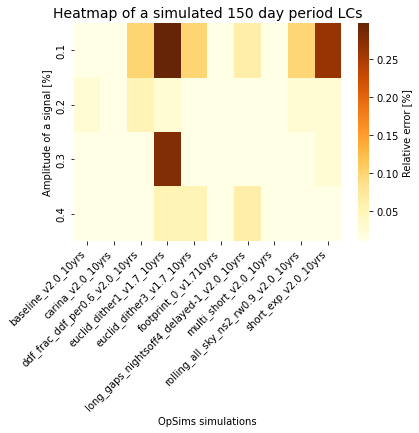

In [33]:

import matplotlib.pyplot as plt
import numpy as np
fig = plt.figure(figsize=(10,8))
z = column(test, 4)
z_min, z_max = -np.abs(z).max(), np.abs(z).max()
fig, ax = plt.subplots()
y = column(test, 3)
x = column(test, 0)
import seaborn as sns
import pandas as pd
# # ax = sns.heatmap(freq_1, linewidth=0)
# plt.contourf(freq_1) #reshape Z too!
df = pd.DataFrame.from_dict(np.array([x,y,z]).T)
df.columns = ['Amplitude of a signal [%]','OpSims simulations','diff']
df['diff'] = pd.to_numeric(df['diff'])
pivotted= df.pivot('Amplitude of a signal [%]','OpSims simulations','diff')
plt.title('Heatmap of a simulated 150 day period LCs', fontsize = 14) #
x_axis_labels = names # labels for x-axis
sns.heatmap(pivotted,cmap="YlOrBr",   xticklabels=x_axis_labels, cbar_kws={'label': 'Relative error [%]'})
plt.xticks(rotation=45, ha='right')
plt.savefig("150days_opsims_1.pdf",  dpi=100, format='pdf', bbox_inches = "tight")
plt.show()


## 10 days

In [ ]:
amplitudes =  np.array([0.4, 0.3, 0.2, 0.1]) 
result_opsims_10  = []
for A in amplitudes:
    for name in names:
        
        runName = name + '.db'
        opsim_db = maf.OpsimDatabase('/home/viktor/Desktop/LSST/MAF/data/' + runName)
        opsim_data = maf_cadence(opsim_db,"name", ddfs['ELAISS1'][0], ddfs['ELAISS1'][1])
        mjd_start = np.min(opsim_data)
        tt, yy = simple_mock_lc(time_interval = 10, num_points = len(opsim_data), 
                                        frequency = 10, amplitude = A, percent = 0, magnitude = 22, mjd_start = mjd_start)
    
        ttt, yyy = artificial_lc_sampled(opsim_data, tt, yy)
        fig_plot(tt, yy) 
        fig_plot(ttt, yyy) 
        plt.show()
        current = np.array([A, 10])
        fmax = 1/ 5 # (1. /400.) 0.011111
        fmin = 1/ 16 # (1. /1.)  0.00909
        df = (fmax - fmin) / 500
        params = [fmin, fmax, df, True] 
        print(params)
        time_division = 80
        wwt_result, params = wwt(ttt, yyy, time_division, params)
        peaks, result, osex, hh1arr1  = wwt_find_freq(wwt_result, time_division)
        print(result)
        current = np.append(current, result)


        result_opsims_10.insert(len(result_opsims), current)
    
    
            

In [23]:
print(len(result_opsims_10))
np.savetxt("data_10days_opsim.csv", result_opsims_10, delimiter=",")


40


In [36]:
import matplotlib.pyplot as plt
import pandas as pd
tmp2 = result_opsims_10
br = 0
test2 = []
for i in result_opsims_10:
    i = np.append(i, [int(br%10)])
    i = np.append(i, [np.abs(i[2] - 150)/10])
    test2.insert(len(test2), i)
    br = br + 1
test2
print(br)
print(column(test2,4))

40
[0.933993399339934, 0.9330823923044752, 0.933993399339934, 0.9330823923044752, 0.9330823923044752, 0.9330823923044752, 0.933993399339934, 0.9330823923044752, 0.9330823923044752, 0.933993399339934, 0.933993399339934, 0.9330823923044752, 0.933993399339934, 0.9330823923044752, 0.9321458863443597, 0.9330823923044752, 0.9330823923044752, 0.9330823923044752, 0.9330823923044752, 0.9330823923044752, 0.9330823923044752, 0.9330823923044752, 0.963669391462307, 0.933993399339934, 0.9330823923044752, 0.9321458863443597, 0.9330823923044752, 0.9321458863443597, 0.933993399339934, 0.933993399339934, 0.9642058165548099, 0.9357429718875502, 0.9348799348799349, 0.9330823923044752, 0.9348799348799349, 0.963669391462307, 0.9330823923044752, 0.9330823923044752, 0.9348799348799349, 0.9451867077766358]


<Figure size 720x576 with 0 Axes>

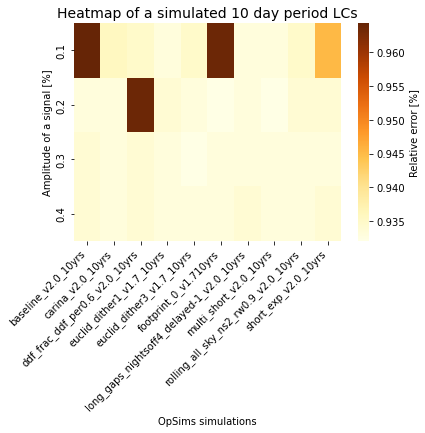

In [37]:

import matplotlib.pyplot as plt
import numpy as np
fig = plt.figure(figsize=(10,8))
z = column(test2, 4)
z_min, z_max = -np.abs(z).max(), np.abs(z).max()
fig, ax = plt.subplots()
y = column(test2, 3)
x = column(test2, 0)
import seaborn as sns
import pandas as pd
# # ax = sns.heatmap(freq_1, linewidth=0)
# plt.contourf(freq_1) #reshape Z too!
df = pd.DataFrame.from_dict(np.array([x,y,z]).T)
df.columns = ['Amplitude of a signal [%]','OpSims simulations','diff']
df['diff'] = pd.to_numeric(df['diff'])
pivotted= df.pivot('Amplitude of a signal [%]','OpSims simulations','diff')
plt.title('Heatmap of a simulated 10 day period LCs', fontsize = 14) #
x_axis_labels = names # labels for x-axis
sns.heatmap(pivotted,cmap="YlOrBr",   xticklabels=x_axis_labels, cbar_kws={'label': 'Relative error [%]'})
plt.xticks(rotation=45, ha='right')
plt.savefig("10days_opsims.pdf",  dpi=100, format='pdf', bbox_inches = "tight")
plt.show()


### Testing WWZ with custom generated light-curves with defined parameters

In [25]:
r
result2 = []
result2_opsim = []

[0.0025, 0.1, 0.0009750000000000001, True]
[0.0025, 0.1, 0.000195, True]


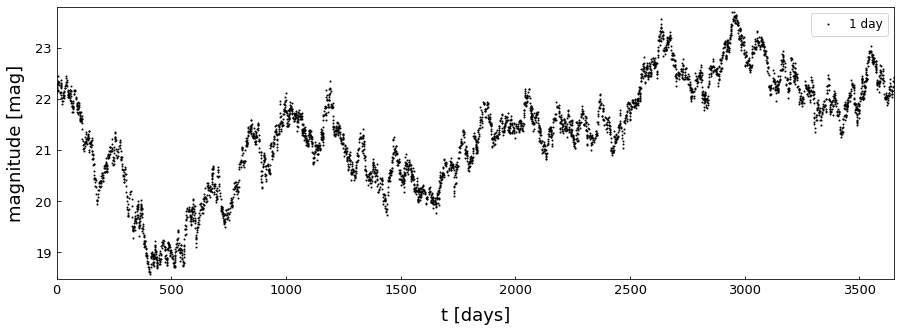

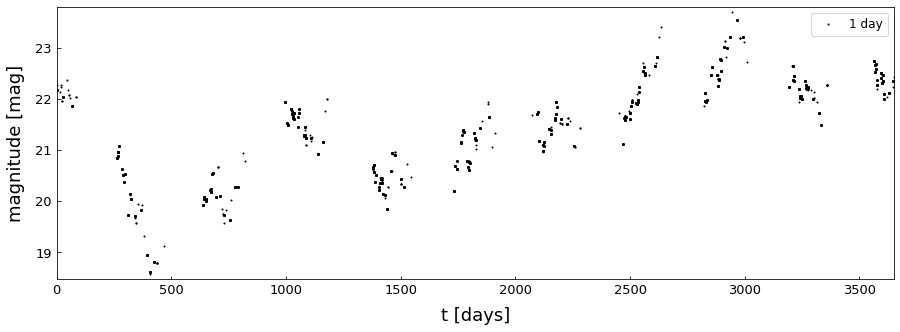

*** Starting Weighted Wavelet Z-transform ***

Pseudo sample frequency (median) is  1.694
largest tau window is  46.198
190.06 seconds has passed to complete Weighted Wavelet Z-transform 

*** Starting Weighted Wavelet Z-transform ***

Pseudo sample frequency (median) is  2400.0
largest tau window is  46.201
167.24 seconds has passed to complete Weighted Wavelet Z-transform 

[0.0125, 0.008333333333333333, -5.208333333333334e-06, True]
[0.0025, 0.1, 0.000195, True]


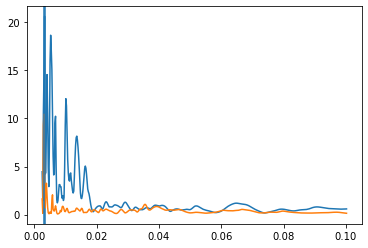

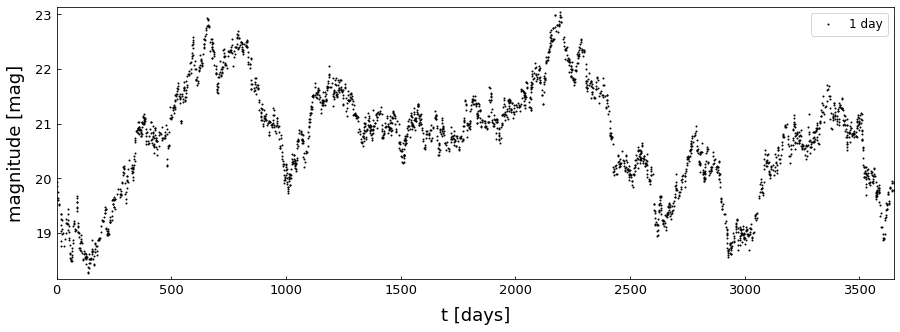

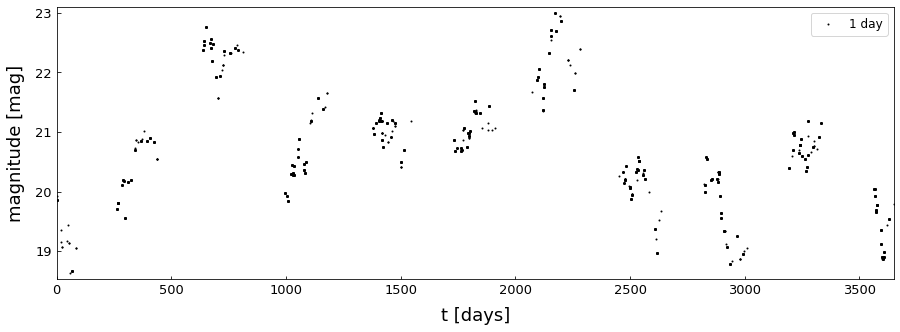

*** Starting Weighted Wavelet Z-transform ***

Pseudo sample frequency (median) is  1.02
largest tau window is  46.198
116.51 seconds has passed to complete Weighted Wavelet Z-transform 

*** Starting Weighted Wavelet Z-transform ***

Pseudo sample frequency (median) is  2400.0
largest tau window is  46.201
148.97 seconds has passed to complete Weighted Wavelet Z-transform 

[0.0125, 0.008333333333333333, -5.208333333333334e-06, True]
[0.0025, 0.1, 0.000195, True]


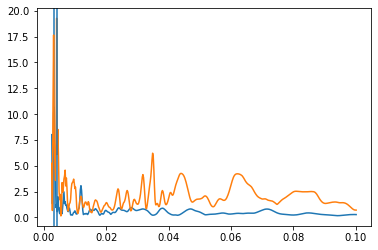

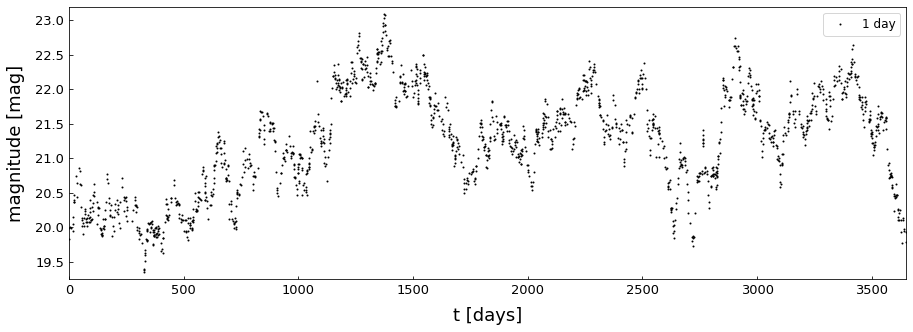

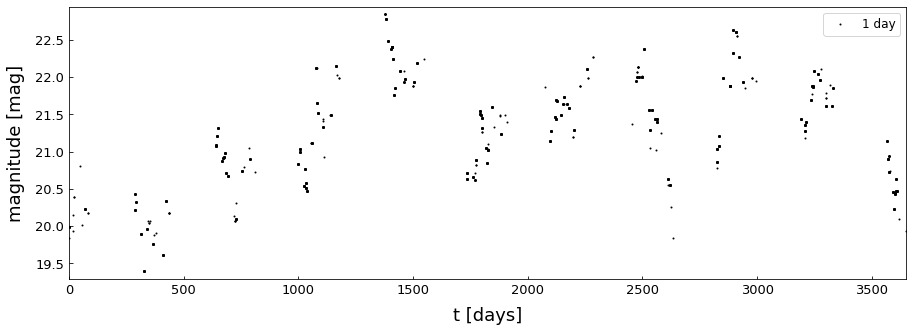

*** Starting Weighted Wavelet Z-transform ***

Pseudo sample frequency (median) is  0.651
largest tau window is  46.197
78.59 seconds has passed to complete Weighted Wavelet Z-transform 

*** Starting Weighted Wavelet Z-transform ***

Pseudo sample frequency (median) is  2400.0
largest tau window is  46.201
119.69 seconds has passed to complete Weighted Wavelet Z-transform 

[0.0125, 0.008333333333333333, -5.208333333333334e-06, True]
[0.0025, 0.1, 0.000195, True]


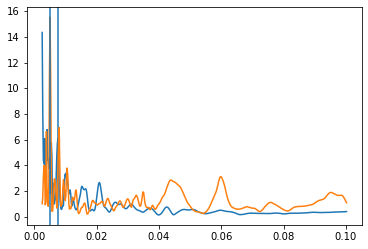

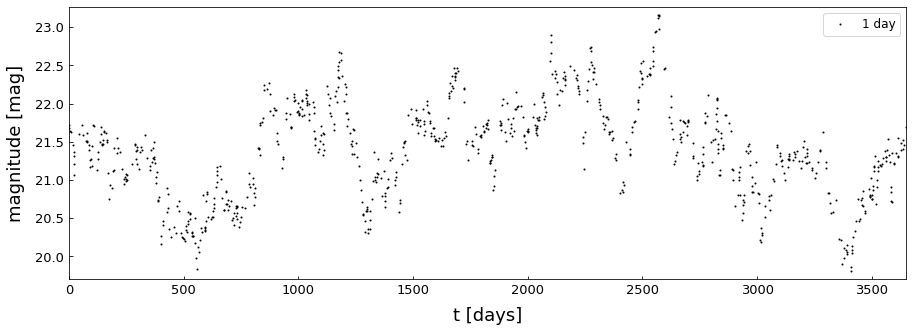

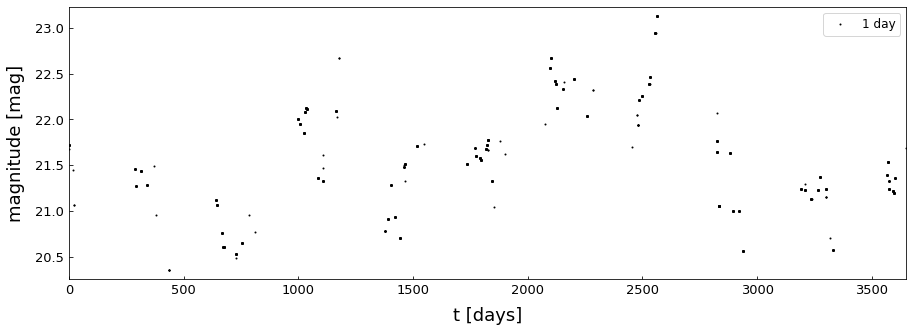

*** Starting Weighted Wavelet Z-transform ***

Pseudo sample frequency (median) is  0.322
largest tau window is  46.197
47.09 seconds has passed to complete Weighted Wavelet Z-transform 

*** Starting Weighted Wavelet Z-transform ***

Pseudo sample frequency (median) is  2400.0
largest tau window is  46.201
79.54 seconds has passed to complete Weighted Wavelet Z-transform 

[0.0125, 0.008333333333333333, -5.208333333333334e-06, True]
[0.0025, 0.1, 0.000195, True]


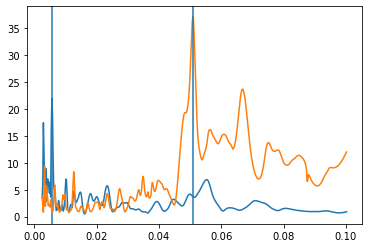

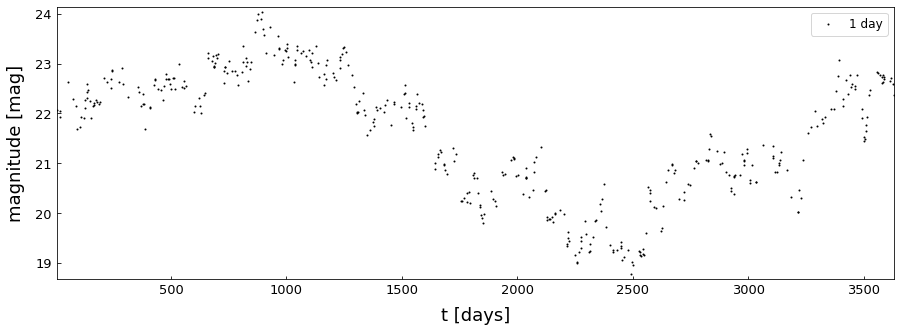

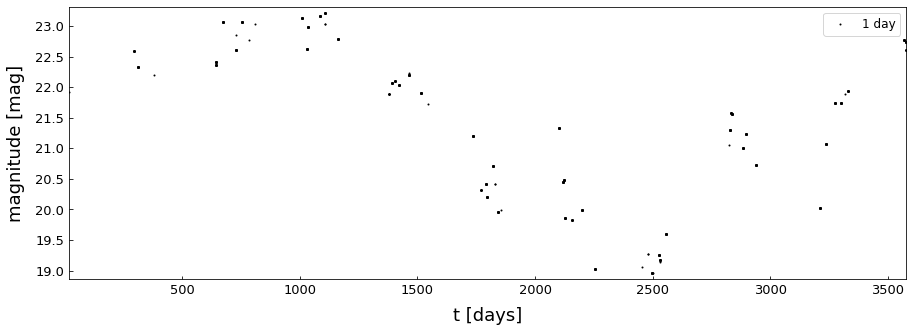

*** Starting Weighted Wavelet Z-transform ***

Pseudo sample frequency (median) is  0.156
largest tau window is  45.862
24.07 seconds has passed to complete Weighted Wavelet Z-transform 

*** Starting Weighted Wavelet Z-transform ***

Pseudo sample frequency (median) is  2400.0
largest tau window is  45.04
54.7 seconds has passed to complete Weighted Wavelet Z-transform 

[0.0125, 0.008333333333333333, -5.208333333333334e-06, True]
[0.0025, 0.1, 0.000195, True]


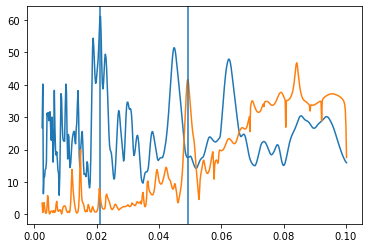

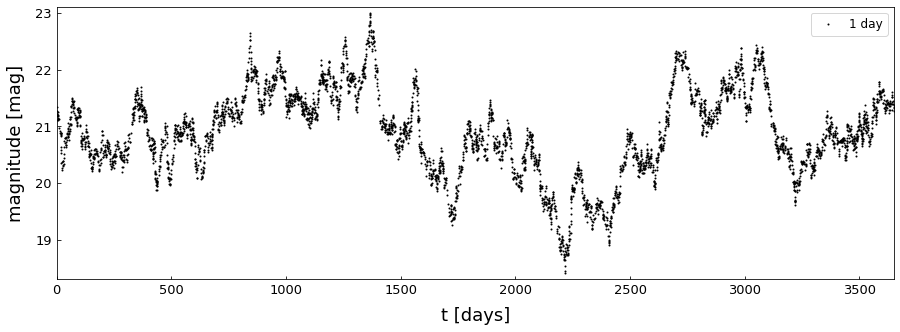

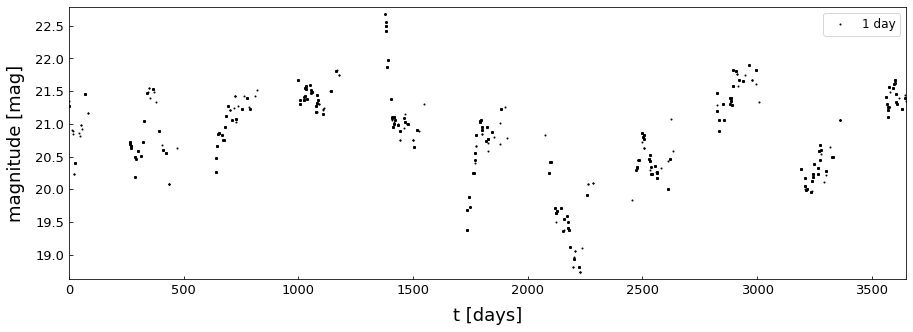

*** Starting Weighted Wavelet Z-transform ***

Pseudo sample frequency (median) is  1.694
largest tau window is  46.198
171.83 seconds has passed to complete Weighted Wavelet Z-transform 

*** Starting Weighted Wavelet Z-transform ***

Pseudo sample frequency (median) is  2400.0
largest tau window is  46.201
144.13 seconds has passed to complete Weighted Wavelet Z-transform 

[0.0125, 0.008333333333333333, -5.208333333333334e-06, True]
[0.0025, 0.1, 0.000195, True]


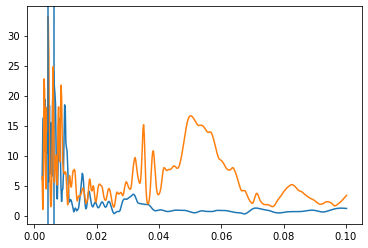

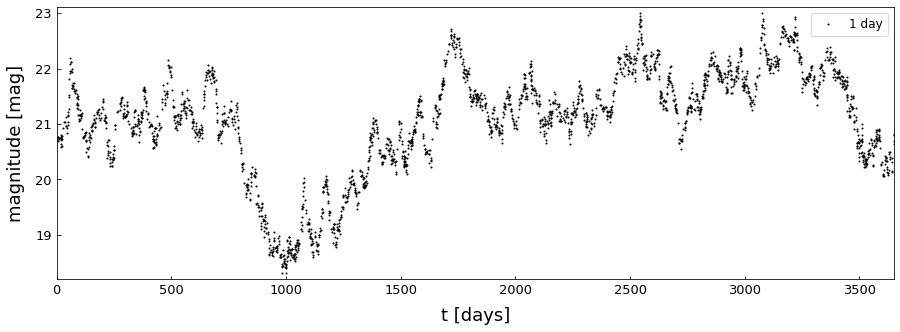

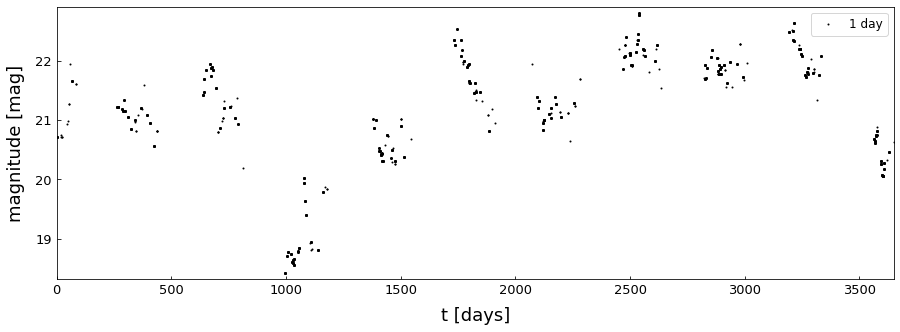

*** Starting Weighted Wavelet Z-transform ***

Pseudo sample frequency (median) is  1.02
largest tau window is  46.198
110.18 seconds has passed to complete Weighted Wavelet Z-transform 

*** Starting Weighted Wavelet Z-transform ***

Pseudo sample frequency (median) is  2400.0
largest tau window is  46.201
149.57 seconds has passed to complete Weighted Wavelet Z-transform 

[0.0125, 0.008333333333333333, -5.208333333333334e-06, True]
[0.0025, 0.1, 0.000195, True]


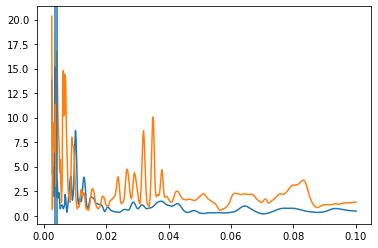

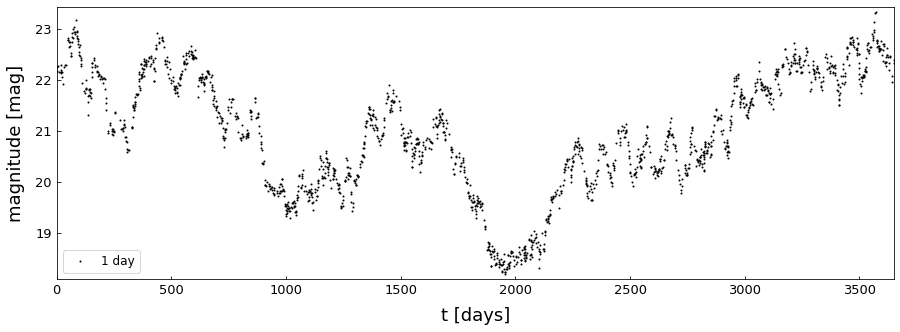

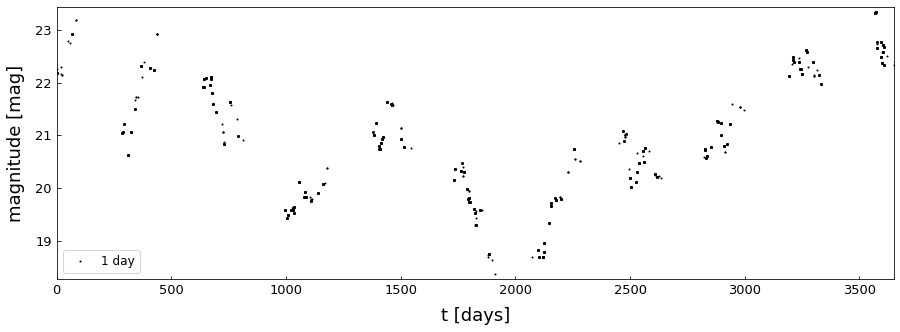

*** Starting Weighted Wavelet Z-transform ***

Pseudo sample frequency (median) is  0.651
largest tau window is  46.197
74.9 seconds has passed to complete Weighted Wavelet Z-transform 

*** Starting Weighted Wavelet Z-transform ***

Pseudo sample frequency (median) is  2400.0
largest tau window is  46.201
117.11 seconds has passed to complete Weighted Wavelet Z-transform 

[0.0125, 0.008333333333333333, -5.208333333333334e-06, True]
[0.0025, 0.1, 0.000195, True]


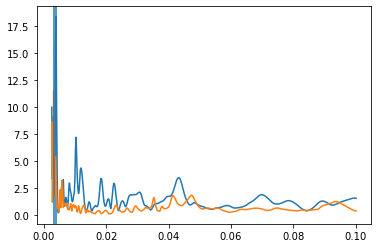

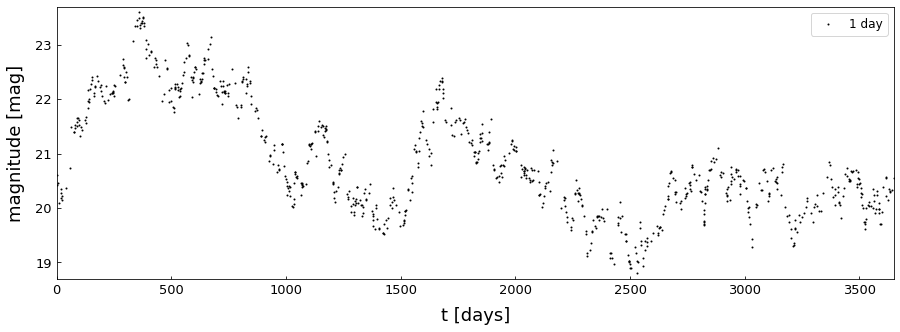

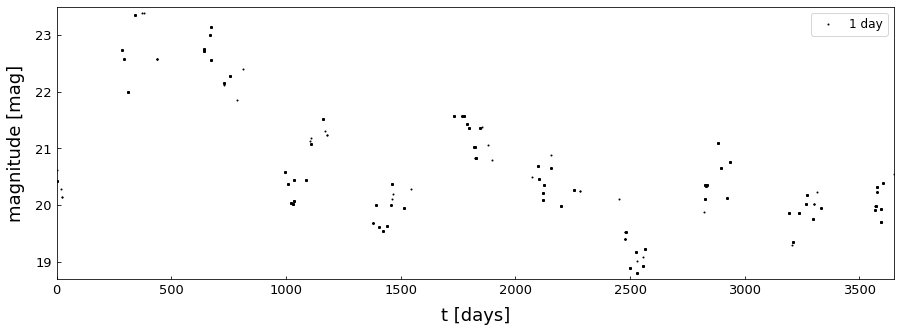

*** Starting Weighted Wavelet Z-transform ***

Pseudo sample frequency (median) is  0.322
largest tau window is  46.197
39.3 seconds has passed to complete Weighted Wavelet Z-transform 

*** Starting Weighted Wavelet Z-transform ***

Pseudo sample frequency (median) is  2400.0
largest tau window is  46.201
67.29 seconds has passed to complete Weighted Wavelet Z-transform 

[0.0125, 0.008333333333333333, -5.208333333333334e-06, True]
[0.0025, 0.1, 0.000195, True]


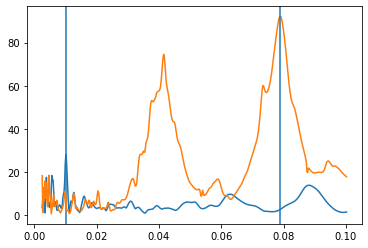

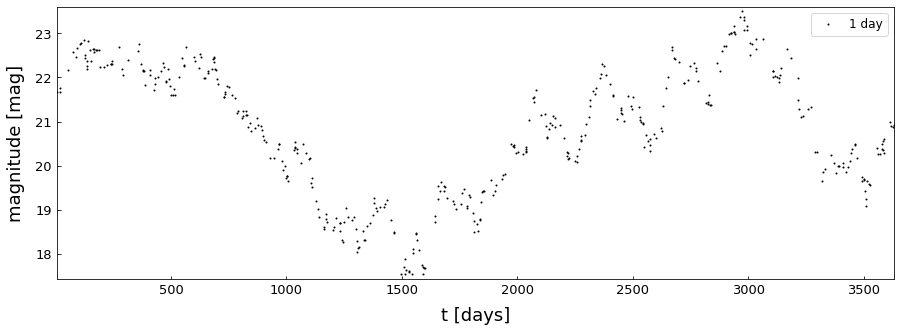

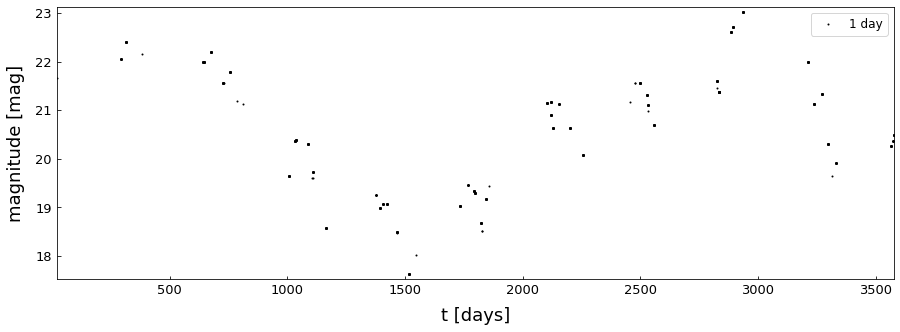

*** Starting Weighted Wavelet Z-transform ***

Pseudo sample frequency (median) is  0.156
largest tau window is  45.862
20.19 seconds has passed to complete Weighted Wavelet Z-transform 

*** Starting Weighted Wavelet Z-transform ***

Pseudo sample frequency (median) is  2400.0
largest tau window is  45.04
41.73 seconds has passed to complete Weighted Wavelet Z-transform 

[0.0125, 0.008333333333333333, -5.208333333333334e-06, True]
[0.0025, 0.1, 0.000195, True]


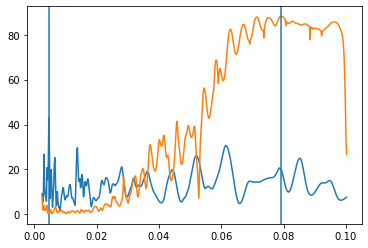

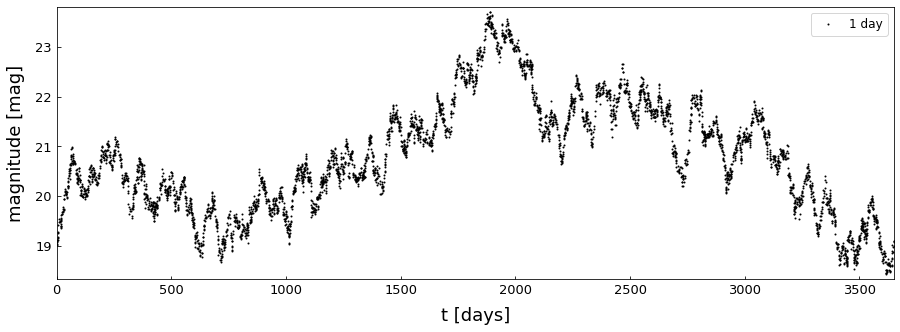

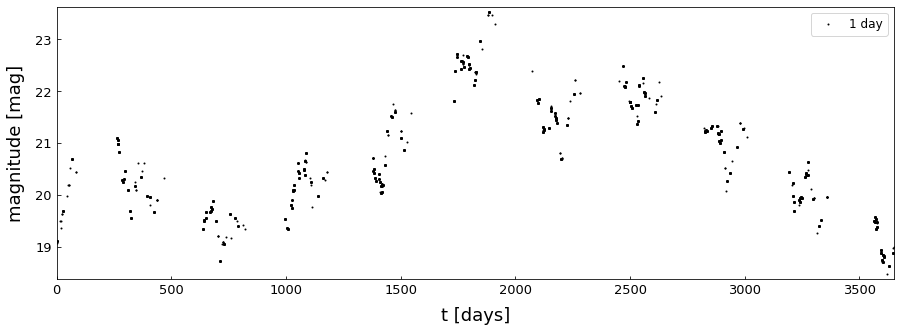

*** Starting Weighted Wavelet Z-transform ***

Pseudo sample frequency (median) is  1.694
largest tau window is  46.198
187.96 seconds has passed to complete Weighted Wavelet Z-transform 

*** Starting Weighted Wavelet Z-transform ***

Pseudo sample frequency (median) is  2400.0
largest tau window is  46.201
168.96 seconds has passed to complete Weighted Wavelet Z-transform 

[0.0125, 0.008333333333333333, -5.208333333333334e-06, True]
[0.0025, 0.1, 0.000195, True]


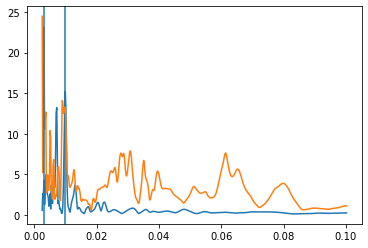

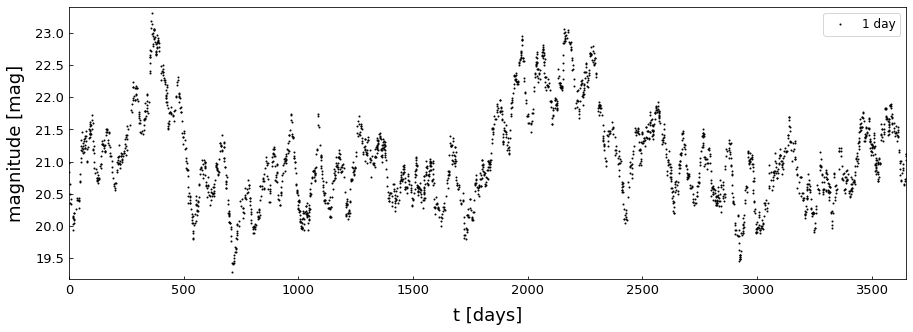

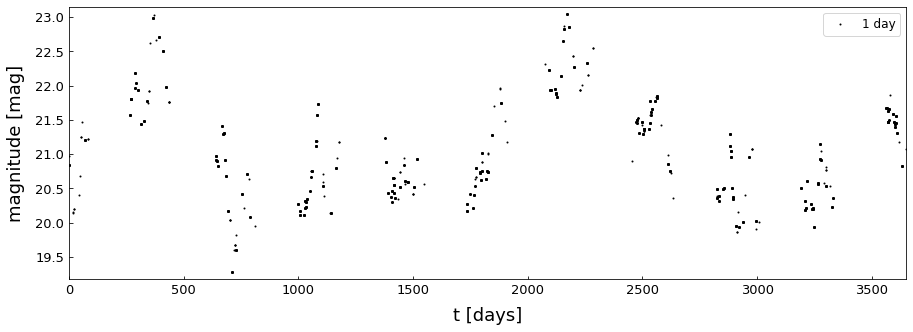

*** Starting Weighted Wavelet Z-transform ***

Pseudo sample frequency (median) is  1.02
largest tau window is  46.198
115.77 seconds has passed to complete Weighted Wavelet Z-transform 

*** Starting Weighted Wavelet Z-transform ***

Pseudo sample frequency (median) is  2400.0
largest tau window is  46.201
148.51 seconds has passed to complete Weighted Wavelet Z-transform 

[0.0125, 0.008333333333333333, -5.208333333333334e-06, True]
[0.0025, 0.1, 0.000195, True]


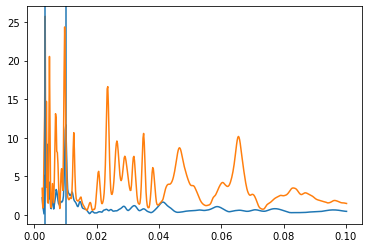

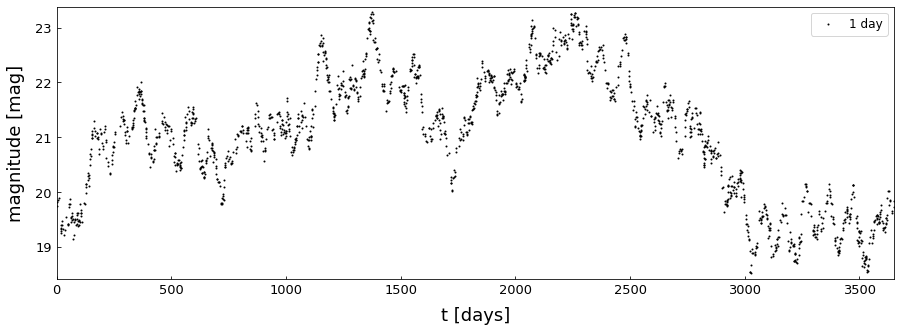

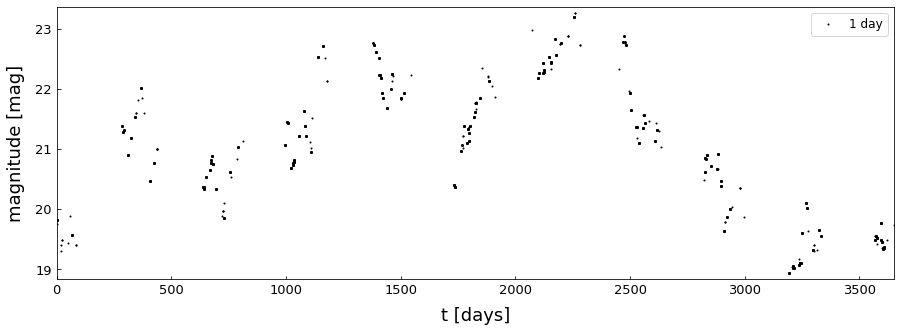

*** Starting Weighted Wavelet Z-transform ***

Pseudo sample frequency (median) is  0.651
largest tau window is  46.197
77.26 seconds has passed to complete Weighted Wavelet Z-transform 

*** Starting Weighted Wavelet Z-transform ***

Pseudo sample frequency (median) is  2400.0
largest tau window is  46.201
117.89 seconds has passed to complete Weighted Wavelet Z-transform 

[0.0125, 0.008333333333333333, -5.208333333333334e-06, True]
[0.0025, 0.1, 0.000195, True]


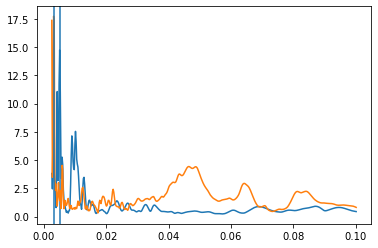

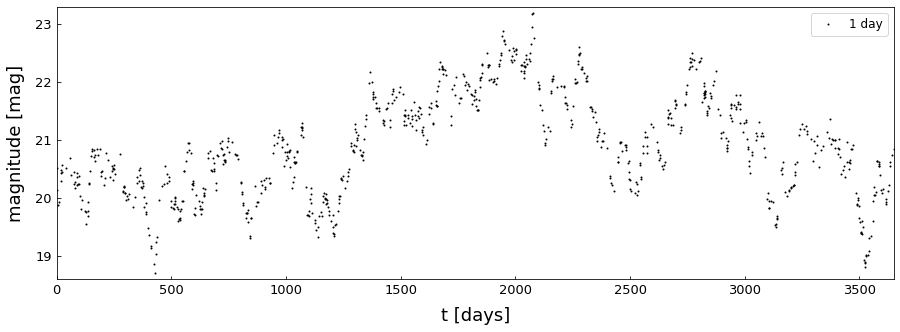

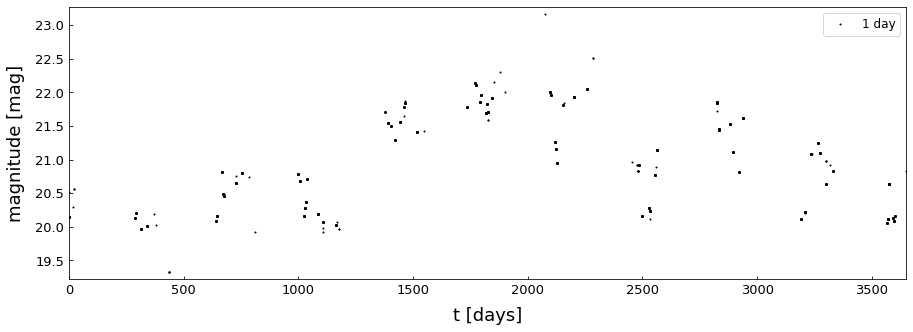

*** Starting Weighted Wavelet Z-transform ***

Pseudo sample frequency (median) is  0.322
largest tau window is  46.197
39.14 seconds has passed to complete Weighted Wavelet Z-transform 

*** Starting Weighted Wavelet Z-transform ***

Pseudo sample frequency (median) is  2400.0
largest tau window is  46.201
66.25 seconds has passed to complete Weighted Wavelet Z-transform 

[0.0125, 0.008333333333333333, -5.208333333333334e-06, True]
[0.0025, 0.1, 0.000195, True]


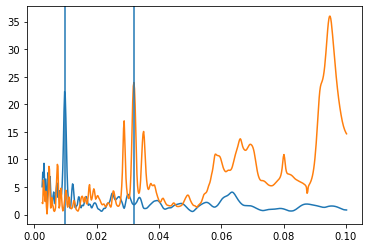

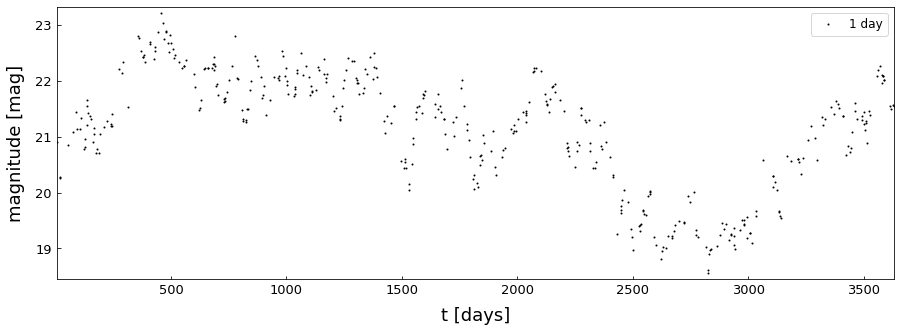

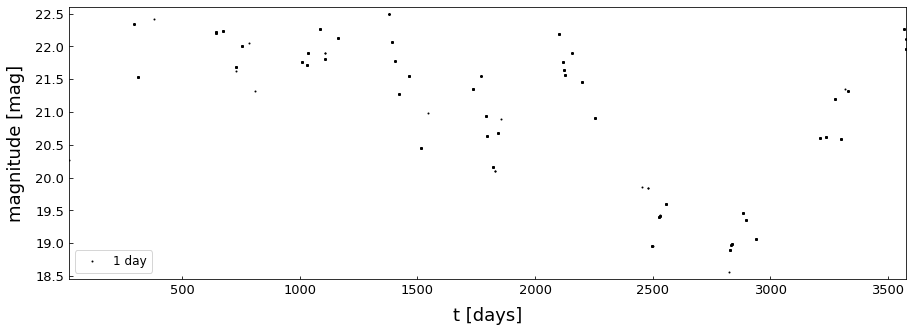

*** Starting Weighted Wavelet Z-transform ***

Pseudo sample frequency (median) is  0.156
largest tau window is  45.862
20.16 seconds has passed to complete Weighted Wavelet Z-transform 

*** Starting Weighted Wavelet Z-transform ***

Pseudo sample frequency (median) is  2400.0
largest tau window is  45.04
45.62 seconds has passed to complete Weighted Wavelet Z-transform 

[0.0125, 0.008333333333333333, -5.208333333333334e-06, True]
[0.0025, 0.1, 0.000195, True]


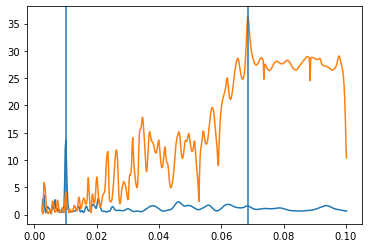

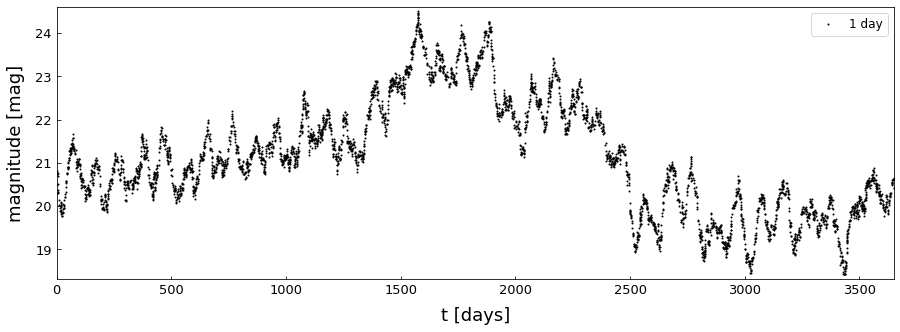

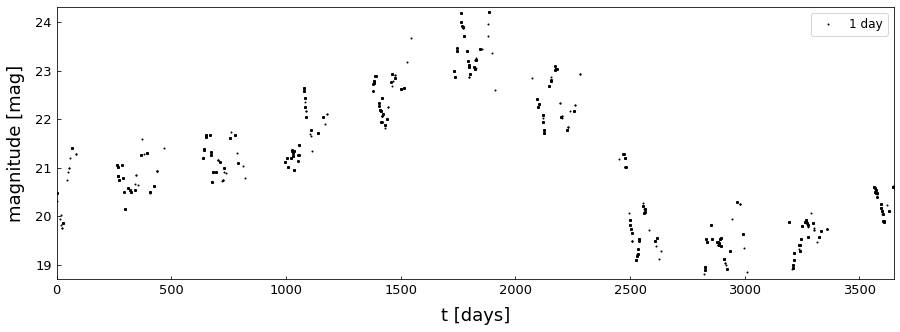

*** Starting Weighted Wavelet Z-transform ***

Pseudo sample frequency (median) is  1.694
largest tau window is  46.198
191.61 seconds has passed to complete Weighted Wavelet Z-transform 

*** Starting Weighted Wavelet Z-transform ***

Pseudo sample frequency (median) is  2400.0
largest tau window is  46.201
167.25 seconds has passed to complete Weighted Wavelet Z-transform 

[0.0125, 0.008333333333333333, -5.208333333333334e-06, True]
[0.0025, 0.1, 0.000195, True]


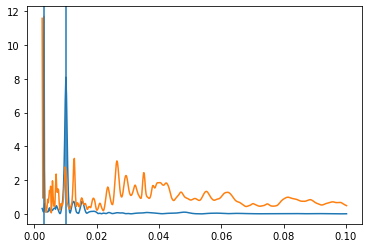

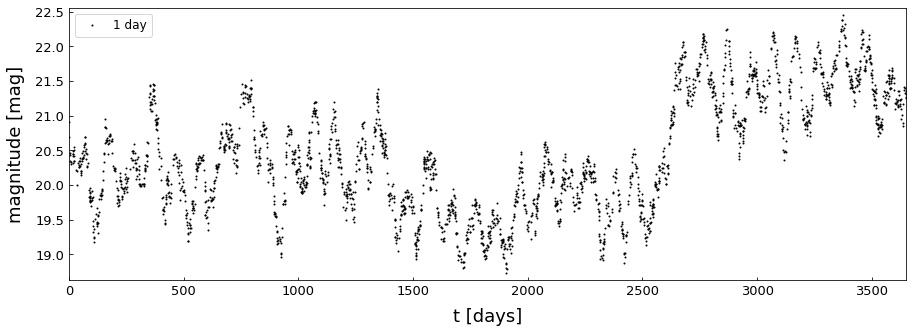

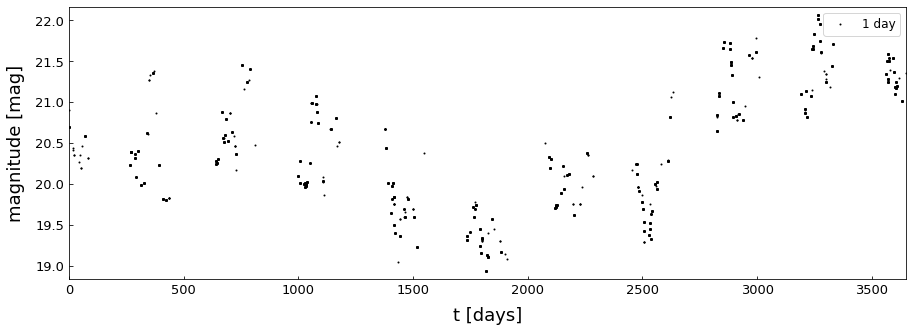

*** Starting Weighted Wavelet Z-transform ***

Pseudo sample frequency (median) is  1.02
largest tau window is  46.198
116.98 seconds has passed to complete Weighted Wavelet Z-transform 

*** Starting Weighted Wavelet Z-transform ***

Pseudo sample frequency (median) is  2400.0
largest tau window is  46.201
148.24 seconds has passed to complete Weighted Wavelet Z-transform 

[0.0125, 0.008333333333333333, -5.208333333333334e-06, True]
[0.0025, 0.1, 0.000195, True]


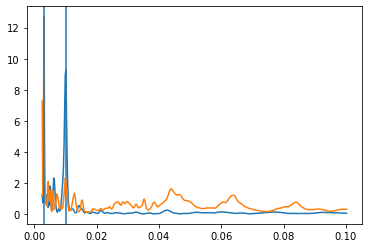

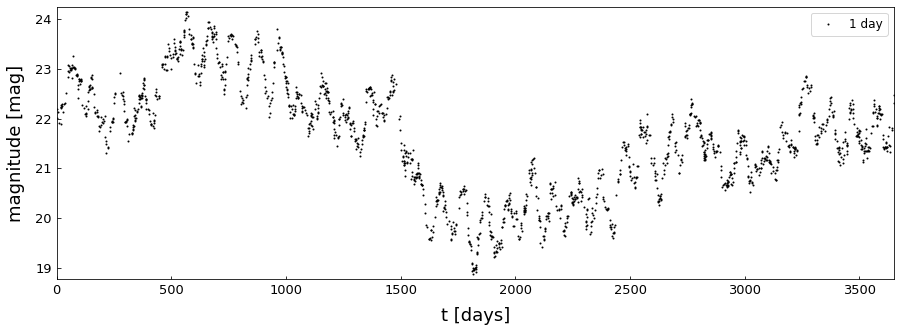

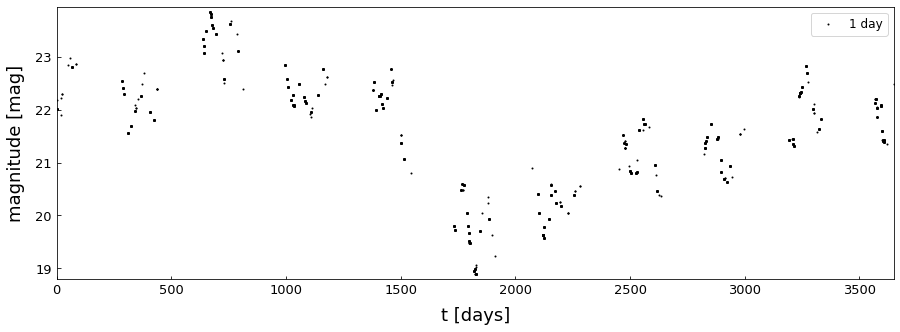

*** Starting Weighted Wavelet Z-transform ***

Pseudo sample frequency (median) is  0.651
largest tau window is  46.197
77.45 seconds has passed to complete Weighted Wavelet Z-transform 

*** Starting Weighted Wavelet Z-transform ***

Pseudo sample frequency (median) is  2400.0
largest tau window is  46.201
118.68 seconds has passed to complete Weighted Wavelet Z-transform 

[0.0125, 0.008333333333333333, -5.208333333333334e-06, True]
[0.0025, 0.1, 0.000195, True]


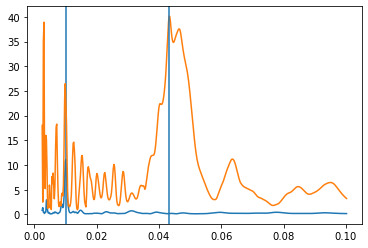

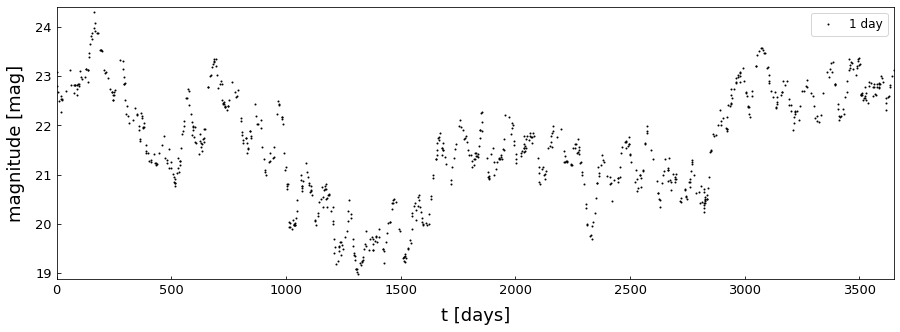

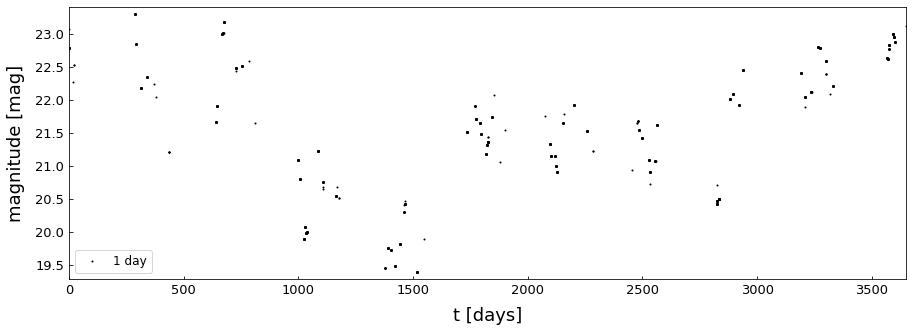

*** Starting Weighted Wavelet Z-transform ***

Pseudo sample frequency (median) is  0.322
largest tau window is  46.197
39.51 seconds has passed to complete Weighted Wavelet Z-transform 

*** Starting Weighted Wavelet Z-transform ***

Pseudo sample frequency (median) is  2400.0
largest tau window is  46.201
65.88 seconds has passed to complete Weighted Wavelet Z-transform 

[0.0125, 0.008333333333333333, -5.208333333333334e-06, True]
[0.0025, 0.1, 0.000195, True]


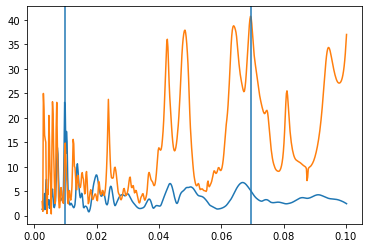

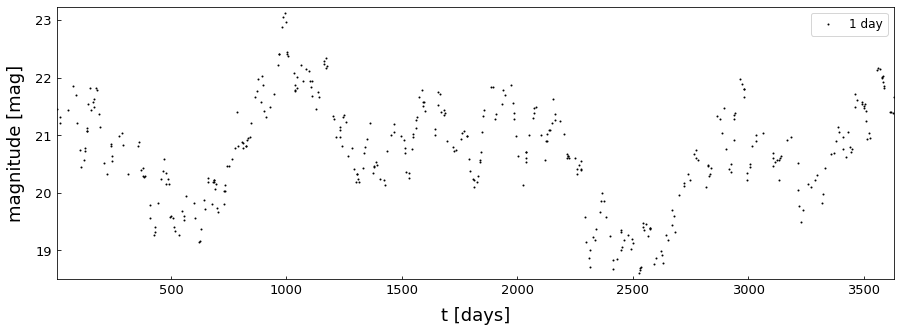

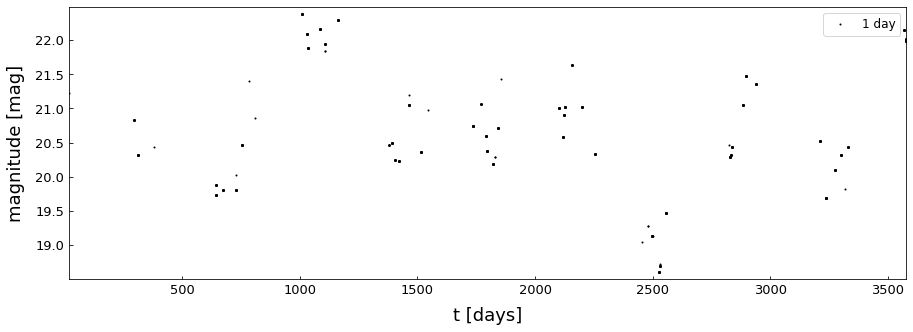

*** Starting Weighted Wavelet Z-transform ***

Pseudo sample frequency (median) is  0.156
largest tau window is  45.862
19.9 seconds has passed to complete Weighted Wavelet Z-transform 

*** Starting Weighted Wavelet Z-transform ***

Pseudo sample frequency (median) is  2400.0
largest tau window is  45.04
45.86 seconds has passed to complete Weighted Wavelet Z-transform 



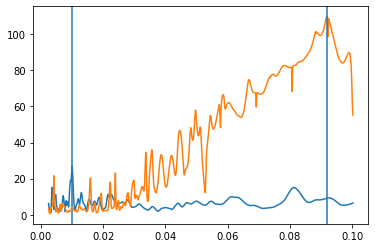

In [27]:
fmax = 1/ 10 # (1. /400.) 0.011111
fmin = 1/ 400 # (1. /1.)  0.00909
df = (fmax - fmin) / 500


for A in amplitudes: 
    for frequency in freq:
        for percentage in percent:
            print(params)
            params = [fmin, fmax, df, True] 
            print(params)
            current = np.array([A, frequency, percentage])
            tt, yy = simple_mock_lc(time_interval = time_interval, num_points = len_os, 
                                    frequency = frequency, amplitude = A, percent = percentage, magnitude = magnitude, mjd_start = mjd_start)
            ttt, yyy = artificial_lc_sampled(opsim_data, tt, yy)
            fig_plot(tt, yy) 
            fig_plot(ttt, yyy) 
            plt.show()
            
            # WWZ on simulated LC
            time_division = 80
            wwt_result, params = wwt(tt, yy, time_division, params)
            peaks, result, osex, hh1arr1  = wwt_find_freq(wwt_result, time_division)

            current = np.append(current, result)
            current = np.append(current, np.abs(result-frequency)/frequency)
            
            
            params = [fmin, fmax, df, True] 
            # WWZ on OpSim
            time_division = 80
            wwt_result, params = wwt(ttt, yyy, time_division, params)
            peaks, result, osex, hh1arr1  = wwt_find_freq(wwt_result, time_division)

            current = np.append(current, result)
            current = np.append(current, np.abs(result-frequency)/frequency)
            
            result2.insert(len(result2), current)
            
            
            

[0.0125, 0.008333333333333333, -5.208333333333334e-06, True]
[0.0025, 0.1, 0.000195, True]


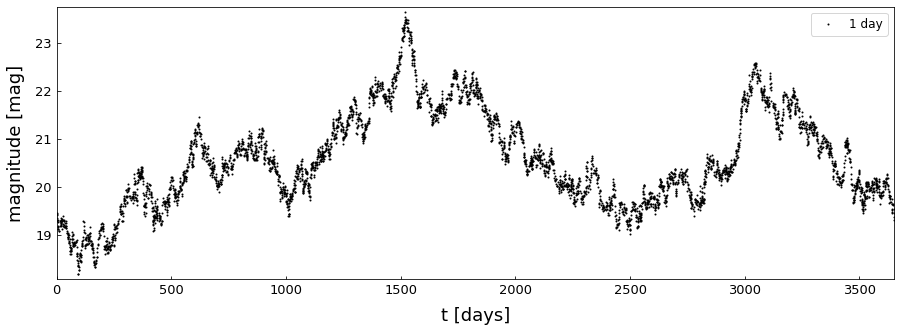

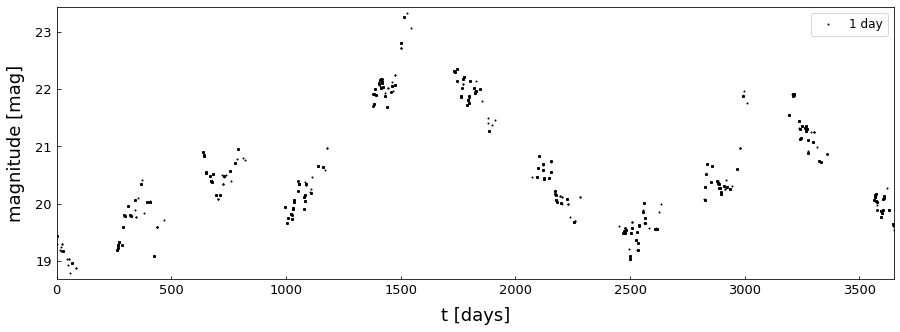

*** Starting Weighted Wavelet Z-transform ***

Pseudo sample frequency (median) is  1.694
largest tau window is  46.198
191.4 seconds has passed to complete Weighted Wavelet Z-transform 

*** Starting Weighted Wavelet Z-transform ***

Pseudo sample frequency (median) is  2400.0
largest tau window is  46.201
166.95 seconds has passed to complete Weighted Wavelet Z-transform 

[0.0125, 0.008333333333333333, -5.208333333333334e-06, True]
[0.0025, 0.1, 0.000195, True]


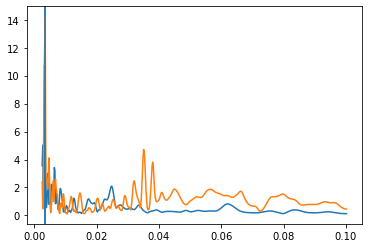

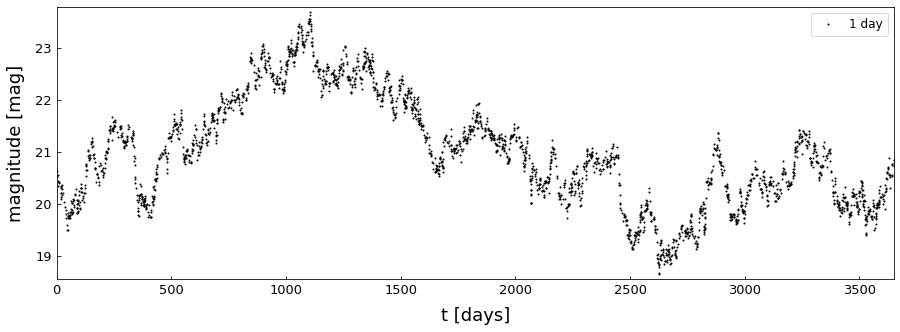

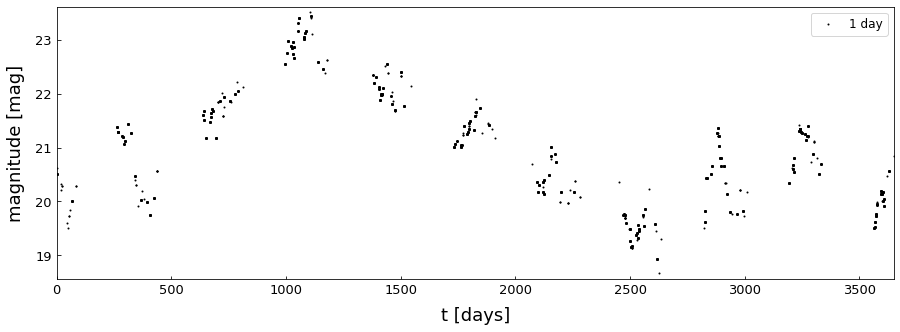

*** Starting Weighted Wavelet Z-transform ***

Pseudo sample frequency (median) is  1.02
largest tau window is  46.198
116.26 seconds has passed to complete Weighted Wavelet Z-transform 

*** Starting Weighted Wavelet Z-transform ***

Pseudo sample frequency (median) is  2400.0
largest tau window is  46.201
148.36 seconds has passed to complete Weighted Wavelet Z-transform 

[0.0125, 0.008333333333333333, -5.208333333333334e-06, True]
[0.0025, 0.1, 0.000195, True]


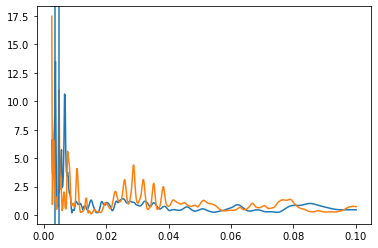

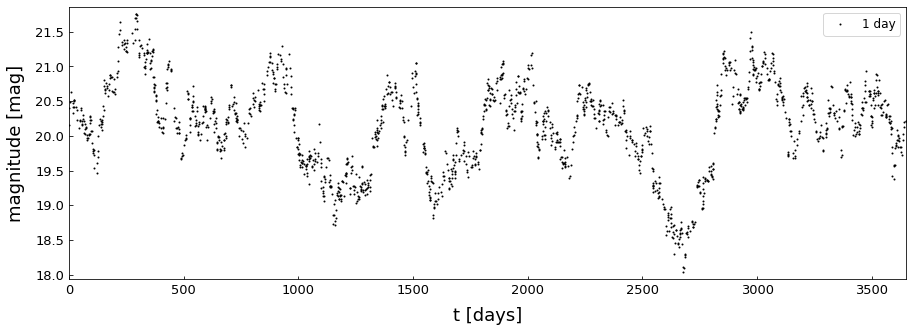

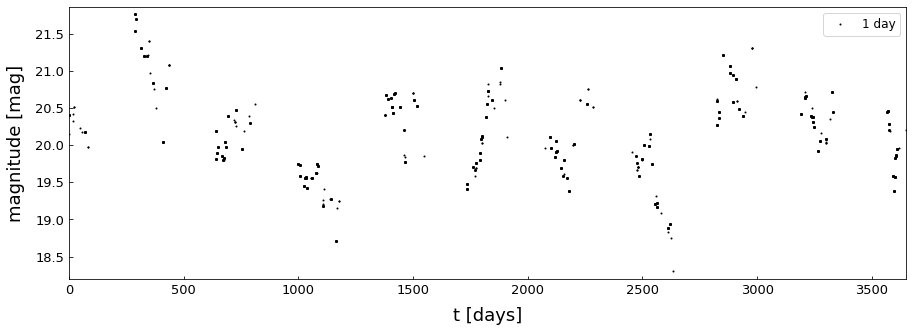

*** Starting Weighted Wavelet Z-transform ***

Pseudo sample frequency (median) is  0.651
largest tau window is  46.197
78.35 seconds has passed to complete Weighted Wavelet Z-transform 

*** Starting Weighted Wavelet Z-transform ***

Pseudo sample frequency (median) is  2400.0
largest tau window is  46.201
118.34 seconds has passed to complete Weighted Wavelet Z-transform 

[0.0125, 0.008333333333333333, -5.208333333333334e-06, True]
[0.0025, 0.1, 0.000195, True]


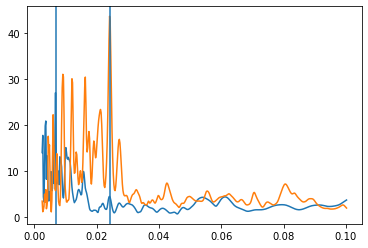

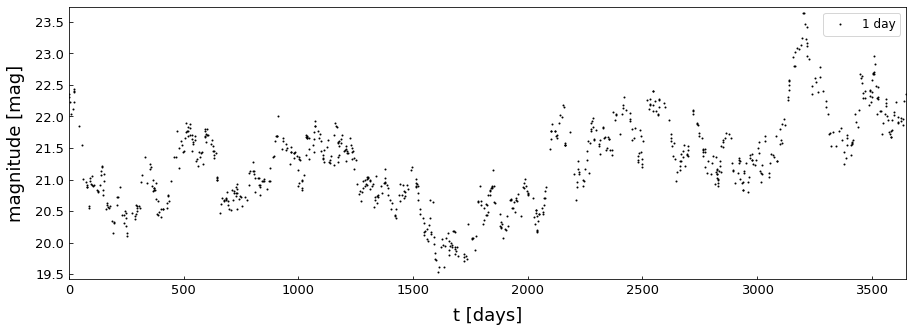

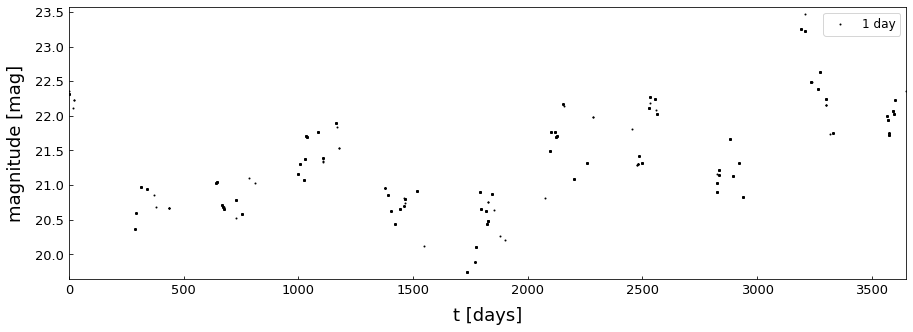

*** Starting Weighted Wavelet Z-transform ***

Pseudo sample frequency (median) is  0.322
largest tau window is  46.197
39.64 seconds has passed to complete Weighted Wavelet Z-transform 

*** Starting Weighted Wavelet Z-transform ***

Pseudo sample frequency (median) is  2400.0
largest tau window is  46.201
67.07 seconds has passed to complete Weighted Wavelet Z-transform 

[0.0125, 0.008333333333333333, -5.208333333333334e-06, True]
[0.0025, 0.1, 0.000195, True]


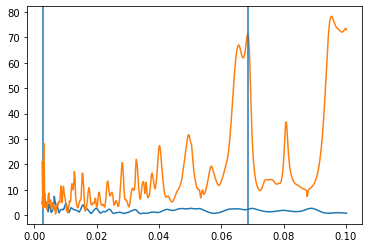

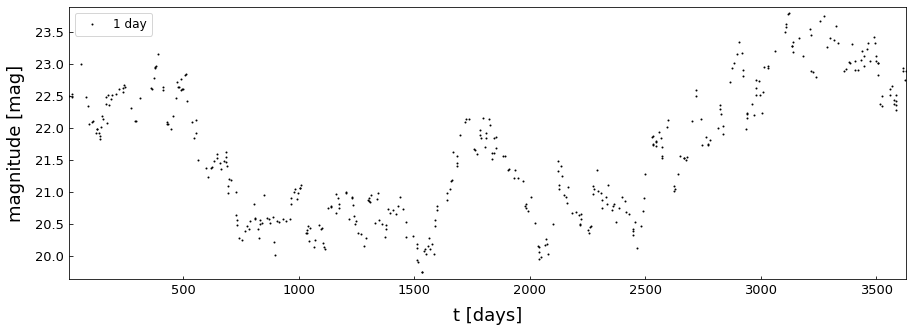

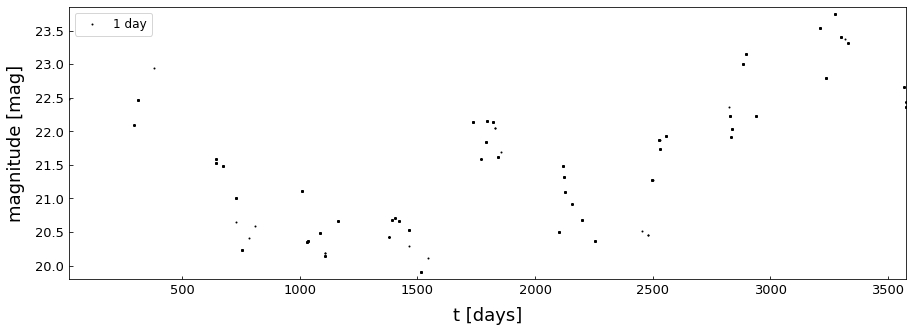

*** Starting Weighted Wavelet Z-transform ***

Pseudo sample frequency (median) is  0.156
largest tau window is  45.862
20.01 seconds has passed to complete Weighted Wavelet Z-transform 

*** Starting Weighted Wavelet Z-transform ***

Pseudo sample frequency (median) is  2400.0
largest tau window is  45.04
45.12 seconds has passed to complete Weighted Wavelet Z-transform 

[0.0125, 0.008333333333333333, -5.208333333333334e-06, True]
[0.0025, 0.1, 0.000195, True]


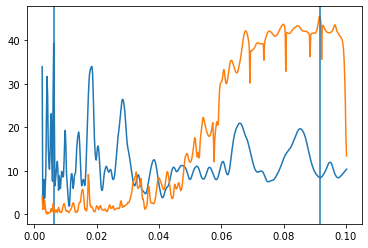

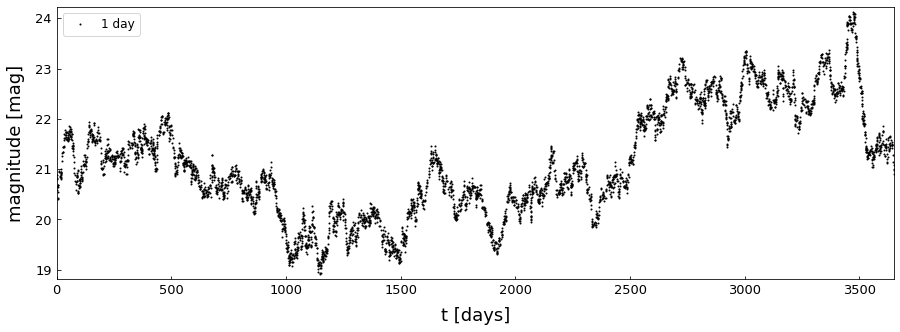

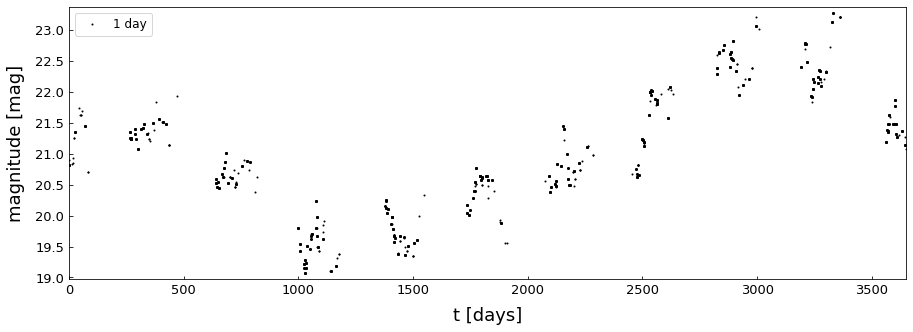

*** Starting Weighted Wavelet Z-transform ***

Pseudo sample frequency (median) is  1.694
largest tau window is  46.198
192.18 seconds has passed to complete Weighted Wavelet Z-transform 

*** Starting Weighted Wavelet Z-transform ***

Pseudo sample frequency (median) is  2400.0
largest tau window is  46.201
166.61 seconds has passed to complete Weighted Wavelet Z-transform 

[0.0125, 0.008333333333333333, -5.208333333333334e-06, True]
[0.0025, 0.1, 0.000195, True]


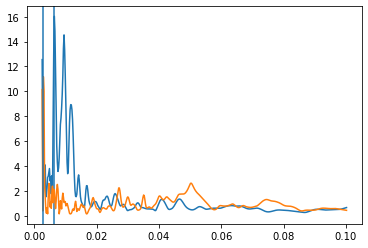

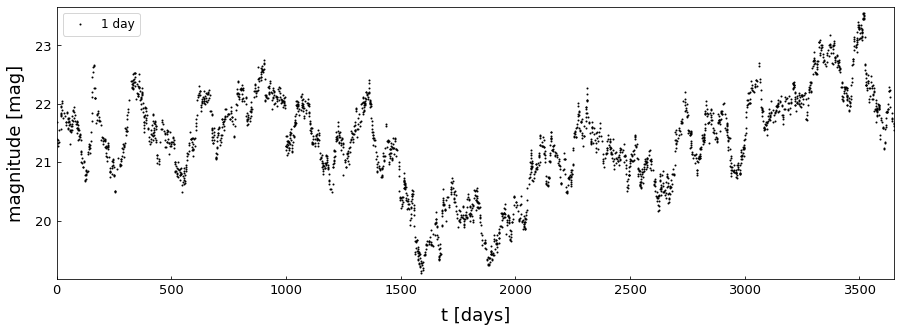

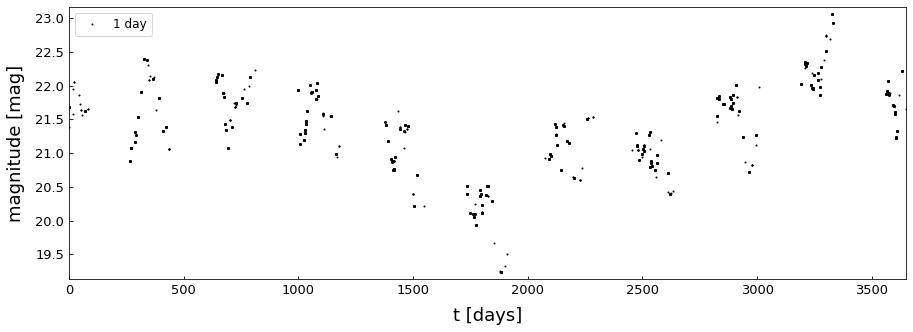

*** Starting Weighted Wavelet Z-transform ***

Pseudo sample frequency (median) is  1.02
largest tau window is  46.198
115.4 seconds has passed to complete Weighted Wavelet Z-transform 

*** Starting Weighted Wavelet Z-transform ***

Pseudo sample frequency (median) is  2400.0
largest tau window is  46.201
148.61 seconds has passed to complete Weighted Wavelet Z-transform 

[0.0125, 0.008333333333333333, -5.208333333333334e-06, True]
[0.0025, 0.1, 0.000195, True]


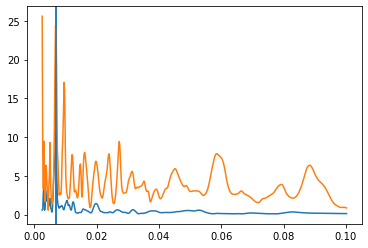

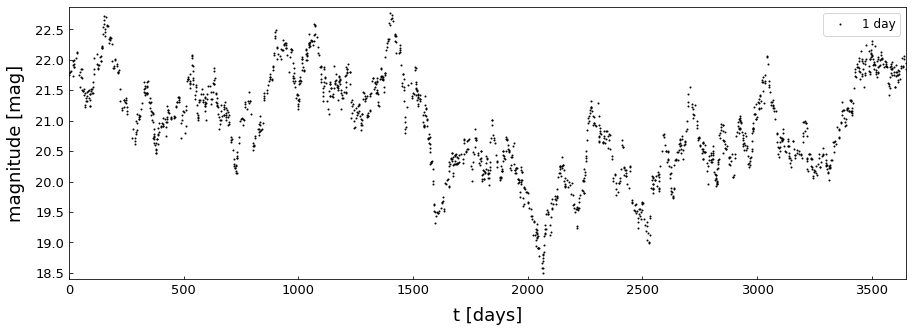

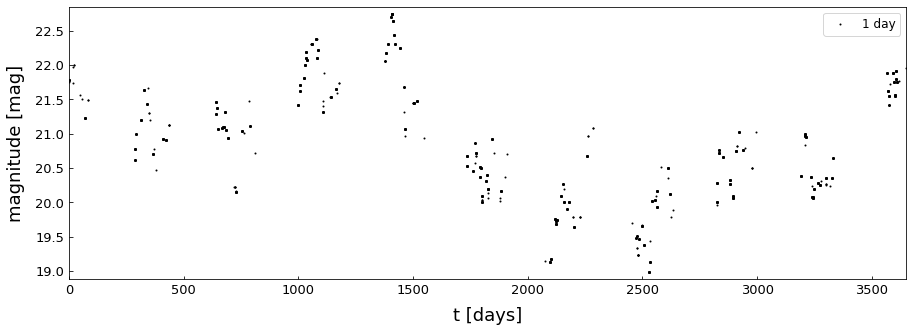

*** Starting Weighted Wavelet Z-transform ***

Pseudo sample frequency (median) is  0.651
largest tau window is  46.197
78.41 seconds has passed to complete Weighted Wavelet Z-transform 

*** Starting Weighted Wavelet Z-transform ***

Pseudo sample frequency (median) is  2400.0
largest tau window is  46.201
119.41 seconds has passed to complete Weighted Wavelet Z-transform 

[0.0125, 0.008333333333333333, -5.208333333333334e-06, True]
[0.0025, 0.1, 0.000195, True]


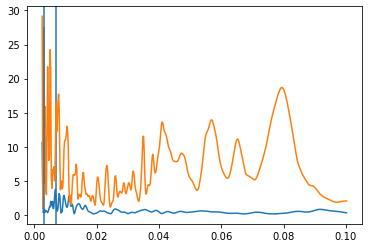

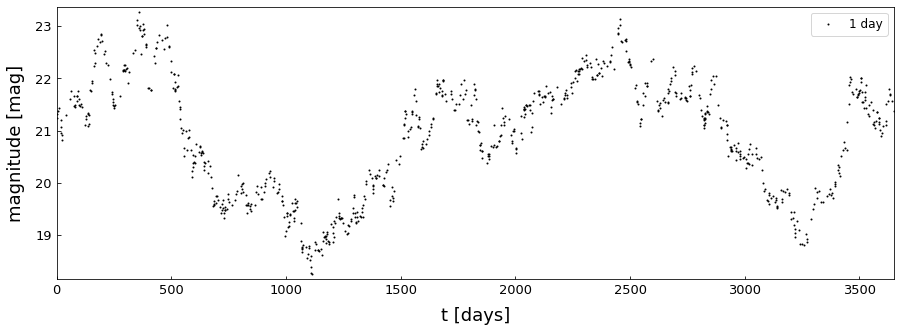

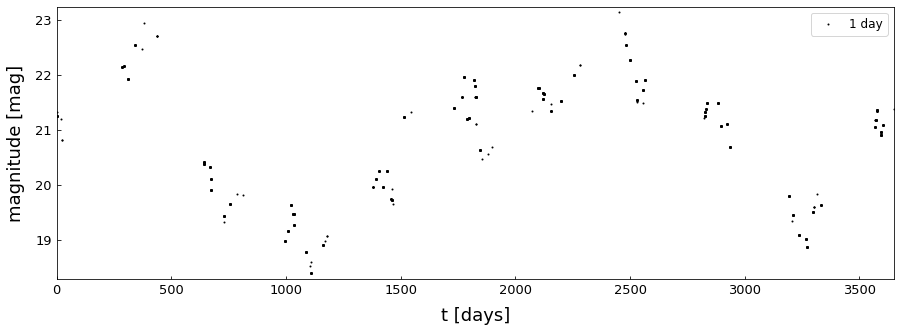

*** Starting Weighted Wavelet Z-transform ***

Pseudo sample frequency (median) is  0.322
largest tau window is  46.197
39.21 seconds has passed to complete Weighted Wavelet Z-transform 

*** Starting Weighted Wavelet Z-transform ***

Pseudo sample frequency (median) is  2400.0
largest tau window is  46.201
66.81 seconds has passed to complete Weighted Wavelet Z-transform 

[0.0125, 0.008333333333333333, -5.208333333333334e-06, True]
[0.0025, 0.1, 0.000195, True]


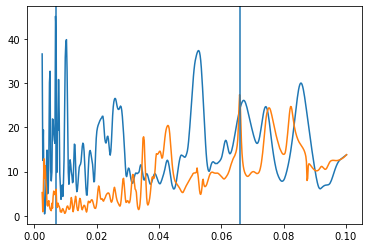

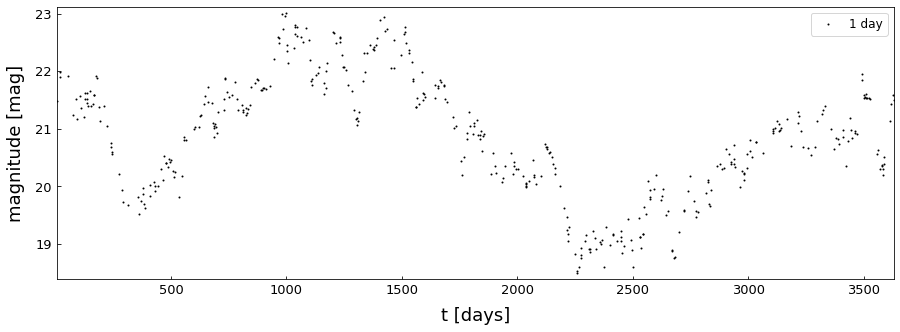

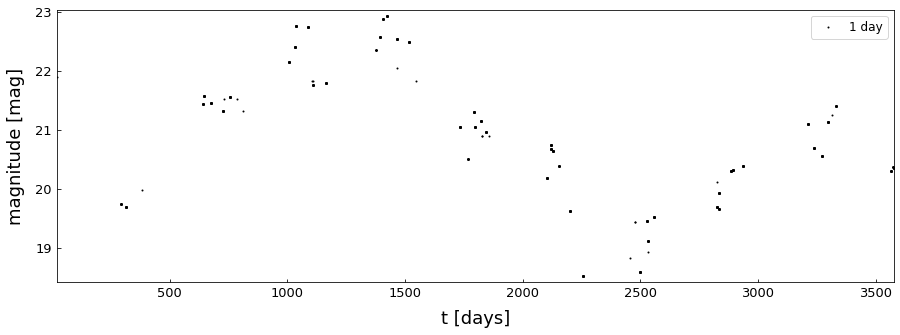

*** Starting Weighted Wavelet Z-transform ***

Pseudo sample frequency (median) is  0.156
largest tau window is  45.862
19.99 seconds has passed to complete Weighted Wavelet Z-transform 

*** Starting Weighted Wavelet Z-transform ***

Pseudo sample frequency (median) is  2400.0
largest tau window is  45.04
45.36 seconds has passed to complete Weighted Wavelet Z-transform 

[0.0125, 0.008333333333333333, -5.208333333333334e-06, True]
[0.0025, 0.1, 0.000195, True]


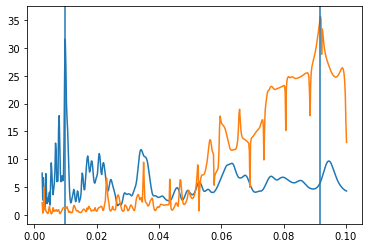

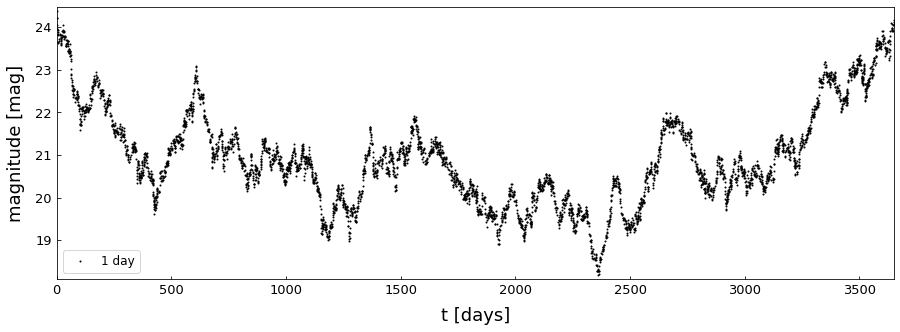

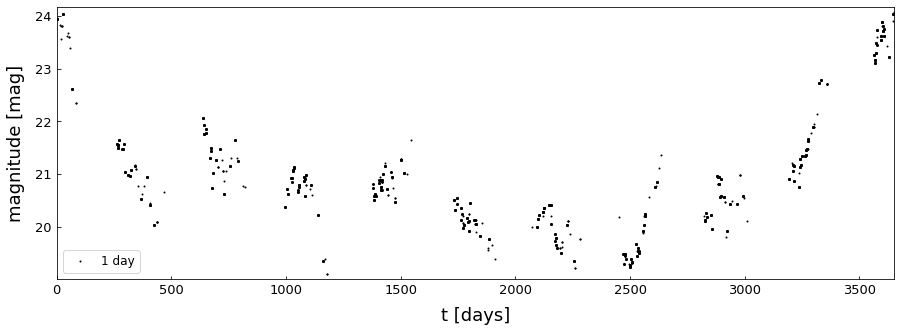

*** Starting Weighted Wavelet Z-transform ***

Pseudo sample frequency (median) is  1.694
largest tau window is  46.198
193.08 seconds has passed to complete Weighted Wavelet Z-transform 

*** Starting Weighted Wavelet Z-transform ***

Pseudo sample frequency (median) is  2400.0
largest tau window is  46.201
167.09 seconds has passed to complete Weighted Wavelet Z-transform 

[0.0125, 0.008333333333333333, -5.208333333333334e-06, True]
[0.0025, 0.1, 0.000195, True]


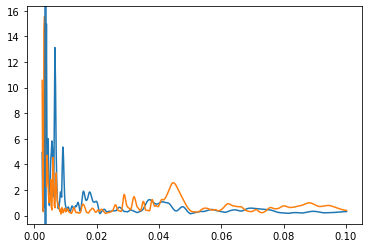

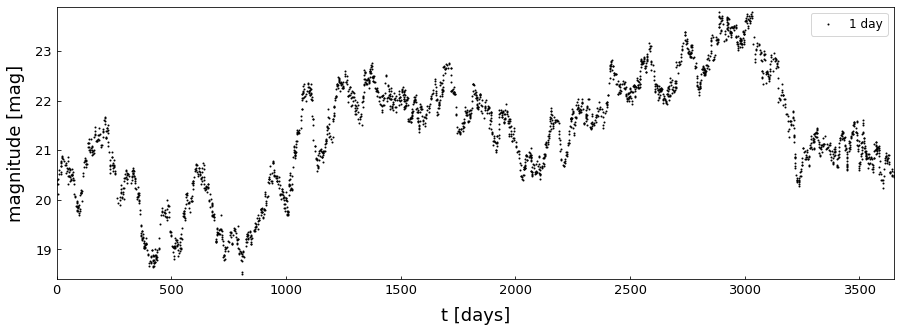

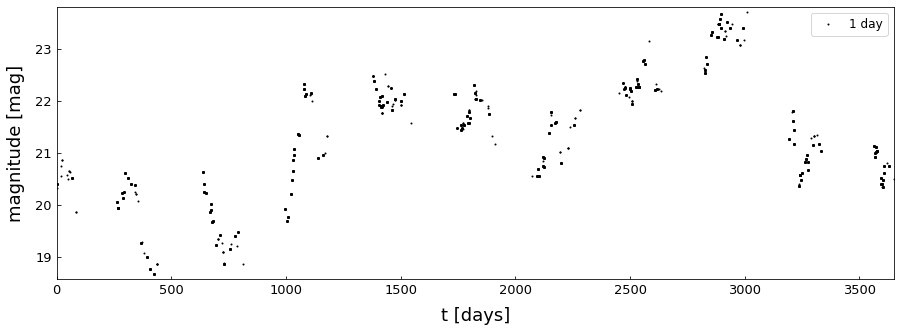

*** Starting Weighted Wavelet Z-transform ***

Pseudo sample frequency (median) is  1.02
largest tau window is  46.198
115.85 seconds has passed to complete Weighted Wavelet Z-transform 

*** Starting Weighted Wavelet Z-transform ***

Pseudo sample frequency (median) is  2400.0
largest tau window is  46.201
148.92 seconds has passed to complete Weighted Wavelet Z-transform 

[0.0125, 0.008333333333333333, -5.208333333333334e-06, True]
[0.0025, 0.1, 0.000195, True]


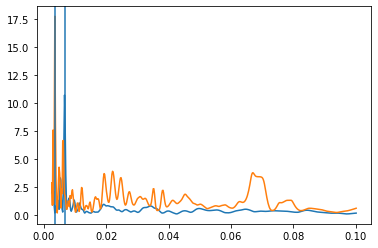

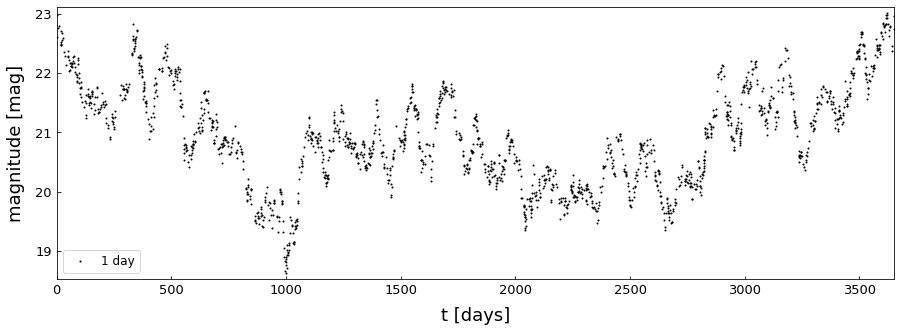

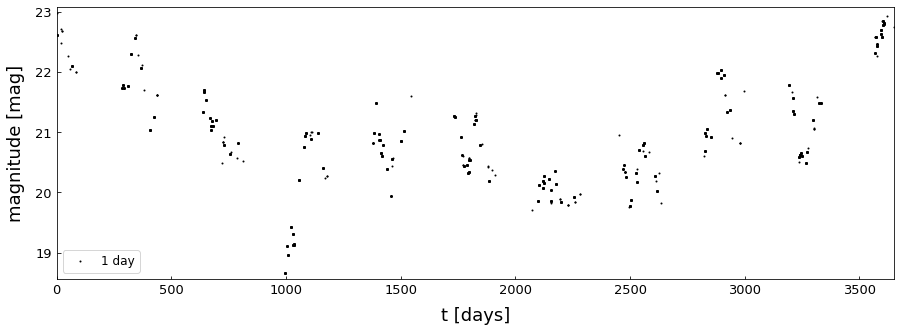

*** Starting Weighted Wavelet Z-transform ***

Pseudo sample frequency (median) is  0.651
largest tau window is  46.197
76.8 seconds has passed to complete Weighted Wavelet Z-transform 

*** Starting Weighted Wavelet Z-transform ***

Pseudo sample frequency (median) is  2400.0
largest tau window is  46.201
118.76 seconds has passed to complete Weighted Wavelet Z-transform 

[0.0125, 0.008333333333333333, -5.208333333333334e-06, True]
[0.0025, 0.1, 0.000195, True]


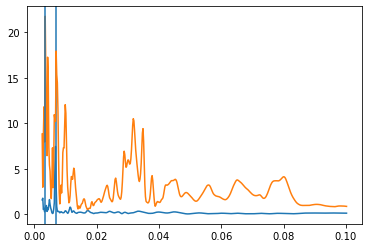

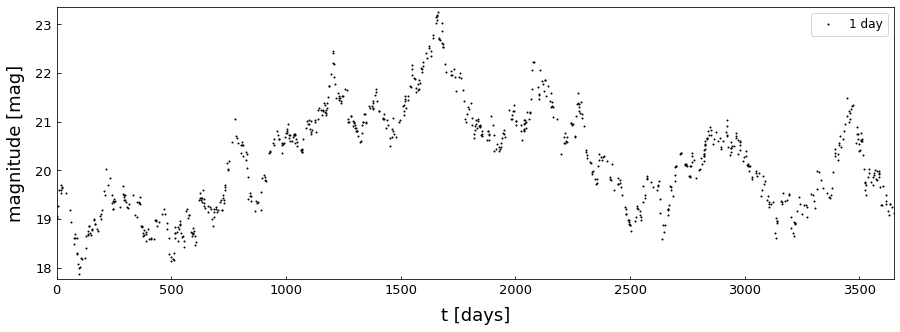

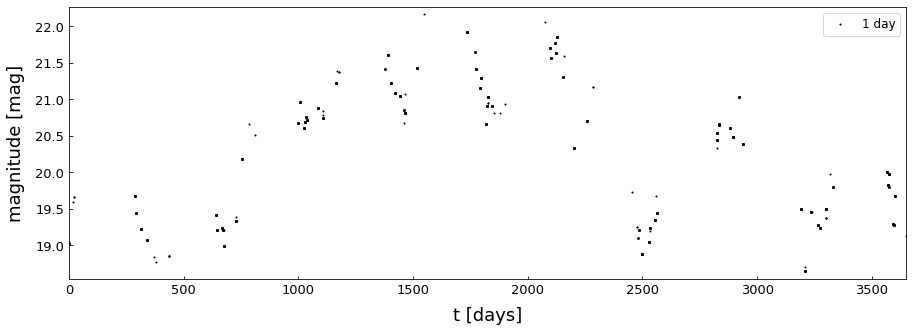

*** Starting Weighted Wavelet Z-transform ***

Pseudo sample frequency (median) is  0.322
largest tau window is  46.197
39.31 seconds has passed to complete Weighted Wavelet Z-transform 

*** Starting Weighted Wavelet Z-transform ***

Pseudo sample frequency (median) is  2400.0
largest tau window is  46.201
66.24 seconds has passed to complete Weighted Wavelet Z-transform 

[0.0125, 0.008333333333333333, -5.208333333333334e-06, True]
[0.0025, 0.1, 0.000195, True]


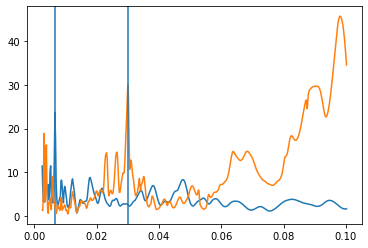

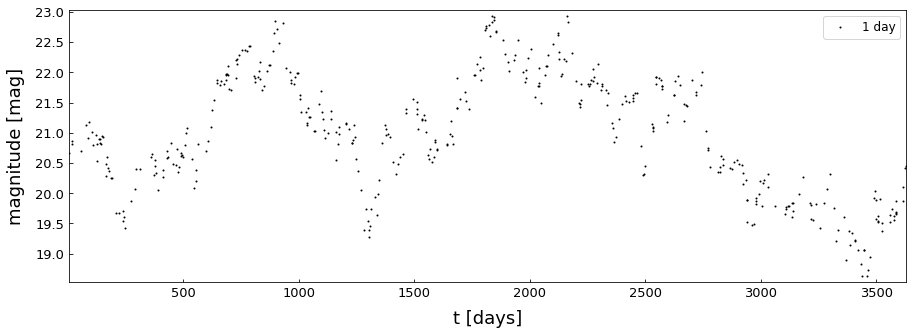

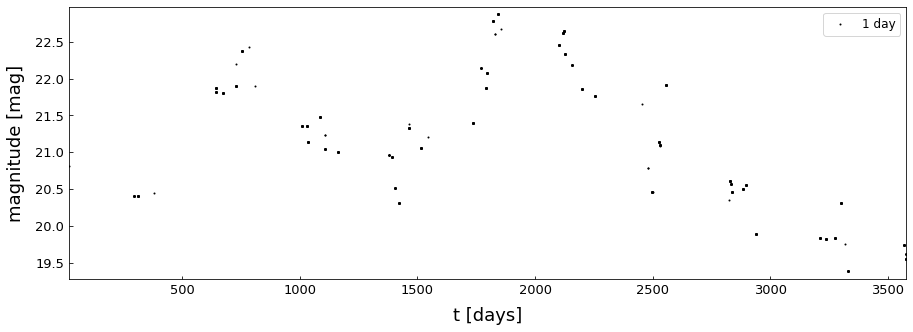

*** Starting Weighted Wavelet Z-transform ***

Pseudo sample frequency (median) is  0.156
largest tau window is  45.862
20.3 seconds has passed to complete Weighted Wavelet Z-transform 

*** Starting Weighted Wavelet Z-transform ***

Pseudo sample frequency (median) is  2400.0
largest tau window is  45.04
45.83 seconds has passed to complete Weighted Wavelet Z-transform 

[0.0125, 0.008333333333333333, -5.208333333333334e-06, True]
[0.0025, 0.1, 0.000195, True]


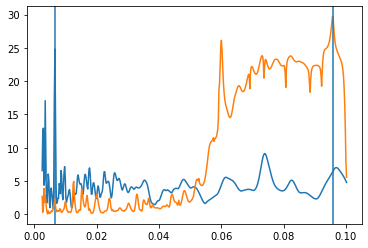

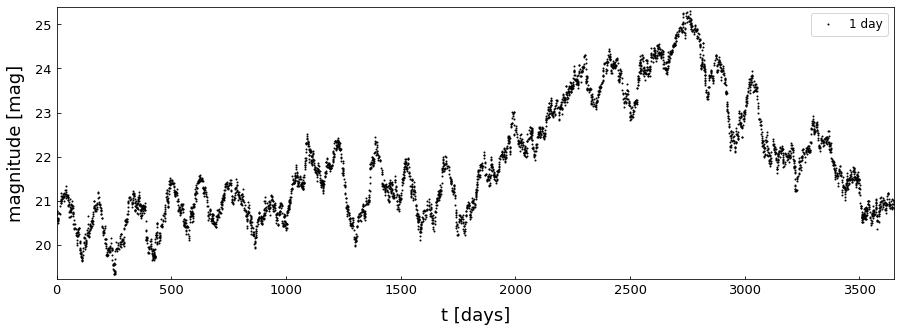

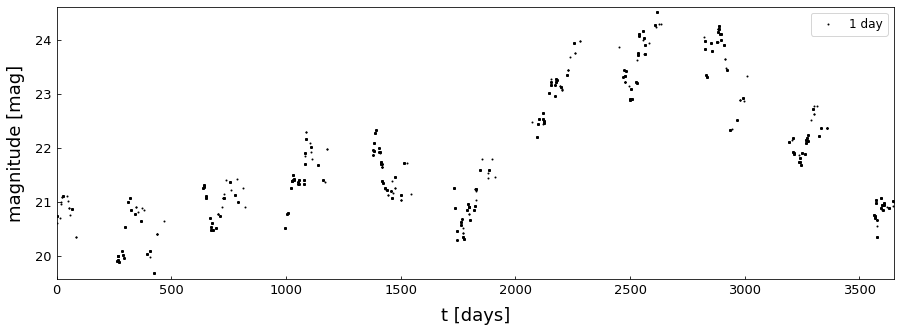

*** Starting Weighted Wavelet Z-transform ***

Pseudo sample frequency (median) is  1.694
largest tau window is  46.198
191.72 seconds has passed to complete Weighted Wavelet Z-transform 

*** Starting Weighted Wavelet Z-transform ***

Pseudo sample frequency (median) is  2400.0
largest tau window is  46.201
167.25 seconds has passed to complete Weighted Wavelet Z-transform 

[0.0125, 0.008333333333333333, -5.208333333333334e-06, True]
[0.0025, 0.1, 0.000195, True]


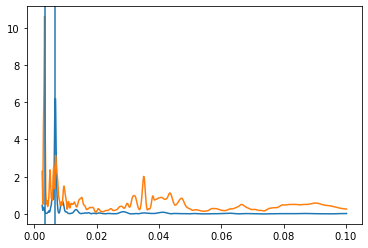

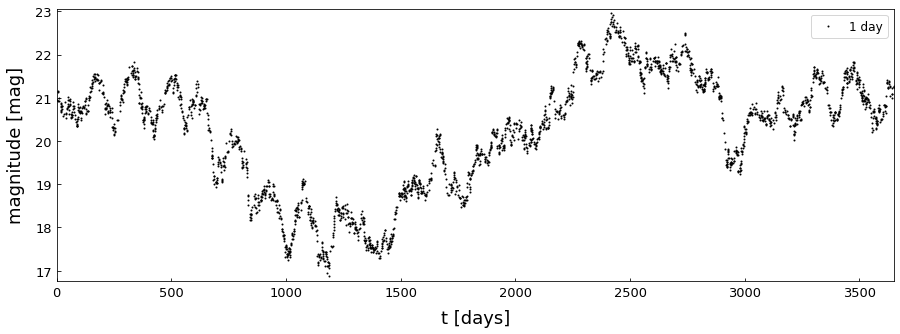

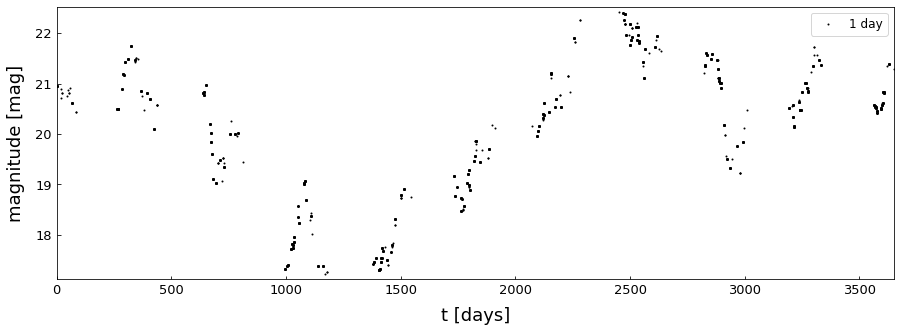

*** Starting Weighted Wavelet Z-transform ***

Pseudo sample frequency (median) is  1.02
largest tau window is  46.198
116.78 seconds has passed to complete Weighted Wavelet Z-transform 

*** Starting Weighted Wavelet Z-transform ***

Pseudo sample frequency (median) is  2400.0
largest tau window is  46.201
148.62 seconds has passed to complete Weighted Wavelet Z-transform 

[0.0125, 0.008333333333333333, -5.208333333333334e-06, True]
[0.0025, 0.1, 0.000195, True]


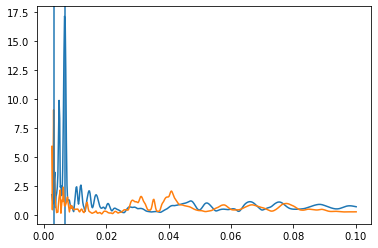

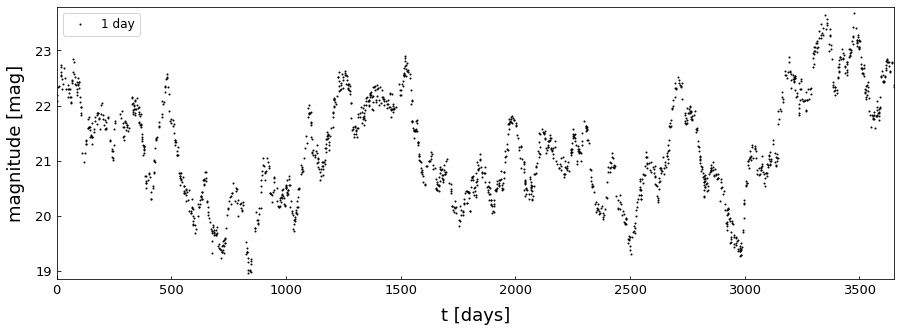

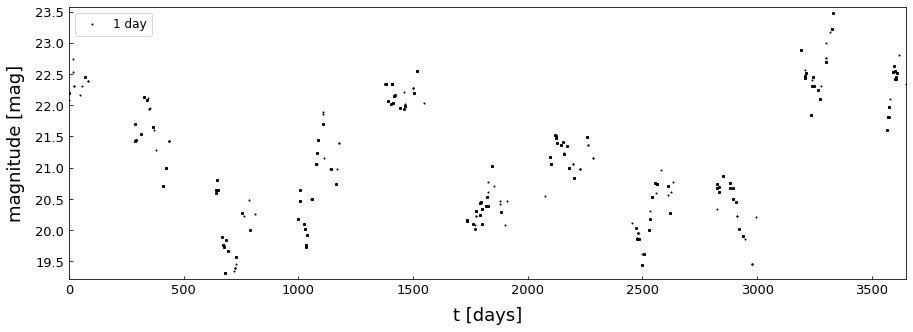

*** Starting Weighted Wavelet Z-transform ***

Pseudo sample frequency (median) is  0.651
largest tau window is  46.197
77.34 seconds has passed to complete Weighted Wavelet Z-transform 

*** Starting Weighted Wavelet Z-transform ***

Pseudo sample frequency (median) is  2400.0
largest tau window is  46.201
118.29 seconds has passed to complete Weighted Wavelet Z-transform 

[0.0125, 0.008333333333333333, -5.208333333333334e-06, True]
[0.0025, 0.1, 0.000195, True]


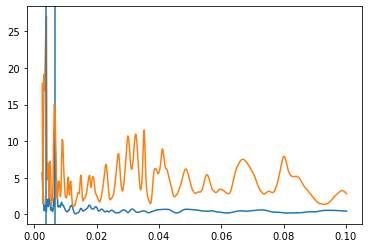

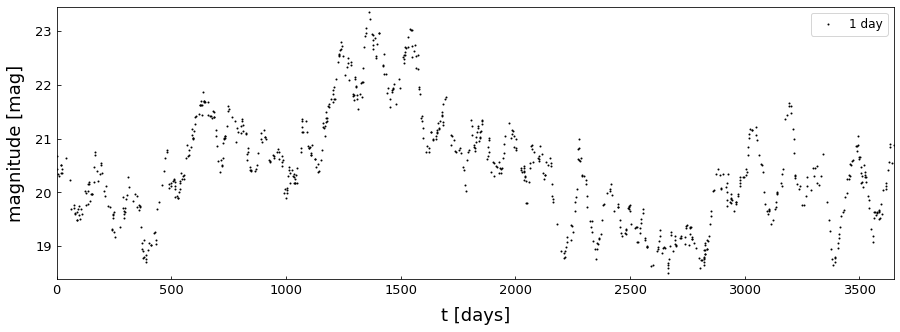

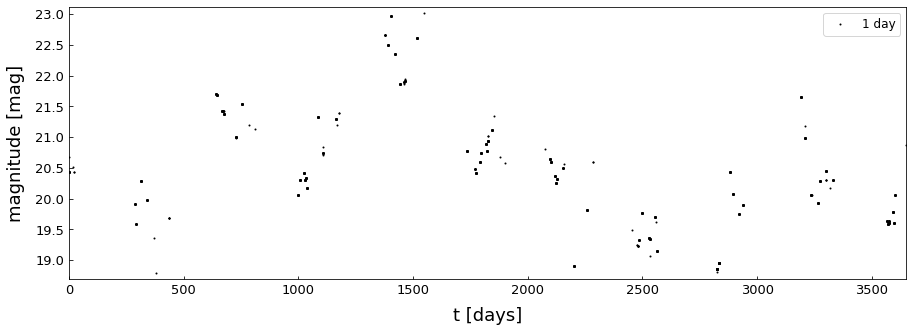

*** Starting Weighted Wavelet Z-transform ***

Pseudo sample frequency (median) is  0.322
largest tau window is  46.197
39.63 seconds has passed to complete Weighted Wavelet Z-transform 

*** Starting Weighted Wavelet Z-transform ***

Pseudo sample frequency (median) is  2400.0
largest tau window is  46.201
66.34 seconds has passed to complete Weighted Wavelet Z-transform 

[0.0125, 0.008333333333333333, -5.208333333333334e-06, True]
[0.0025, 0.1, 0.000195, True]


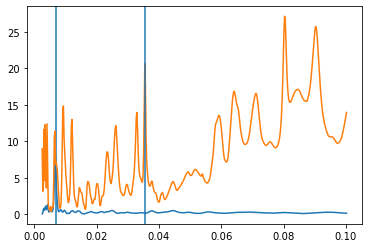

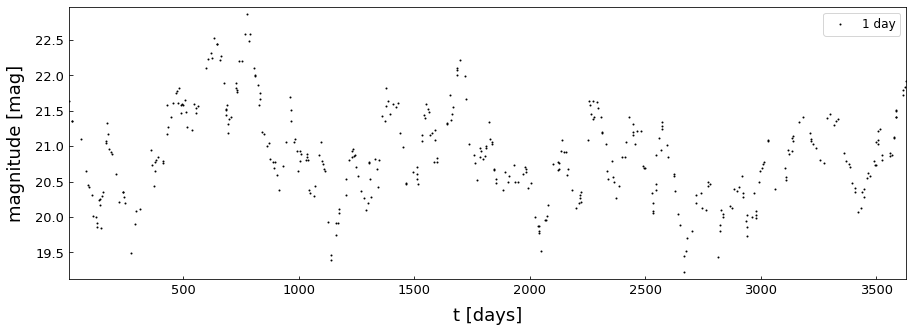

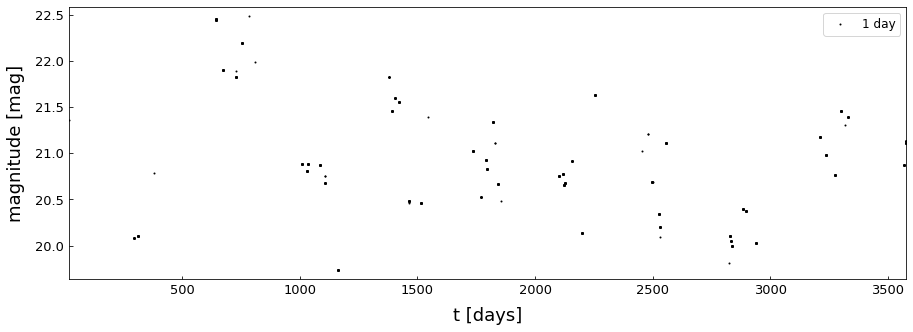

*** Starting Weighted Wavelet Z-transform ***

Pseudo sample frequency (median) is  0.156
largest tau window is  45.862
20.21 seconds has passed to complete Weighted Wavelet Z-transform 

*** Starting Weighted Wavelet Z-transform ***

Pseudo sample frequency (median) is  2400.0
largest tau window is  45.04
46.03 seconds has passed to complete Weighted Wavelet Z-transform 



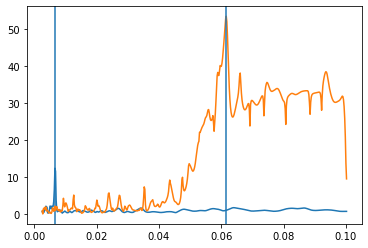

In [28]:
fmax = 1/ 10 # (1. /400.) 0.011111
fmin = 1/ 400 # (1. /1.)  0.00909
df = (fmax - fmin) / 500

amplitudes =  np.array([0.1, 0.2, 0.3, 0.4])  # [0.1, 0.2, 0.3, 0.4]
freq = np.array([150])
percent = np.array([0, 0.4, 0.6, 0.8, 0.9]) # [0, 0.4, 0.6, 0.8, 0.9]
mjd_start = np.min(opsim_data)
magnitude = 20
time_interval = 10

result2_150 = []
result2_opsim = []


for A in amplitudes: 
    for frequency in freq:
        for percentage in percent:
            print(params)
            params = [fmin, fmax, df, True] 
            print(params)
            current = np.array([A, frequency, percentage])
            tt, yy = simple_mock_lc(time_interval = time_interval, num_points = len_os, 
                                    frequency = frequency, amplitude = A, percent = percentage, magnitude = magnitude, mjd_start = mjd_start)
            ttt, yyy = artificial_lc_sampled(opsim_data, tt, yy)
            fig_plot(tt, yy) 
            fig_plot(ttt, yyy) 
            plt.show()
            
            # WWZ on simulated LC
            time_division = 80
            wwt_result, params = wwt(tt, yy, time_division, params)
            peaks, result, osex, hh1arr1  = wwt_find_freq(wwt_result, time_division)

            current = np.append(current, result)
            current = np.append(current, np.abs(result-frequency)/frequency)
            
            
            params = [fmin, fmax, df, True] 
            # WWZ on OpSim
            time_division = 80
            wwt_result, params = wwt(ttt, yyy, time_division, params)
            peaks, result, osex, hh1arr1  = wwt_find_freq(wwt_result, time_division)

            current = np.append(current, result)
            current = np.append(current, np.abs(result-frequency)/frequency)
            
            result2_150.insert(len(result2_150), current)
            
            
            

[0.0125, 0.008333333333333333, -5.208333333333334e-06, True]
[0.000625, 0.0007692307692307692, 0.00014423076923076922, True]


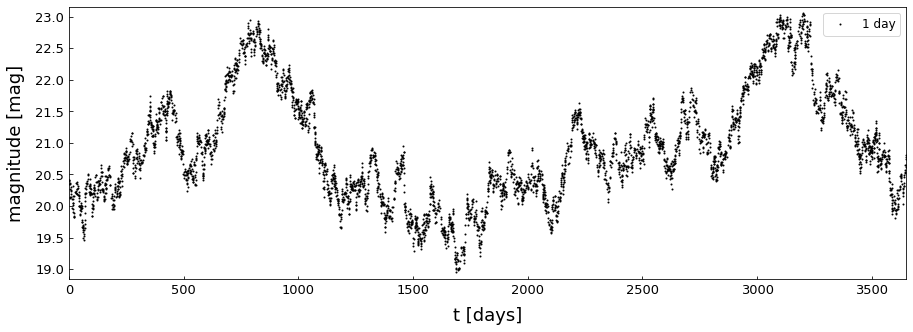

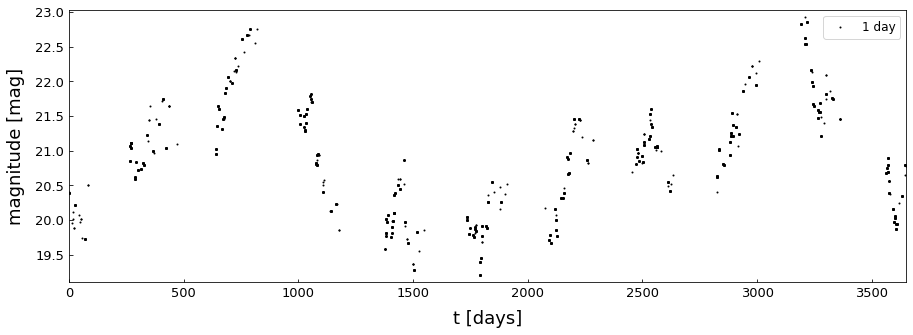

*** Starting Weighted Wavelet Z-transform ***

Pseudo sample frequency (median) is  1.694
largest tau window is  46.198
3.96 seconds has passed to complete Weighted Wavelet Z-transform 



KeyboardInterrupt: 

In [34]:
fmax = 1/ 1300 # (1. /400.) 0.011111
fmin = 1/ 1600 # (1. /1.)  0.00909
df = (fmax - fmin) / 1

amplitudes =  np.array([0.1, 0.2, 0.3, 0.4])  # [0.1, 0.2, 0.3, 0.4]
freq = np.array([1500])
percent = np.array([0, 0.4, 0.6, 0.8, 0.9]) # [0, 0.4, 0.6, 0.8, 0.9]
mjd_start = np.min(opsim_data)
magnitude = 20
time_interval = 10

result2_1500 = []
result2_opsim = []


for A in amplitudes: 
    for frequency in freq:
        for percentage in percent:
            print(params)
            params = [fmin, fmax, df, True] 
            print(params)
            current = np.array([A, frequency, percentage])
            tt, yy = simple_mock_lc(time_interval = time_interval, num_points = len_os, 
                                    frequency = frequency, amplitude = A, percent = percentage, magnitude = magnitude, mjd_start = mjd_start)
            ttt, yyy = artificial_lc_sampled(opsim_data, tt, yy)
            fig_plot(tt, yy) 
            fig_plot(ttt, yyy) 
            plt.show()
            
            # WWZ on simulated LC
            time_division = 80
            wwt_result, params = wwt(tt, yy, time_division, params)
            peaks, result, osex, hh1arr1  = wwt_find_freq(wwt_result, time_division)

            current = np.append(current, result)
            current = np.append(current, np.abs(result-frequency)/frequency)
            
            
            params = [fmin, fmax, df, True] 
            # WWZ on OpSim
            time_division = 80
            wwt_result, params = wwt(ttt, yyy, time_division, params)
            peaks, result, osex, hh1arr1  = wwt_find_freq(wwt_result, time_division)

            current = np.append(current, result)
            current = np.append(current, np.abs(result-frequency)/frequency)
            
            result2_1500.insert(len(result2_150), current)
            
            
            

[0.0125, 0.008333333333333333, -5.208333333333334e-06, True]
[0.01, 1.0, 0.00198, True]


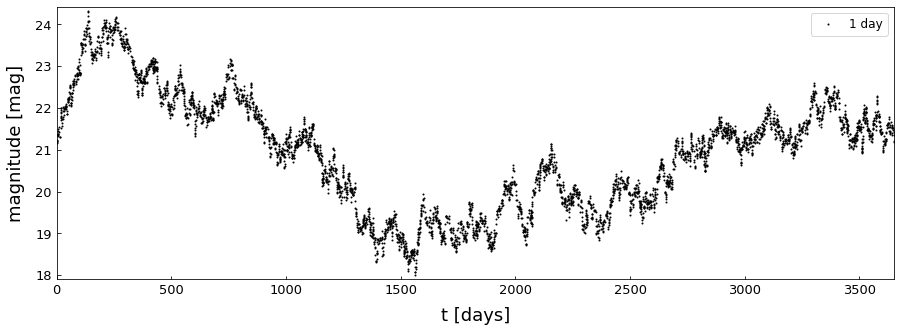

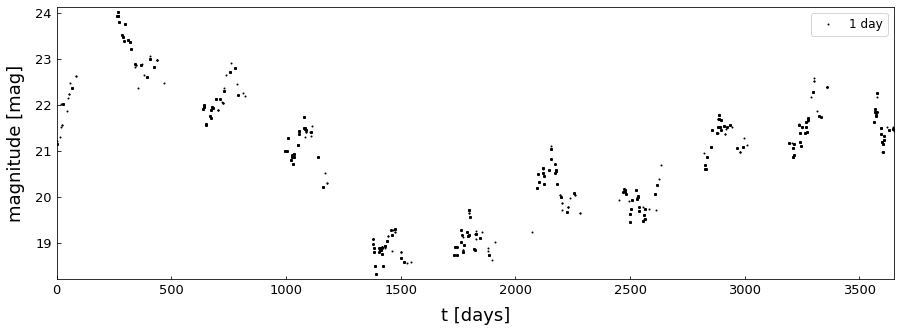

*** Starting Weighted Wavelet Z-transform ***

Pseudo sample frequency (median) is  1.694
largest tau window is  46.198
52.5 seconds has passed to complete Weighted Wavelet Z-transform 

*** Starting Weighted Wavelet Z-transform ***

Pseudo sample frequency (median) is  2400.0
largest tau window is  46.201
46.87 seconds has passed to complete Weighted Wavelet Z-transform 

[0.0125, 0.008333333333333333, -5.208333333333334e-06, True]
[0.01, 1.0, 0.00198, True]


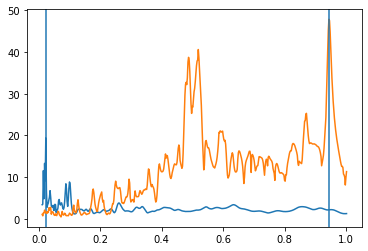

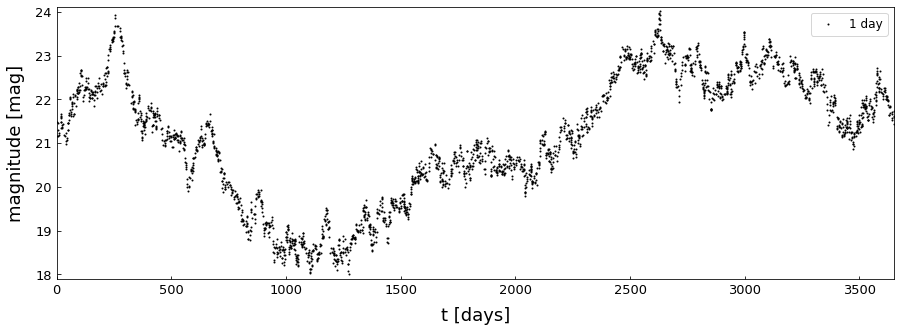

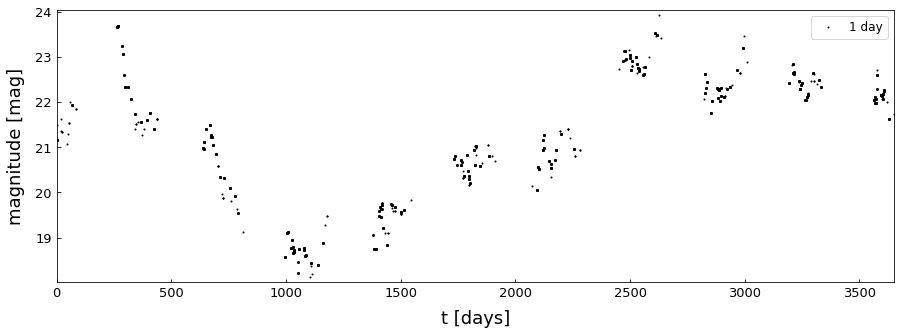

*** Starting Weighted Wavelet Z-transform ***

Pseudo sample frequency (median) is  1.02
largest tau window is  46.198
34.5 seconds has passed to complete Weighted Wavelet Z-transform 

*** Starting Weighted Wavelet Z-transform ***

Pseudo sample frequency (median) is  2400.0
largest tau window is  46.201
39.61 seconds has passed to complete Weighted Wavelet Z-transform 

[0.0125, 0.008333333333333333, -5.208333333333334e-06, True]
[0.01, 1.0, 0.00198, True]


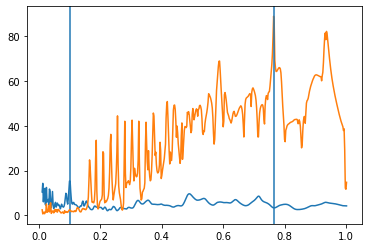

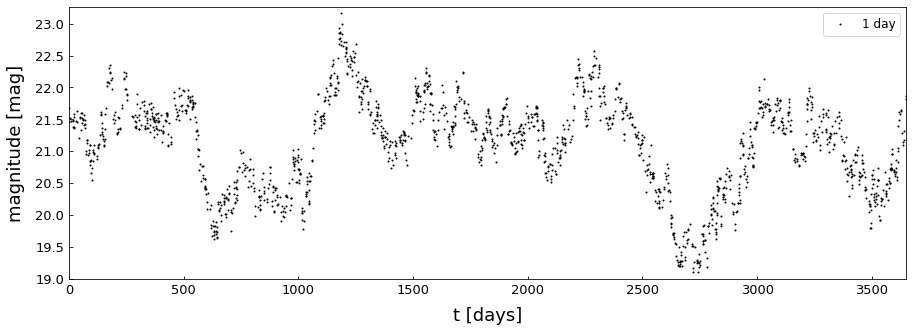

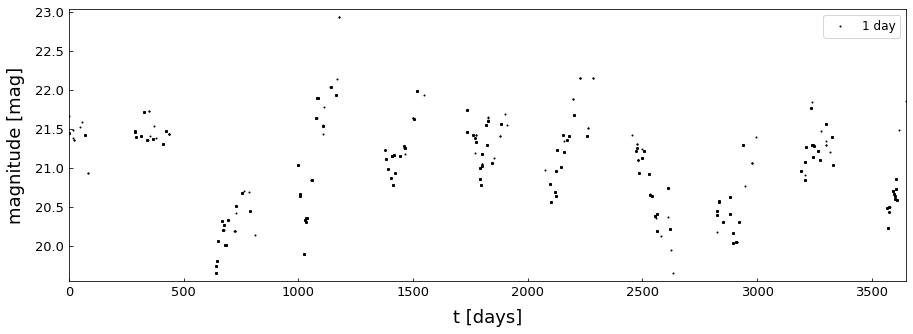

*** Starting Weighted Wavelet Z-transform ***

Pseudo sample frequency (median) is  0.651
largest tau window is  46.197
20.64 seconds has passed to complete Weighted Wavelet Z-transform 

*** Starting Weighted Wavelet Z-transform ***

Pseudo sample frequency (median) is  2400.0
largest tau window is  46.201
30.07 seconds has passed to complete Weighted Wavelet Z-transform 

[0.0125, 0.008333333333333333, -5.208333333333334e-06, True]
[0.01, 1.0, 0.00198, True]


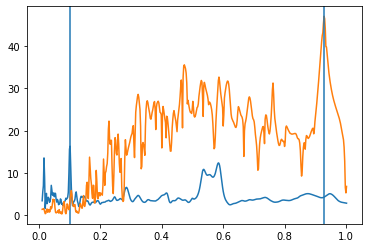

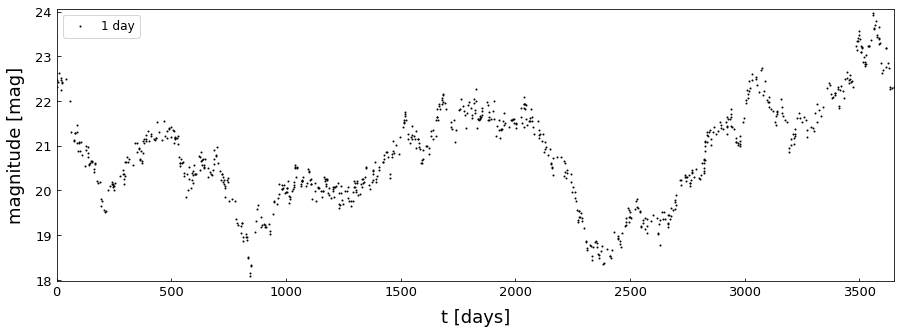

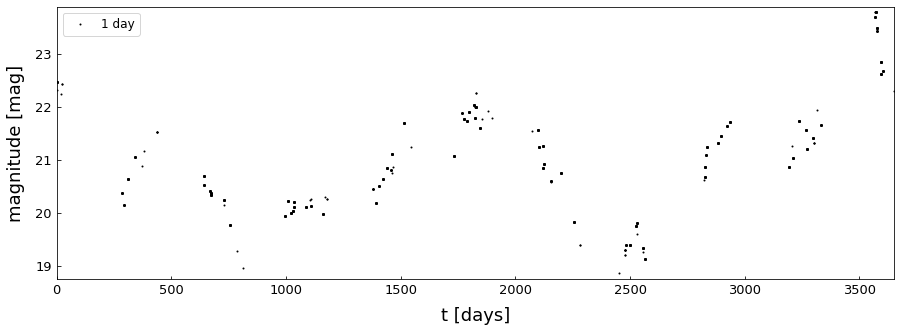

*** Starting Weighted Wavelet Z-transform ***

Pseudo sample frequency (median) is  0.322
largest tau window is  46.197
11.4 seconds has passed to complete Weighted Wavelet Z-transform 

*** Starting Weighted Wavelet Z-transform ***

Pseudo sample frequency (median) is  2400.0
largest tau window is  46.201
16.98 seconds has passed to complete Weighted Wavelet Z-transform 

[0.0125, 0.008333333333333333, -5.208333333333334e-06, True]
[0.01, 1.0, 0.00198, True]


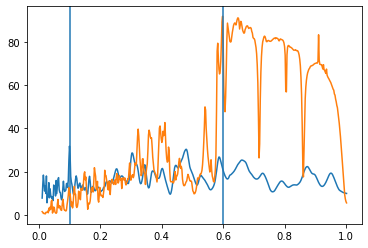

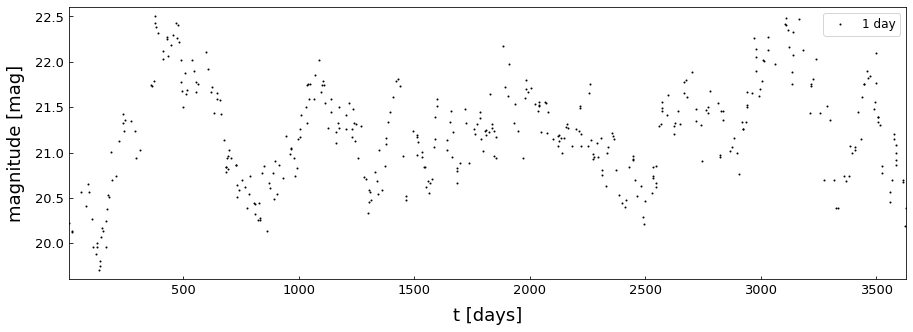

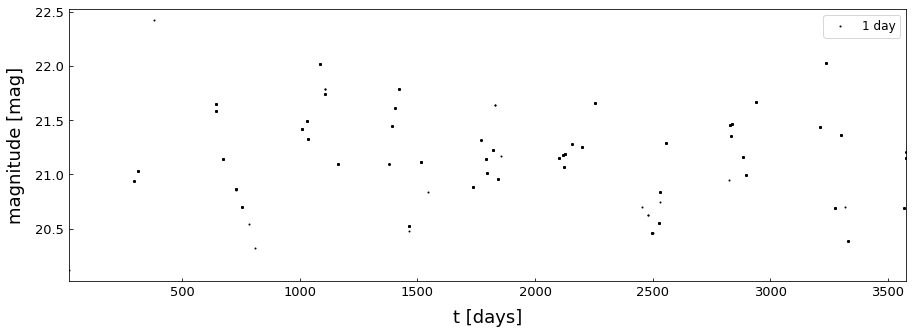

*** Starting Weighted Wavelet Z-transform ***

Pseudo sample frequency (median) is  0.156
largest tau window is  45.862
5.67 seconds has passed to complete Weighted Wavelet Z-transform 

*** Starting Weighted Wavelet Z-transform ***

Pseudo sample frequency (median) is  2400.0
largest tau window is  45.04
13.11 seconds has passed to complete Weighted Wavelet Z-transform 

[0.0125, 0.008333333333333333, -5.208333333333334e-06, True]
[0.01, 1.0, 0.00198, True]


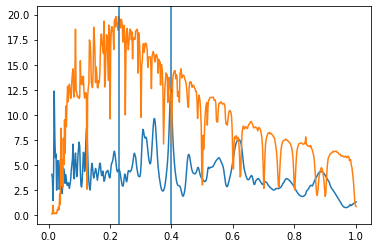

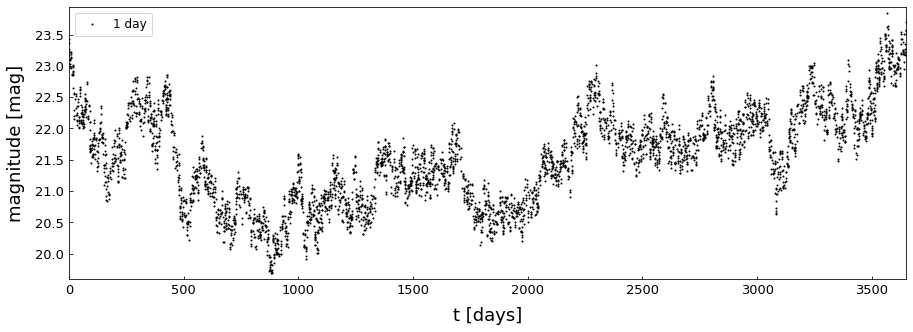

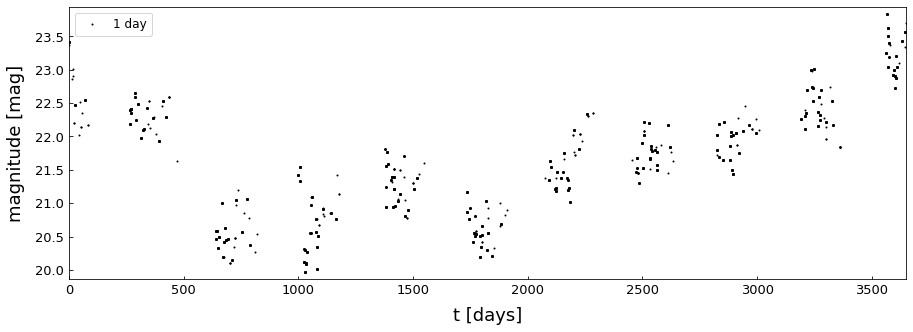

*** Starting Weighted Wavelet Z-transform ***

Pseudo sample frequency (median) is  1.694
largest tau window is  46.198
52.0 seconds has passed to complete Weighted Wavelet Z-transform 

*** Starting Weighted Wavelet Z-transform ***

Pseudo sample frequency (median) is  2400.0
largest tau window is  46.201
44.19 seconds has passed to complete Weighted Wavelet Z-transform 

[0.0125, 0.008333333333333333, -5.208333333333334e-06, True]
[0.01, 1.0, 0.00198, True]


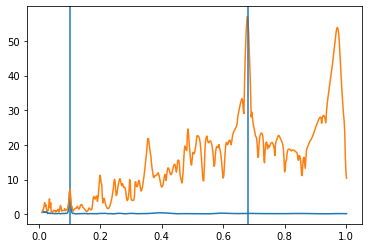

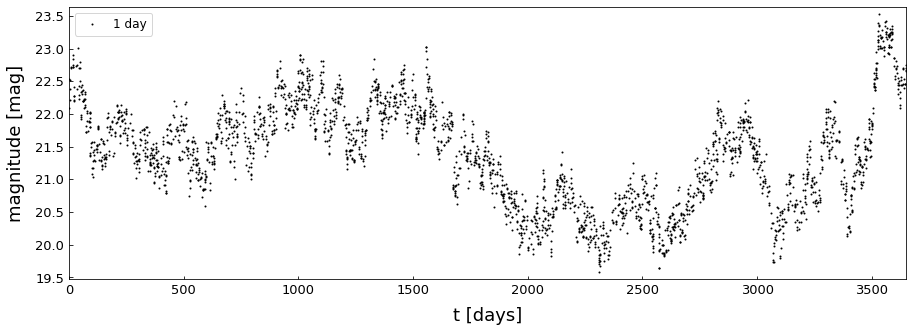

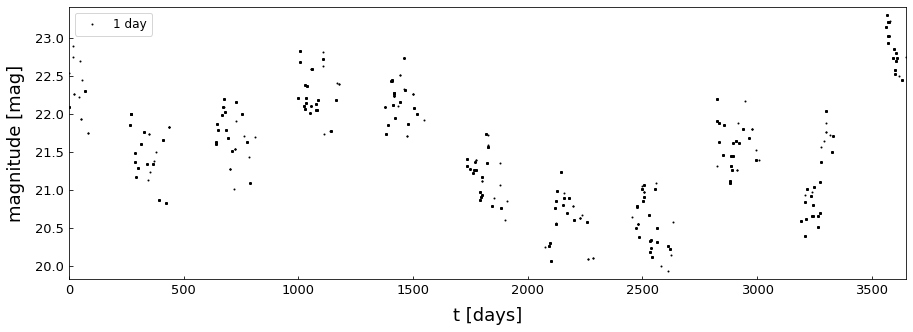

*** Starting Weighted Wavelet Z-transform ***

Pseudo sample frequency (median) is  1.02
largest tau window is  46.198
31.47 seconds has passed to complete Weighted Wavelet Z-transform 

*** Starting Weighted Wavelet Z-transform ***

Pseudo sample frequency (median) is  2400.0
largest tau window is  46.201
42.49 seconds has passed to complete Weighted Wavelet Z-transform 

[0.0125, 0.008333333333333333, -5.208333333333334e-06, True]
[0.01, 1.0, 0.00198, True]


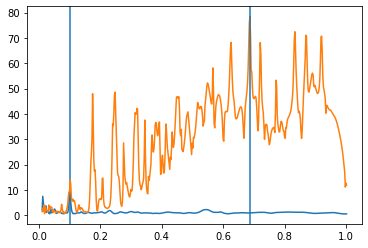

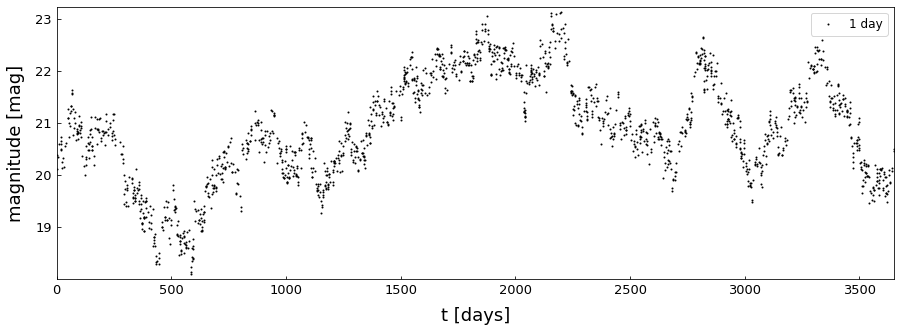

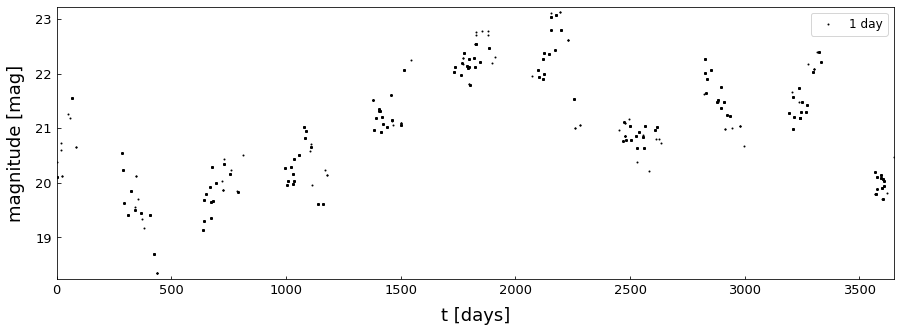

*** Starting Weighted Wavelet Z-transform ***

Pseudo sample frequency (median) is  0.651
largest tau window is  46.197
23.59 seconds has passed to complete Weighted Wavelet Z-transform 

*** Starting Weighted Wavelet Z-transform ***

Pseudo sample frequency (median) is  2400.0
largest tau window is  46.201
31.69 seconds has passed to complete Weighted Wavelet Z-transform 

[0.0125, 0.008333333333333333, -5.208333333333334e-06, True]
[0.01, 1.0, 0.00198, True]


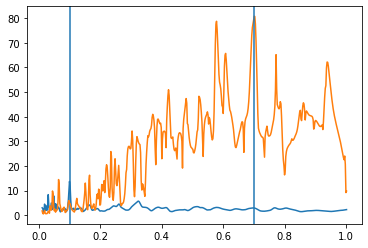

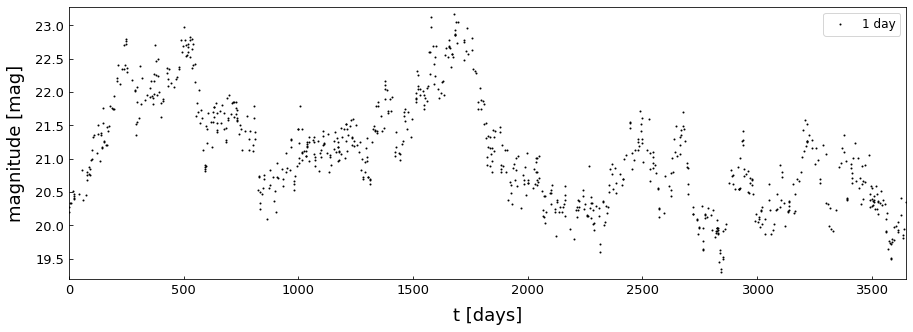

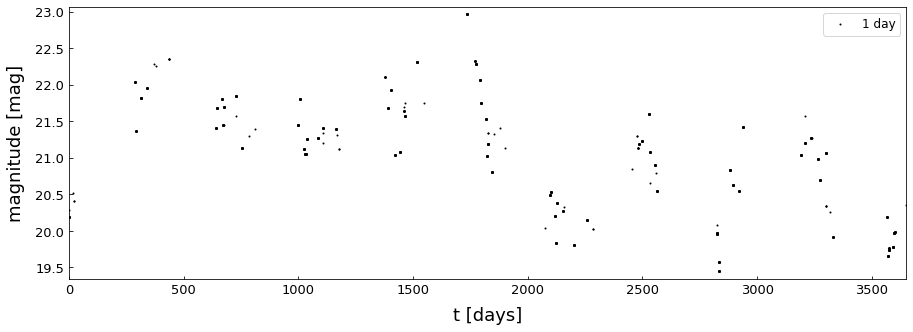

*** Starting Weighted Wavelet Z-transform ***

Pseudo sample frequency (median) is  0.322
largest tau window is  46.197
12.1 seconds has passed to complete Weighted Wavelet Z-transform 

*** Starting Weighted Wavelet Z-transform ***

Pseudo sample frequency (median) is  2400.0
largest tau window is  46.201
24.04 seconds has passed to complete Weighted Wavelet Z-transform 

[0.0125, 0.008333333333333333, -5.208333333333334e-06, True]
[0.01, 1.0, 0.00198, True]


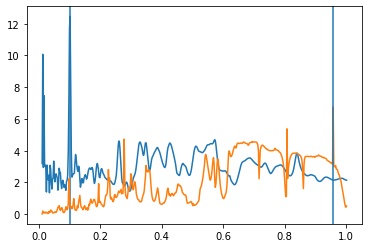

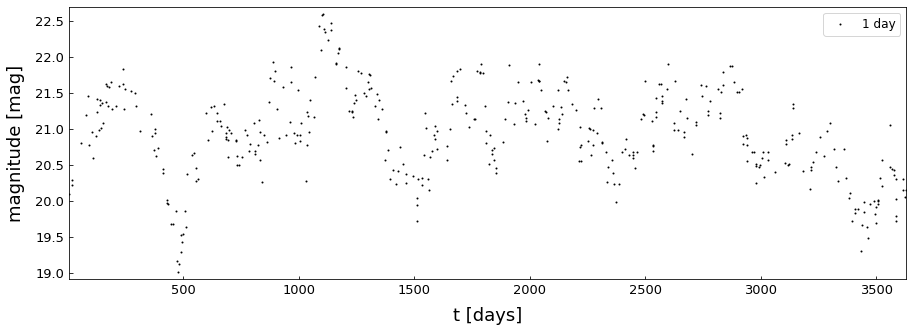

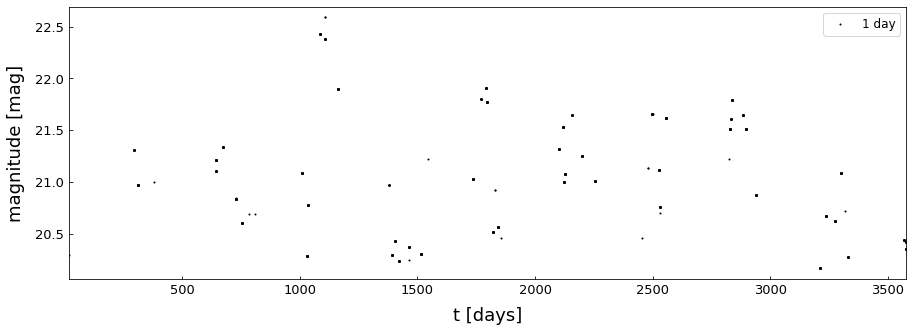

*** Starting Weighted Wavelet Z-transform ***

Pseudo sample frequency (median) is  0.156
largest tau window is  45.862
7.29 seconds has passed to complete Weighted Wavelet Z-transform 

*** Starting Weighted Wavelet Z-transform ***

Pseudo sample frequency (median) is  2400.0
largest tau window is  45.04
14.81 seconds has passed to complete Weighted Wavelet Z-transform 

[0.0125, 0.008333333333333333, -5.208333333333334e-06, True]
[0.01, 1.0, 0.00198, True]


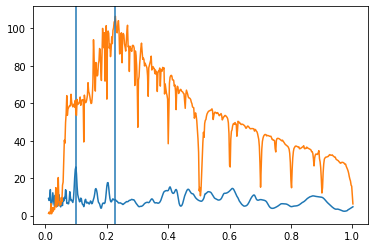

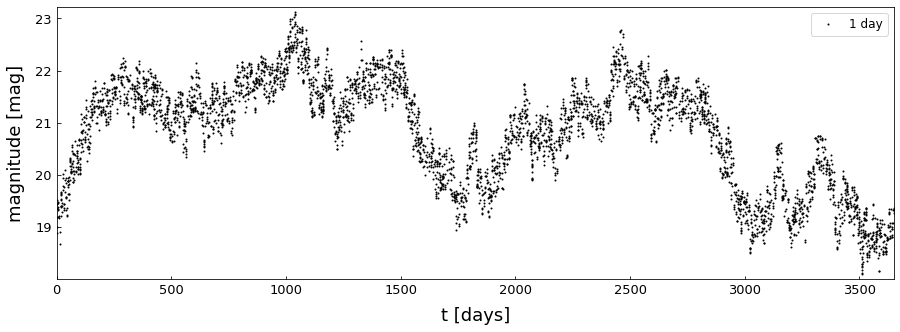

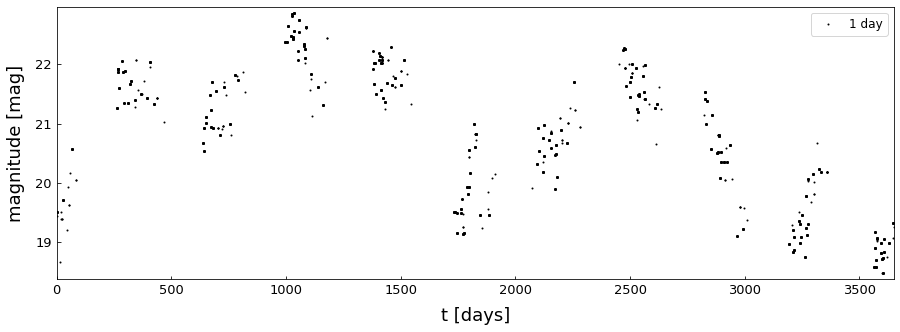

*** Starting Weighted Wavelet Z-transform ***

Pseudo sample frequency (median) is  1.694
largest tau window is  46.198
60.8 seconds has passed to complete Weighted Wavelet Z-transform 

*** Starting Weighted Wavelet Z-transform ***

Pseudo sample frequency (median) is  2400.0
largest tau window is  46.201
55.51 seconds has passed to complete Weighted Wavelet Z-transform 

[0.0125, 0.008333333333333333, -5.208333333333334e-06, True]
[0.01, 1.0, 0.00198, True]


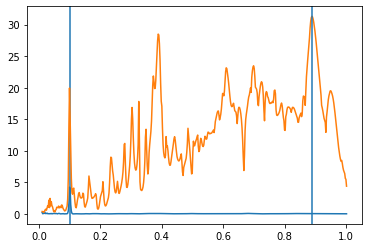

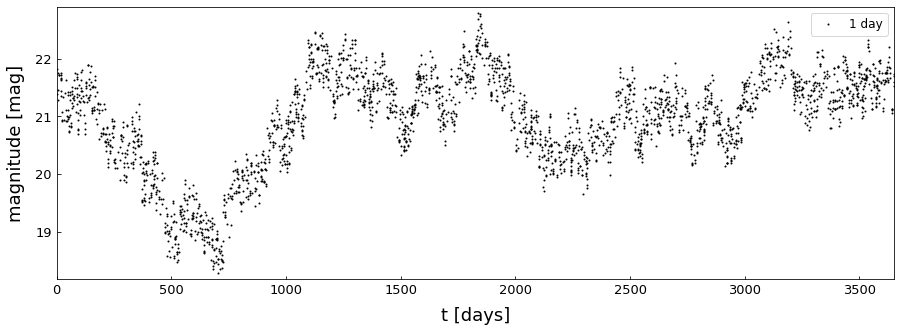

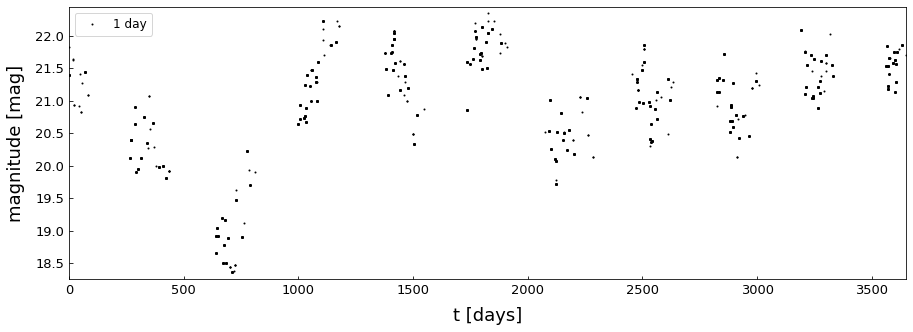

*** Starting Weighted Wavelet Z-transform ***

Pseudo sample frequency (median) is  1.02
largest tau window is  46.198
35.28 seconds has passed to complete Weighted Wavelet Z-transform 

*** Starting Weighted Wavelet Z-transform ***

Pseudo sample frequency (median) is  2400.0
largest tau window is  46.201
46.96 seconds has passed to complete Weighted Wavelet Z-transform 

[0.0125, 0.008333333333333333, -5.208333333333334e-06, True]
[0.01, 1.0, 0.00198, True]


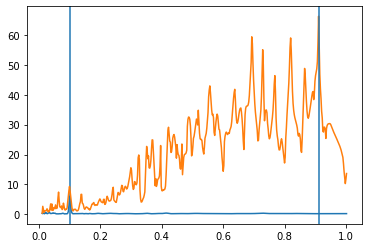

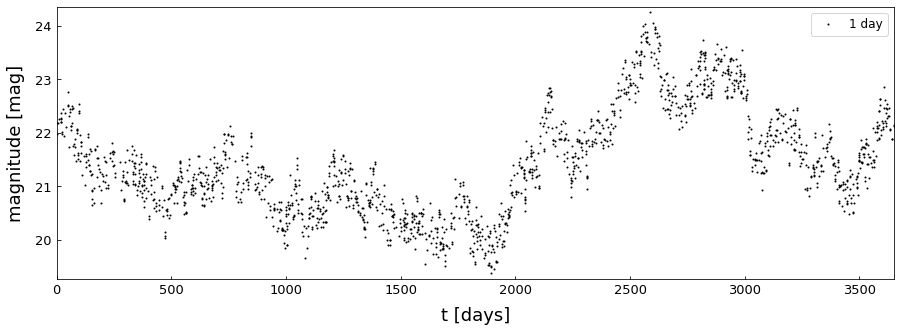

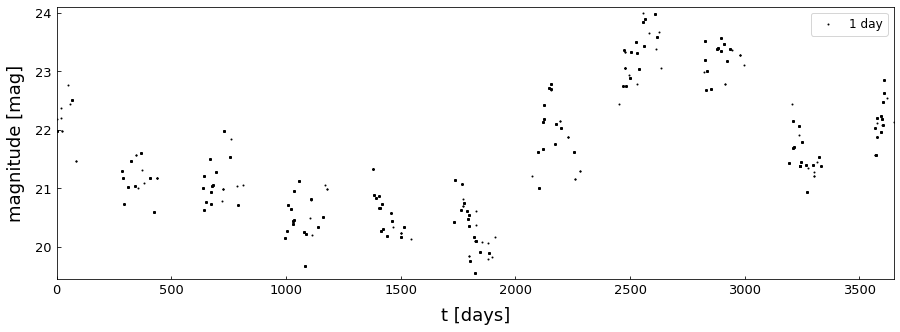

*** Starting Weighted Wavelet Z-transform ***

Pseudo sample frequency (median) is  0.651
largest tau window is  46.197
24.85 seconds has passed to complete Weighted Wavelet Z-transform 

*** Starting Weighted Wavelet Z-transform ***

Pseudo sample frequency (median) is  2400.0
largest tau window is  46.201
28.76 seconds has passed to complete Weighted Wavelet Z-transform 

[0.0125, 0.008333333333333333, -5.208333333333334e-06, True]
[0.01, 1.0, 0.00198, True]


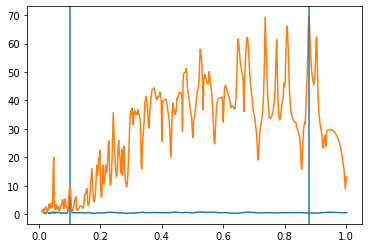

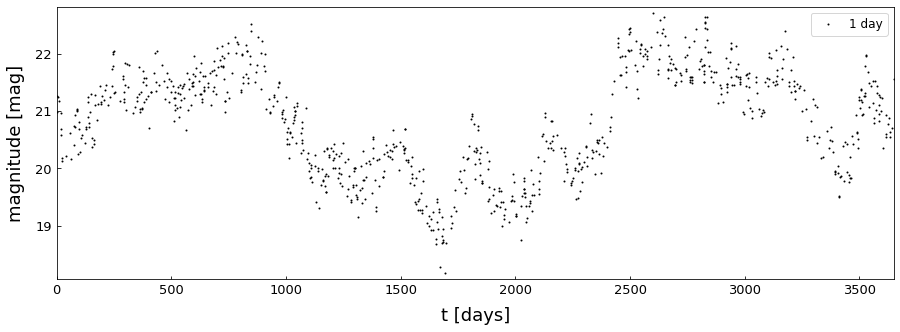

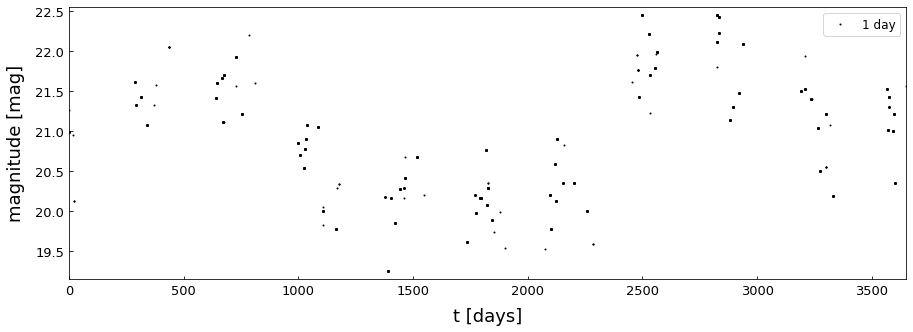

*** Starting Weighted Wavelet Z-transform ***

Pseudo sample frequency (median) is  0.322
largest tau window is  46.197
8.8 seconds has passed to complete Weighted Wavelet Z-transform 

*** Starting Weighted Wavelet Z-transform ***

Pseudo sample frequency (median) is  2400.0
largest tau window is  46.201
9.52 seconds has passed to complete Weighted Wavelet Z-transform 

[0.0125, 0.008333333333333333, -5.208333333333334e-06, True]
[0.01, 1.0, 0.00198, True]


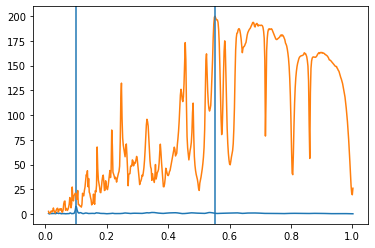

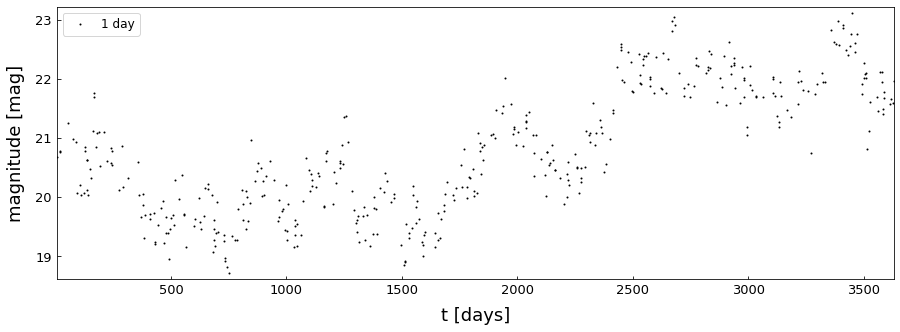

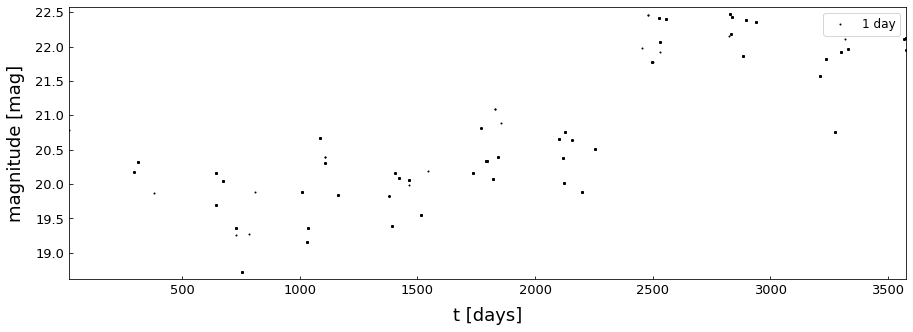

*** Starting Weighted Wavelet Z-transform ***

Pseudo sample frequency (median) is  0.156
largest tau window is  45.862
3.96 seconds has passed to complete Weighted Wavelet Z-transform 

*** Starting Weighted Wavelet Z-transform ***

Pseudo sample frequency (median) is  2400.0
largest tau window is  45.04
9.28 seconds has passed to complete Weighted Wavelet Z-transform 

[0.0125, 0.008333333333333333, -5.208333333333334e-06, True]
[0.01, 1.0, 0.00198, True]


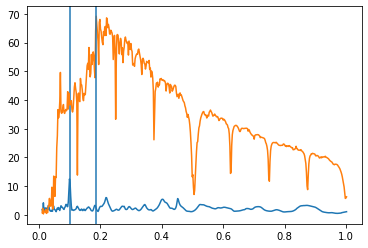

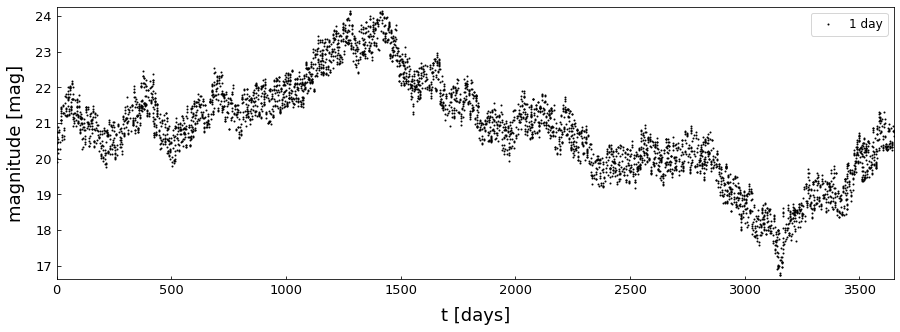

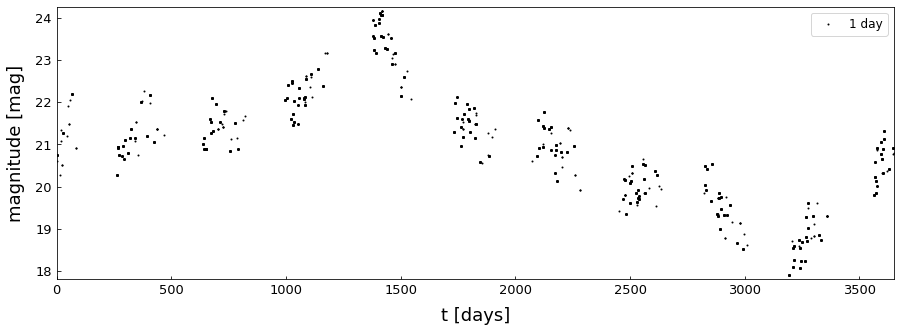

*** Starting Weighted Wavelet Z-transform ***

Pseudo sample frequency (median) is  1.694
largest tau window is  46.198
38.15 seconds has passed to complete Weighted Wavelet Z-transform 

*** Starting Weighted Wavelet Z-transform ***

Pseudo sample frequency (median) is  2400.0
largest tau window is  46.201
32.62 seconds has passed to complete Weighted Wavelet Z-transform 

[0.0125, 0.008333333333333333, -5.208333333333334e-06, True]
[0.01, 1.0, 0.00198, True]


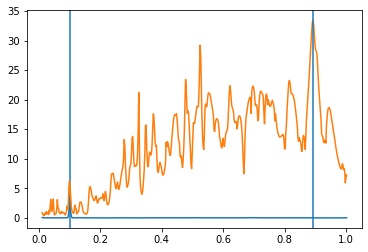

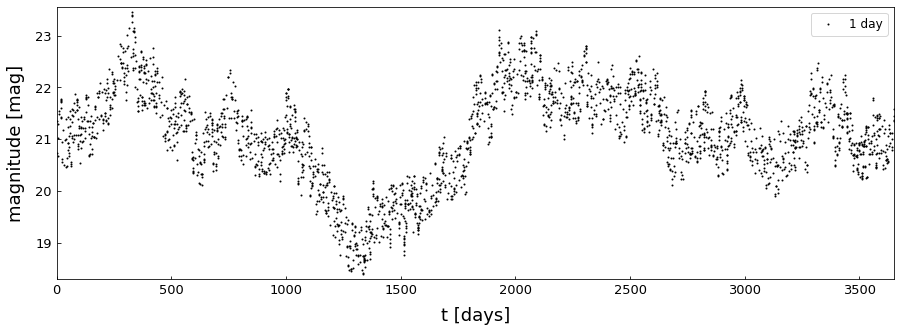

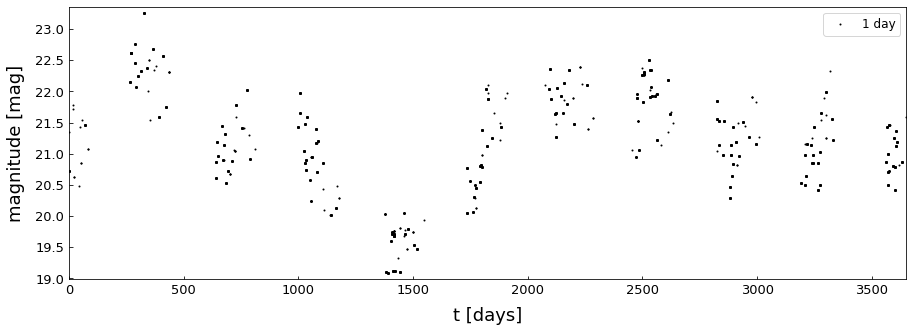

*** Starting Weighted Wavelet Z-transform ***

Pseudo sample frequency (median) is  1.02
largest tau window is  46.198
22.94 seconds has passed to complete Weighted Wavelet Z-transform 

*** Starting Weighted Wavelet Z-transform ***

Pseudo sample frequency (median) is  2400.0
largest tau window is  46.201
29.0 seconds has passed to complete Weighted Wavelet Z-transform 

[0.0125, 0.008333333333333333, -5.208333333333334e-06, True]
[0.01, 1.0, 0.00198, True]


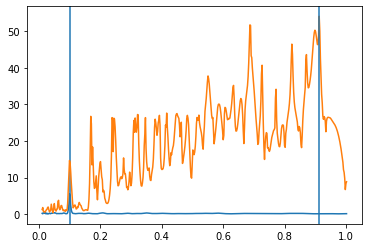

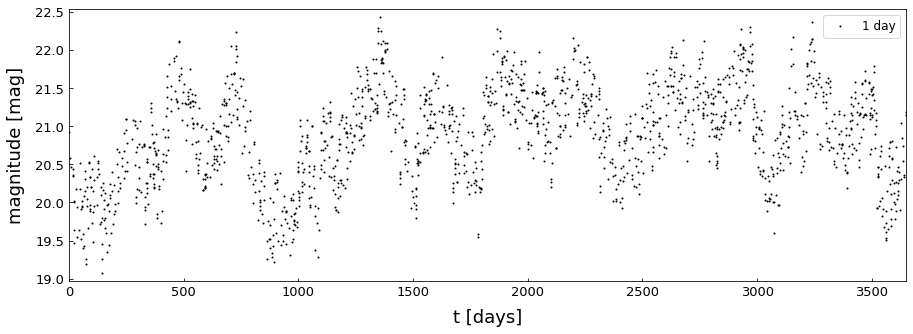

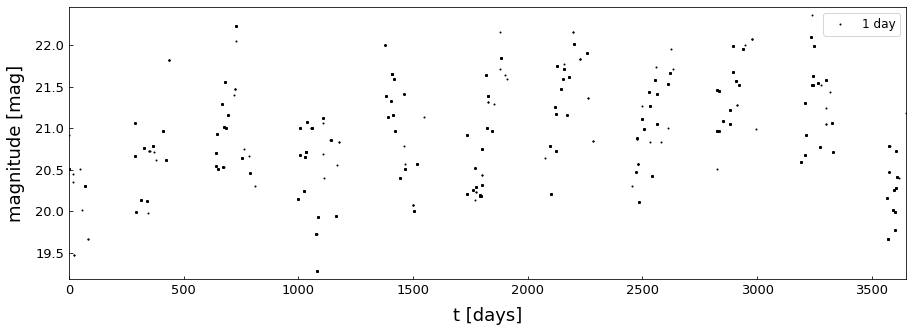

*** Starting Weighted Wavelet Z-transform ***

Pseudo sample frequency (median) is  0.651
largest tau window is  46.197
15.47 seconds has passed to complete Weighted Wavelet Z-transform 

*** Starting Weighted Wavelet Z-transform ***

Pseudo sample frequency (median) is  2400.0
largest tau window is  46.201
24.04 seconds has passed to complete Weighted Wavelet Z-transform 

[0.0125, 0.008333333333333333, -5.208333333333334e-06, True]
[0.01, 1.0, 0.00198, True]


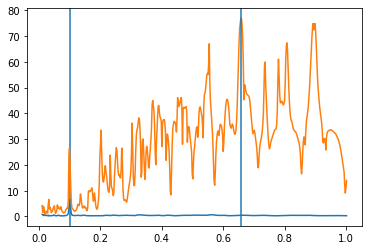

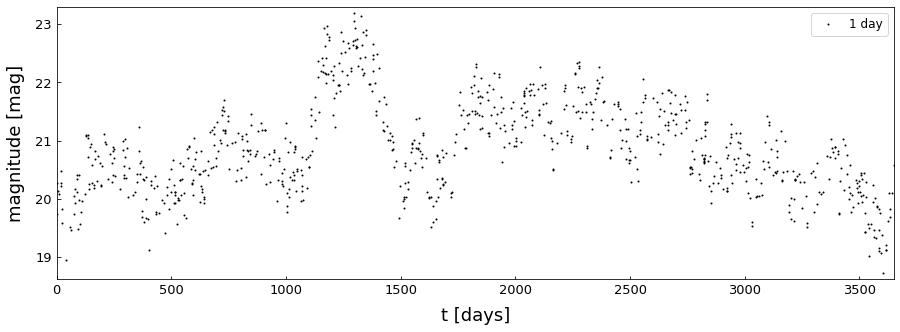

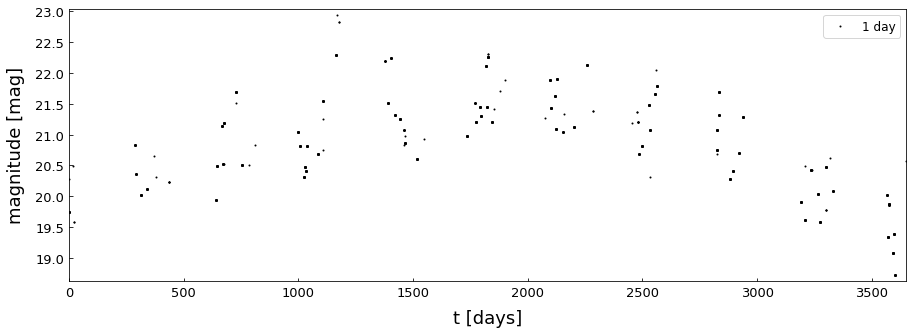

*** Starting Weighted Wavelet Z-transform ***

Pseudo sample frequency (median) is  0.322
largest tau window is  46.197
8.05 seconds has passed to complete Weighted Wavelet Z-transform 

*** Starting Weighted Wavelet Z-transform ***

Pseudo sample frequency (median) is  2400.0
largest tau window is  46.201
13.15 seconds has passed to complete Weighted Wavelet Z-transform 

[0.0125, 0.008333333333333333, -5.208333333333334e-06, True]
[0.01, 1.0, 0.00198, True]


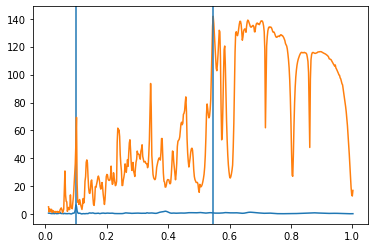

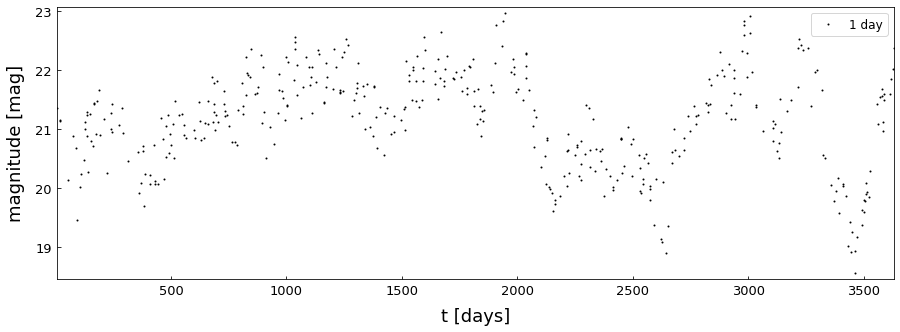

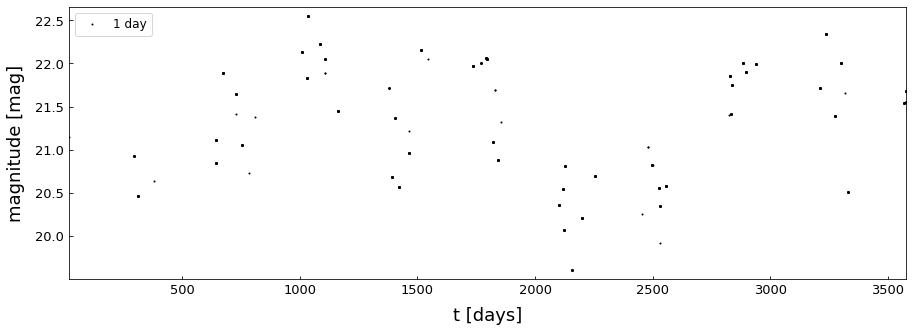

*** Starting Weighted Wavelet Z-transform ***

Pseudo sample frequency (median) is  0.156
largest tau window is  45.862
4.34 seconds has passed to complete Weighted Wavelet Z-transform 

*** Starting Weighted Wavelet Z-transform ***

Pseudo sample frequency (median) is  2400.0
largest tau window is  45.04
9.09 seconds has passed to complete Weighted Wavelet Z-transform 



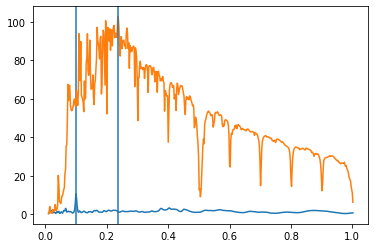

In [35]:
fmax = 1/ 1 # (1. /400.) 0.011111
fmin = 1/ 100 # (1. /1.)  0.00909
df = (fmax - fmin) / 500

amplitudes =  np.array([0.1, 0.2, 0.3, 0.4])  # [0.1, 0.2, 0.3, 0.4]
freq = np.array([10])
percent = np.array([0, 0.4, 0.6, 0.8, 0.9]) # [0, 0.4, 0.6, 0.8, 0.9]
mjd_start = np.min(opsim_data)
magnitude = 20
time_interval = 10

result2_10 = []
result2_opsim = []


for A in amplitudes: 
    for frequency in freq:
        for percentage in percent:
            print(params)
            params = [fmin, fmax, df, True] 
            print(params)
            current = np.array([A, frequency, percentage])
            tt, yy = simple_mock_lc(time_interval = time_interval, num_points = len_os, 
                                    frequency = frequency, amplitude = A, percent = percentage, magnitude = magnitude, mjd_start = mjd_start)
            ttt, yyy = artificial_lc_sampled(opsim_data, tt, yy)
            fig_plot(tt, yy) 
            fig_plot(ttt, yyy) 
            plt.show()
            
            # WWZ on simulated LC
            time_division = 80
            wwt_result, params = wwt(tt, yy, time_division, params)
            peaks, result, osex, hh1arr1  = wwt_find_freq(wwt_result, time_division)

            current = np.append(current, result)
            current = np.append(current, np.abs(result-frequency)/frequency)
            
            
            params = [fmin, fmax, df, True] 
            # WWZ on OpSim
            time_division = 80
            wwt_result, params = wwt(ttt, yyy, time_division, params)
            peaks, result, osex, hh1arr1  = wwt_find_freq(wwt_result, time_division)

            current = np.append(current, result)
            current = np.append(current, np.abs(result-frequency)/frequency)
            
            result2_10.insert(len(result2_150), current)
            
            
            

a0.1 f: 1 p : 0.6
[0.0125, 0.008333333333333333, -5.208333333333334e-06, True]
[0.5, 2.0, 0.003, True]


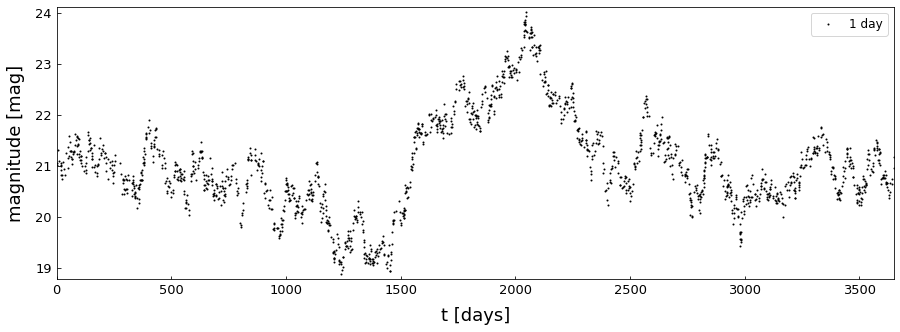

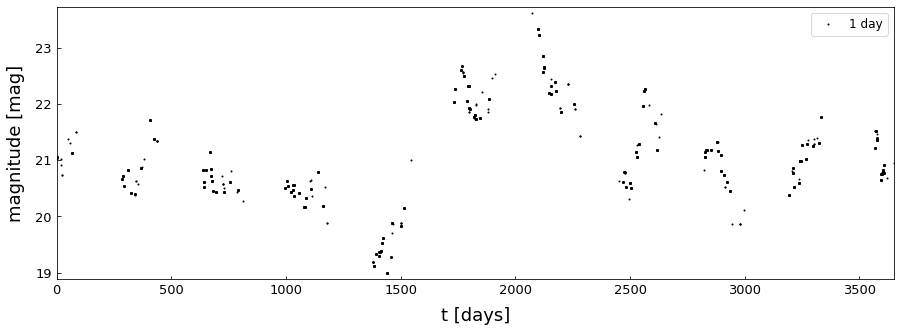

*** Starting Weighted Wavelet Z-transform ***

Pseudo sample frequency (median) is  0.651
largest tau window is  46.197
5.23 seconds has passed to complete Weighted Wavelet Z-transform 

a0.1 f: 1 p : 0.8
[0.5, 2.0, 0.003, True]
[0.5, 2.0, 0.003, True]


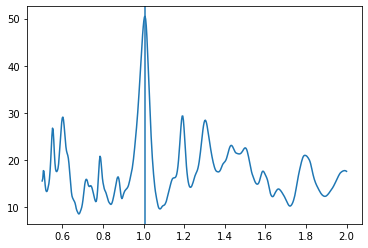

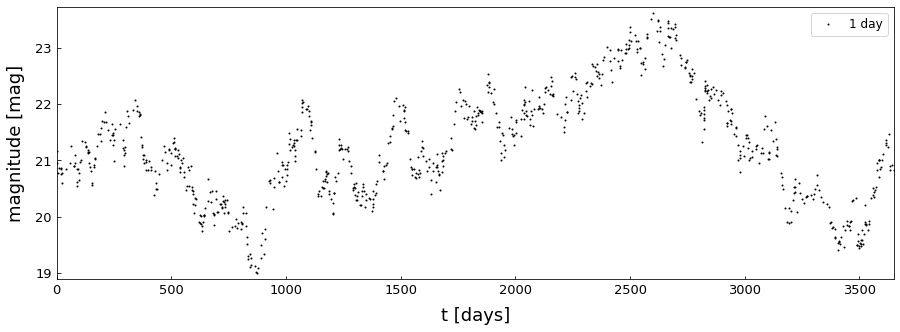

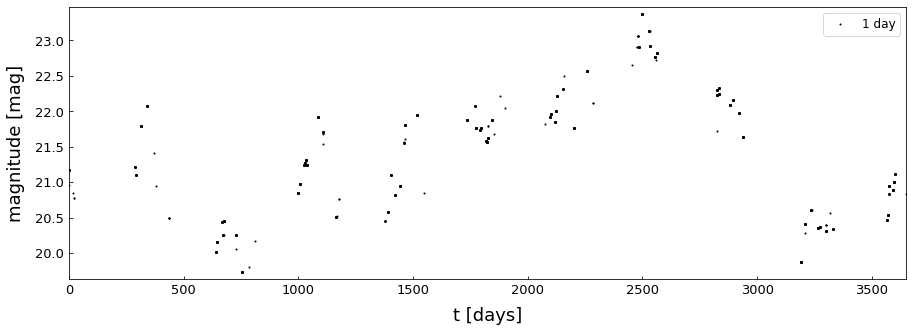

*** Starting Weighted Wavelet Z-transform ***

Pseudo sample frequency (median) is  0.322
largest tau window is  46.197
2.77 seconds has passed to complete Weighted Wavelet Z-transform 

a0.1 f: 1 p : 0.9
[0.5, 2.0, 0.003, True]
[0.5, 2.0, 0.003, True]


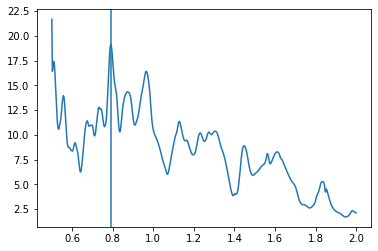

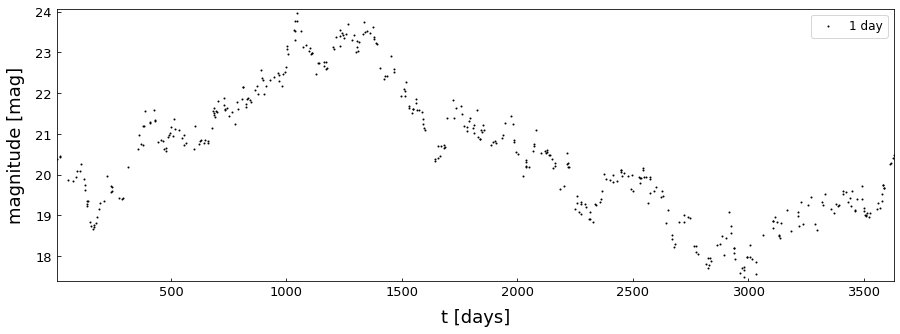

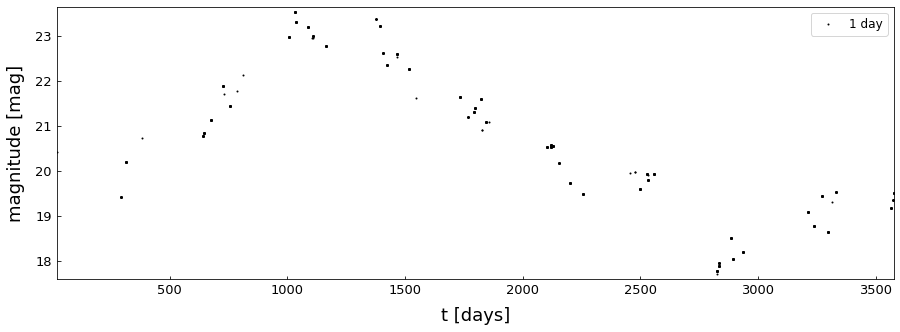

*** Starting Weighted Wavelet Z-transform ***

Pseudo sample frequency (median) is  0.156
largest tau window is  45.862
1.21 seconds has passed to complete Weighted Wavelet Z-transform 

a0.2 f: 1 p : 0.6
[0.5, 2.0, 0.003, True]
[0.5, 2.0, 0.003, True]


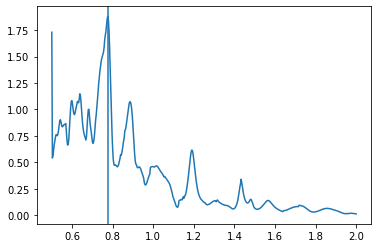

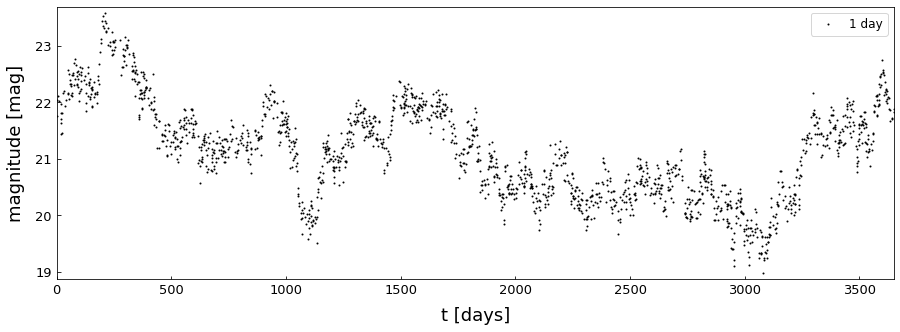

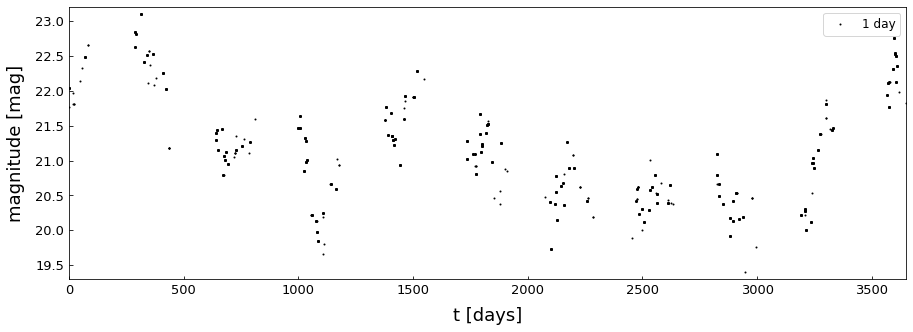

*** Starting Weighted Wavelet Z-transform ***

Pseudo sample frequency (median) is  0.651
largest tau window is  46.197
4.48 seconds has passed to complete Weighted Wavelet Z-transform 

a0.2 f: 1 p : 0.8
[0.5, 2.0, 0.003, True]
[0.5, 2.0, 0.003, True]


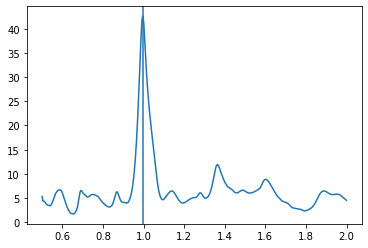

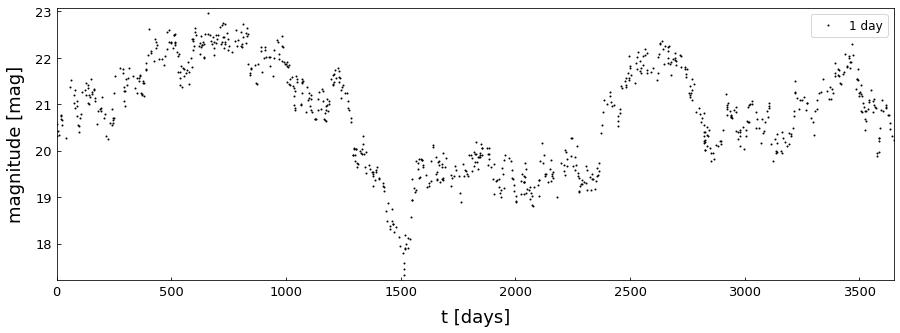

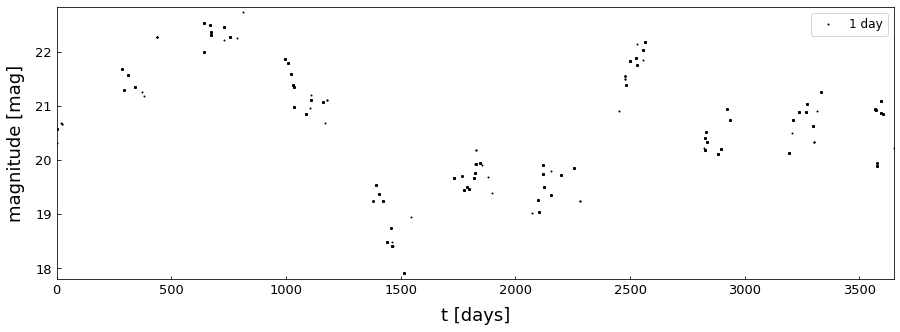

*** Starting Weighted Wavelet Z-transform ***

Pseudo sample frequency (median) is  0.322
largest tau window is  46.197
2.5 seconds has passed to complete Weighted Wavelet Z-transform 

a0.2 f: 1 p : 0.9
[0.5, 2.0, 0.003, True]
[0.5, 2.0, 0.003, True]


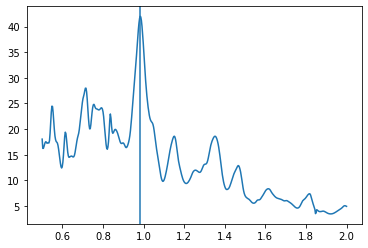

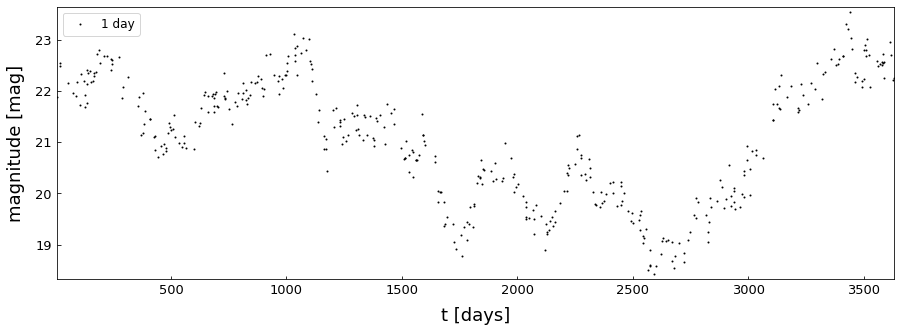

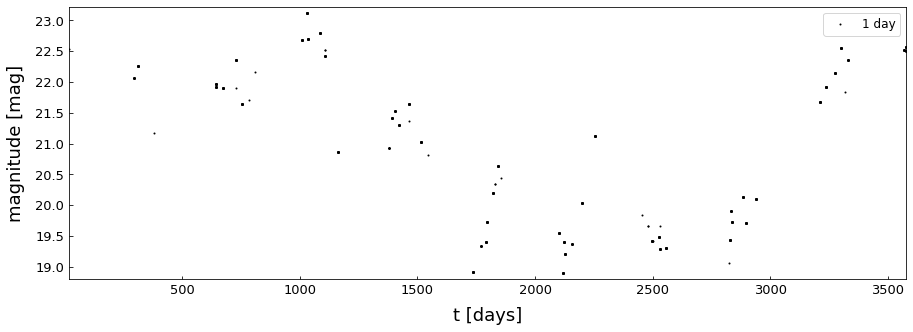

*** Starting Weighted Wavelet Z-transform ***

Pseudo sample frequency (median) is  0.156
largest tau window is  45.862
1.37 seconds has passed to complete Weighted Wavelet Z-transform 

a0.3 f: 1 p : 0.6
[0.5, 2.0, 0.003, True]
[0.5, 2.0, 0.003, True]


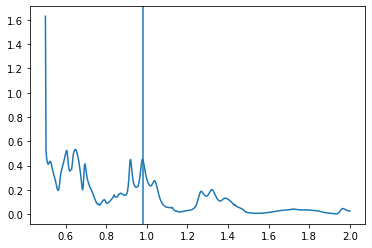

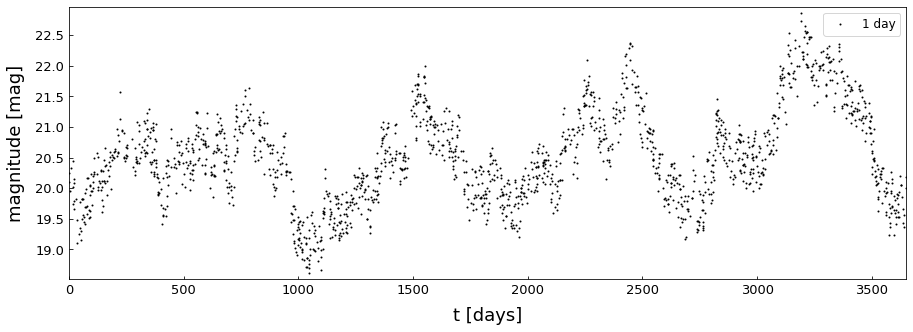

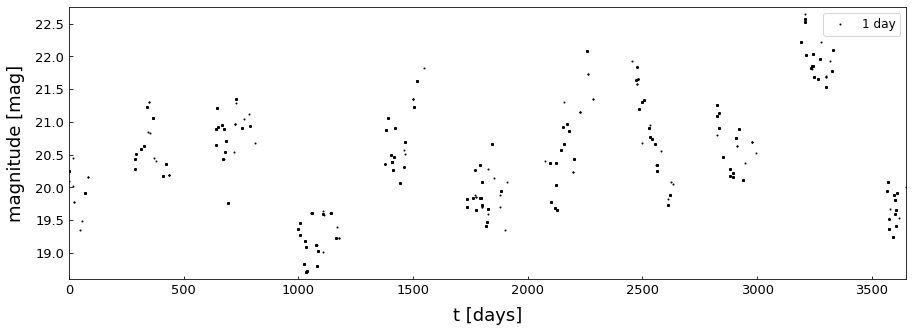

*** Starting Weighted Wavelet Z-transform ***

Pseudo sample frequency (median) is  0.651
largest tau window is  46.197
4.63 seconds has passed to complete Weighted Wavelet Z-transform 

a0.3 f: 1 p : 0.8
[0.5, 2.0, 0.003, True]
[0.5, 2.0, 0.003, True]


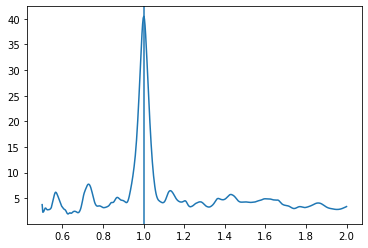

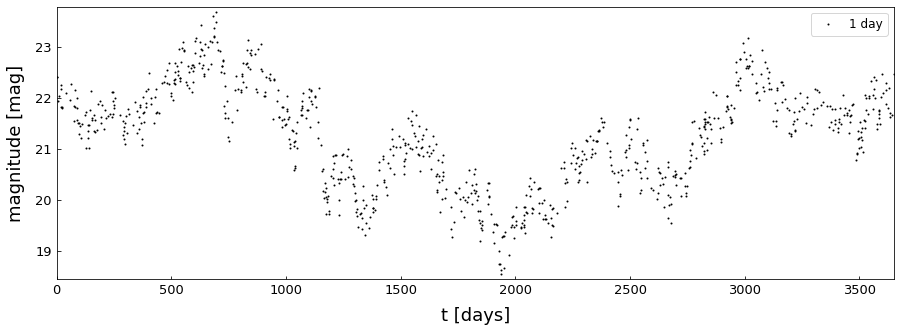

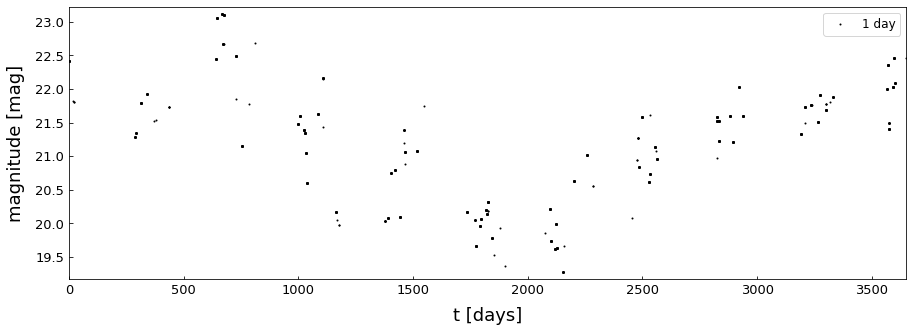

*** Starting Weighted Wavelet Z-transform ***

Pseudo sample frequency (median) is  0.322
largest tau window is  46.197
2.47 seconds has passed to complete Weighted Wavelet Z-transform 

a0.3 f: 1 p : 0.9
[0.5, 2.0, 0.003, True]
[0.5, 2.0, 0.003, True]


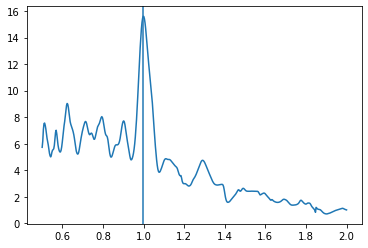

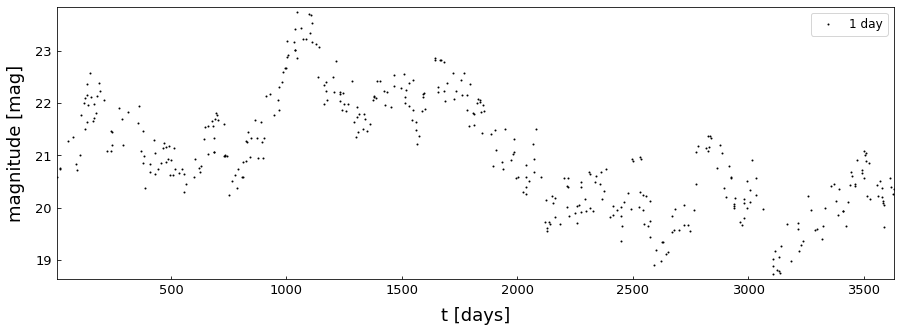

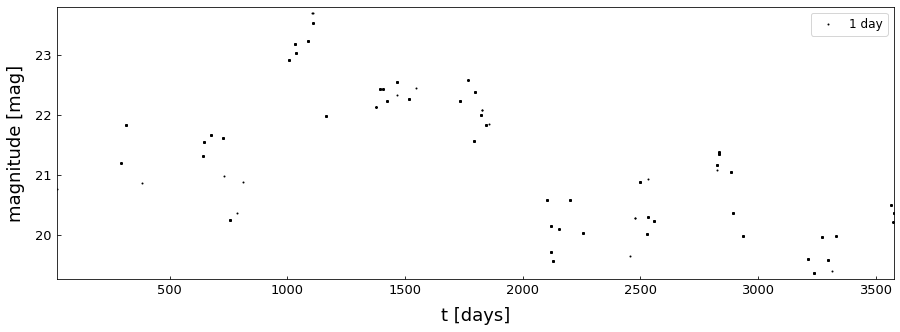

*** Starting Weighted Wavelet Z-transform ***

Pseudo sample frequency (median) is  0.156
largest tau window is  45.862
1.3 seconds has passed to complete Weighted Wavelet Z-transform 

a0.4 f: 1 p : 0.6
[0.5, 2.0, 0.003, True]
[0.5, 2.0, 0.003, True]


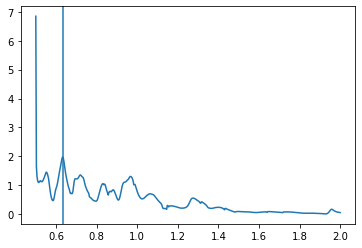

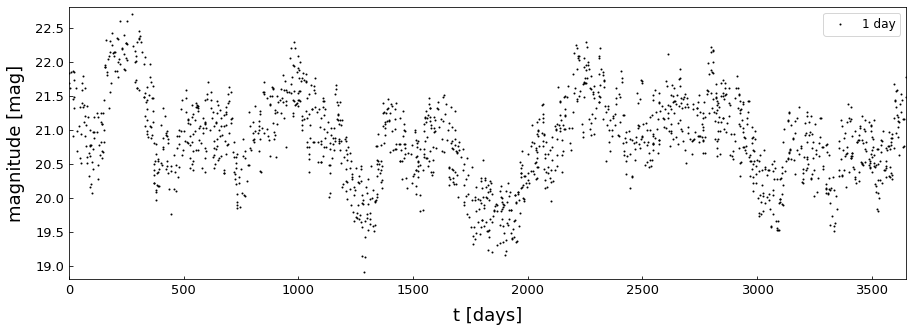

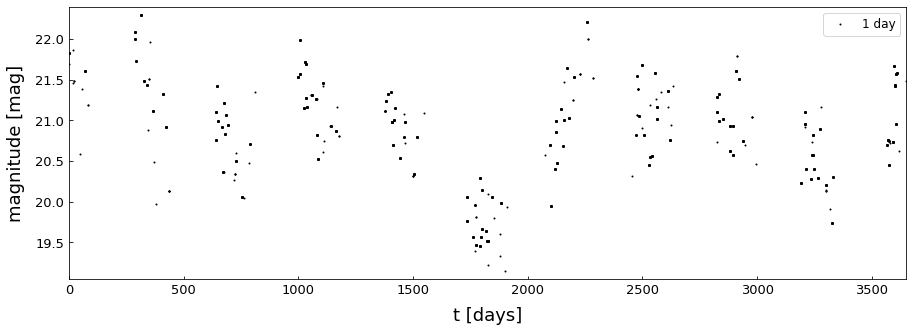

*** Starting Weighted Wavelet Z-transform ***

Pseudo sample frequency (median) is  0.651
largest tau window is  46.197
4.8 seconds has passed to complete Weighted Wavelet Z-transform 

a0.4 f: 1 p : 0.8
[0.5, 2.0, 0.003, True]
[0.5, 2.0, 0.003, True]


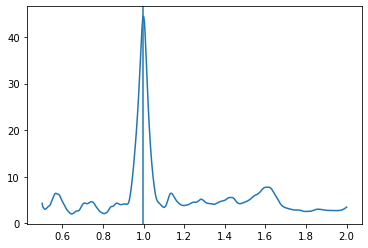

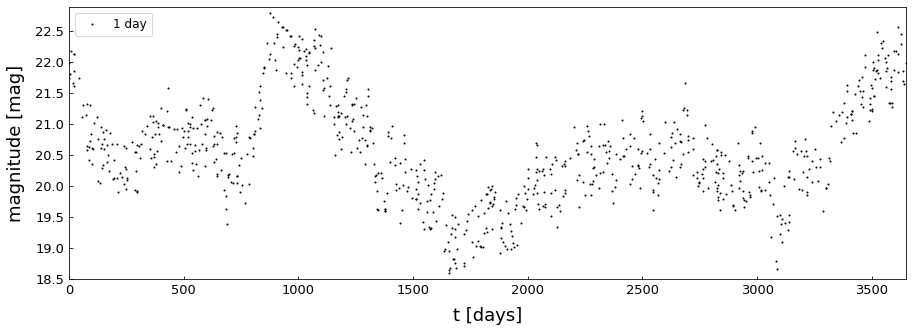

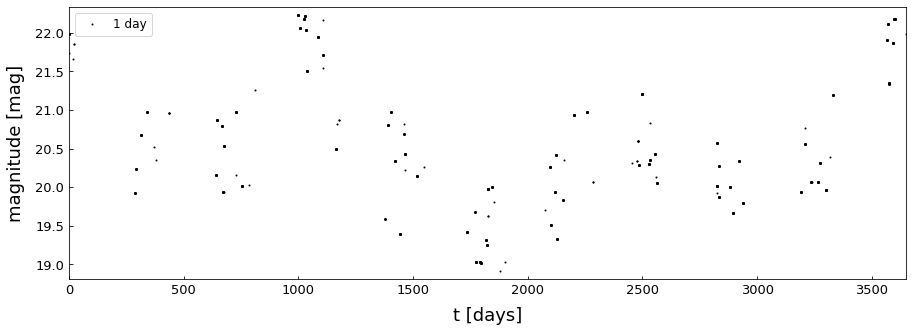

*** Starting Weighted Wavelet Z-transform ***

Pseudo sample frequency (median) is  0.322
largest tau window is  46.197
2.65 seconds has passed to complete Weighted Wavelet Z-transform 

a0.4 f: 1 p : 0.9
[0.5, 2.0, 0.003, True]
[0.5, 2.0, 0.003, True]


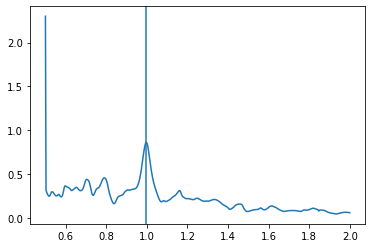

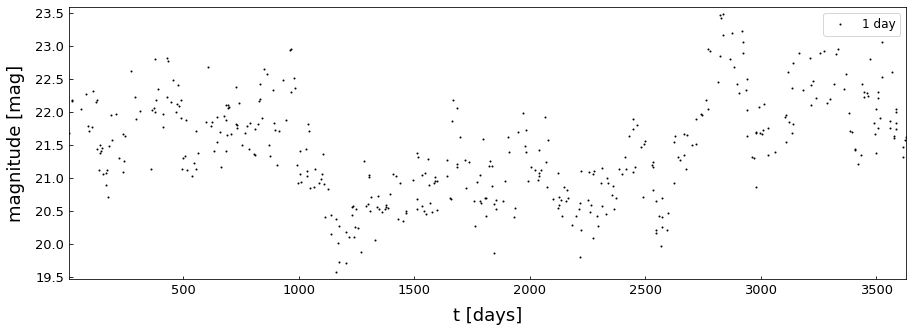

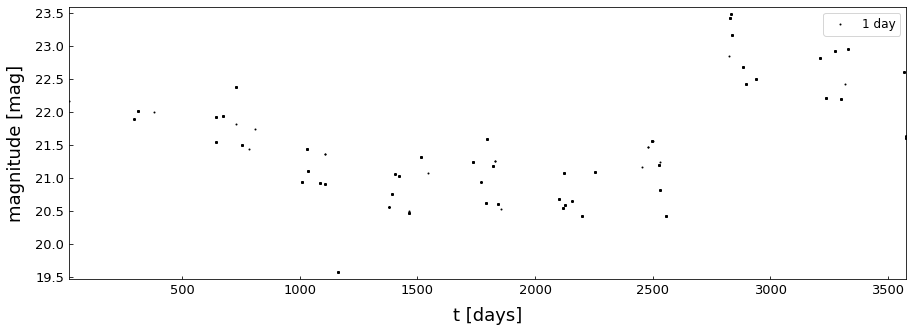

*** Starting Weighted Wavelet Z-transform ***

Pseudo sample frequency (median) is  0.156
largest tau window is  45.862
1.47 seconds has passed to complete Weighted Wavelet Z-transform 



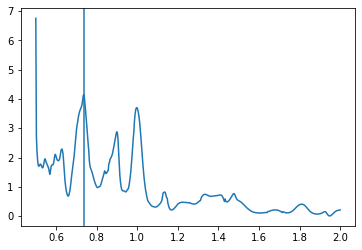

In [85]:
fmax = 1/ 0.5 # (1. /400.) 0.011111
fmin = 1/ 2 # (1. /1.)  0.00909
df = (fmax - fmin) / 500

amplitudes =  np.array([0.1, 0.2, 0.3, 0.4])  # [0.1, 0.2, 0.3, 0.4]
freq = np.array([1])
percent = np.array([0.6, 0.8, 0.9]) # [0, 0.4, 0.6, 0.8, 0.9]
mjd_start = np.min(opsim_data)
magnitude = 20
time_interval = 10



for A in amplitudes: 
    for frequency in freq:
        for percentage in percent:
            print('a' + str(A) + ' f: ' + str(frequency) + ' p : ' + str(percentage))
            print(params)
            params = [fmin, fmax, df, True] 
            print(params)
            current = np.array([A, frequency, percentage])
            tt, yy = simple_mock_lc(time_interval = time_interval, num_points = len_os, 
                                    frequency = frequency, amplitude = A, percent = percentage, magnitude = magnitude, mjd_start = mjd_start)
            ttt, yyy = artificial_lc_sampled(opsim_data, tt, yy)
            fig_plot(tt, yy) 
            fig_plot(ttt, yyy) 
            plt.show()
            
            # WWZ on simulated LC
            time_division = 80
            wwt_result, params = wwt(tt, yy, time_division, params)
            peaks, result, osex, hh1arr1  = wwt_find_freq(wwt_result, time_division)

            current = np.append(current, result)
            current = np.append(current, np.abs(result-frequency)/frequency)
            
            
            params = [fmin, fmax, df, True] 
#             # WWZ on OpSim
#             time_division = 80
#             wwt_result, params = wwt(ttt, yyy, time_division, params)
#             peaks, result, osex, hh1arr1  = wwt_find_freq(wwt_result, time_division)

            current = np.append(current, result)
            current = np.append(current, np.abs(result-frequency)/frequency)
            
            result2_1.insert(len(result2_150), current)
            
            
            

In [158]:
np.savetxt("data.csv", result2, delimiter=",")

In [11]:

def column(matrix, i):
    return [row[i] for row in matrix]

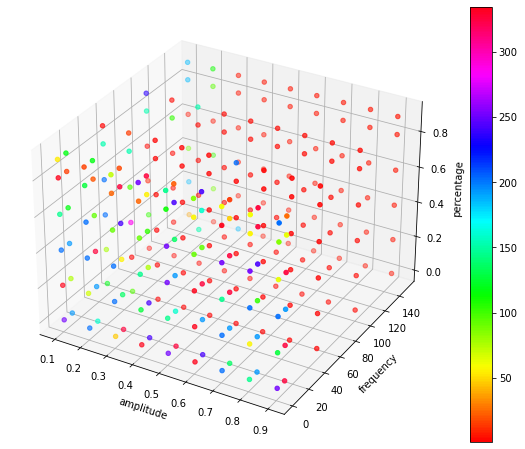

In [173]:

import matplotlib.pyplot as plt
d = result2
# import pandas as pd
# data = pd.DataFrame({"amp" : column(d,0), "freq" : column(d,1), "percent" : column(d,2), "result_lc" : column(d,3),"lc_err" : column(d,4),
#                      "result_opsim" : column(d,5), "opsim_err": column(d,6)})
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111,projection='3d')

# ax = fig.gca(projection='3d')    

# colors = cm.ScalarMappable(cmap = "viridis").to_rgba( column(d,4))
# colmap = cm.ScalarMappable(cmap=cm.hsv)
# colmap.set_array( column(d,4) )

colors = cm.hsv(column(d,4)/max(column(d,4)))

colmap = cm.ScalarMappable(cmap=cm.hsv)
colmap.set_array(column(d,4))

yg = ax.scatter(column(d,0),  column(d,1),  column(d,2), c=colors, marker='o')
cb = fig.colorbar(colmap)

ax.set_xlabel('amplitude')
ax.set_ylabel('frequency')
ax.set_zlabel('percentage')


# plot_surface with points X,Y,Z and data_value as colors
# surf = ax.plot_surface( column(d,0),  column(d,1),  column(d,2), rstride=1, cstride=1, facecolors=colors,linewidth=0, antialiased=True)
plt.show()

In [43]:
print(result2)

[array([1.00000000e-01, 1.00000000e+02, 0.00000000e+00, 2.87769784e+02,
       1.87769784e+00, 2.24719101e+02, 1.24719101e+00]), array([1.00000000e-01, 1.00000000e+02, 4.00000000e-01, 2.87769784e+02,
       1.87769784e+00, 2.87769784e+02, 1.87769784e+00]), array([1.00000000e-01, 1.00000000e+02, 6.00000000e-01, 2.24719101e+02,
       1.24719101e+00, 3.46921075e+01, 6.53078925e-01]), array([1.00000000e-01, 1.00000000e+02, 0.00000000e+00, 3.04878049e+02,
       2.04878049e+00, 3.24149109e+02, 2.24149109e+00]), array([1.00000000e-01, 1.00000000e+02, 4.00000000e-01, 3.04878049e+02,
       2.04878049e+00, 2.46305419e+02, 1.46305419e+00]), array([1.00000000e-01, 1.00000000e+02, 6.00000000e-01, 1.32100396e+02,
       3.21003963e-01, 1.98609732e+02, 9.86097319e-01]), array([1.00000000e-01, 1.00000000e+02, 8.00000000e-01, 1.77935943e+02,
       7.79359431e-01, 1.96618168e+01, 8.03381832e-01]), array([  0.1       , 100.        ,   0.9       ,  47.12535344,
         0.52874647,  20.28397566,   0.7

In [44]:
def arr_with_freq(d, freq):
    out = []
    for tmp in d:
        if( tmp[1] == freq):
            tmp2 = [tmp[0], tmp[2], tmp[4] ]
            out.insert(len(out), tmp2)
    return out



In [69]:
np.savetxt("data_100days.csv", result2, delimiter=",")

[[0.1, 0.0, 1.8776978417266184], [0.1, 0.4, 1.8776978417266184], [0.1, 0.6, 1.2471910112359545], [0.1, 0.0, 2.0487804878048785], [0.1, 0.4, 2.0487804878048785], [0.1, 0.6, 0.32100396301188966], [0.1, 0.8, 0.7793594306049829], [0.1, 0.9, 0.5287464655984917], [0.2, 0.0, 0.6116035455278009], [0.2, 0.4, 1.877697841726619], [0.2, 0.6, 1.58732212160414], [0.2, 0.8, 0.010390895596238892], [0.2, 0.9, 1.1528525296017234], [0.3, 0.0, 0.00908173562058579], [0.3, 0.4, 0.010390895596238892], [0.3, 0.6, 0.9860973187686204], [0.3, 0.8, 0.02933607822954258], [0.3, 0.9, 0.010390895596238892], [0.4, 0.0, 0.010390895596238892], [0.4, 0.4, 0.010390895596238892], [0.4, 0.6, 0.010390895596238892], [0.4, 0.8, 0.02933607822954258], [0.4, 0.9, 0.010390895596238892]]


<Figure size 720x576 with 0 Axes>

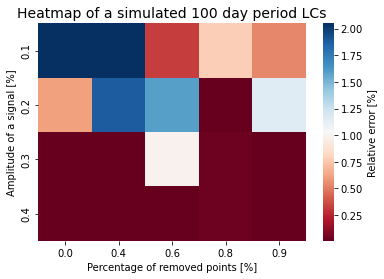

In [118]:
freq_1 = arr_with_freq(result2, 100)
print(freq_1)
import matplotlib.pyplot as plt
import numpy as np
fig = plt.figure(figsize=(10,8))
z = column(freq_1, 2)
z_min, z_max = -np.abs(z).max(), np.abs(z).max()
fig, ax = plt.subplots()
x = column(freq_1, 0)
y = column(freq_1, 1)
import seaborn as sns
import pandas as pd
# # ax = sns.heatmap(freq_1, linewidth=0)
# plt.contourf(freq_1) #reshape Z too!
df = pd.DataFrame.from_dict(np.array([x,y,z]).T)
df.columns = ['Amplitude of a signal [%]','Percentage of removed points [%]','diff']
df['diff'] = pd.to_numeric(df['diff'])
df = df.drop(df.index[[0,1,2]])
pivotted= df.pivot('Amplitude of a signal [%]','Percentage of removed points [%]','diff')
plt.title('Heatmap of a simulated 100 day period LCs', fontsize = 14) #
sns.heatmap(pivotted,cmap='RdBu',  cbar_kws={'label': 'Relative error [%]'})
plt.savefig("100days_lcs.pdf",  dpi=100, format='pdf', bbox_inches = "tight")
plt.show()


In [119]:
np.savetxt("data_150days.csv", result2_150, delimiter=",")

20


<Figure size 720x576 with 0 Axes>

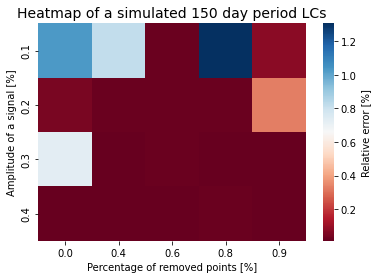

In [120]:
freq_1 = arr_with_freq(result2_150, 150)
import matplotlib.pyplot as plt
import numpy as np
print(len(freq_1))

fig = plt.figure(figsize=(10,8))

z = column(freq_1, 2)
z_min, z_max = -np.abs(z).max(), np.abs(z).max()
fig, ax = plt.subplots()
x = column(freq_1, 0)
y = column(freq_1, 1)
import seaborn as sns

# # ax = sns.heatmap(freq_1, linewidth=0)
# plt.contourf(freq_1) #reshape Z too!
df = pd.DataFrame.from_dict(np.array([x,y,z]).T)
df.columns = ['Amplitude of a signal [%]','Percentage of removed points [%]','diff']
df['diff'] = pd.to_numeric(df['diff'])
pivotted= df.pivot('Amplitude of a signal [%]','Percentage of removed points [%]','diff')
plt.title('Heatmap of a simulated 150 day period LCs', fontsize = 14) #
sns.heatmap(pivotted,cmap='RdBu',  cbar_kws={'label': 'Relative error [%]'})
plt.savefig("150days_lcs.pdf",  dpi=100, format='pdf', bbox_inches = "tight")
plt.show()


In [112]:
# np.savetxt("data_10days.csv", result2_10, delimiter=",")
print(column(result2_150, 2))
print(column(result2_150, 3))

[0.0, 0.4, 0.6, 0.8, 0.9, 0.0, 0.4, 0.6, 0.8, 0.9, 0.0, 0.4, 0.6, 0.8, 0.9, 0.0, 0.4, 0.6, 0.8, 0.9]
[304.87804878048786, 272.4795640326976, 147.27540500736382, 346.02076124567475, 161.1603545527801, 156.25000000000006, 147.27540500736382, 147.27540500736382, 147.27540500736382, 100.90817356205858, 258.732212160414, 151.6300227445035, 147.27540500736382, 151.6300227445035, 151.6300227445035, 151.6300227445035, 151.6300227445035, 151.6300227445035, 147.27540500736382, 151.6300227445035]


20


<Figure size 720x576 with 0 Axes>

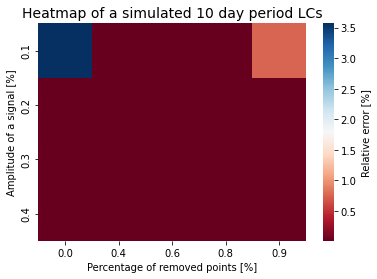

In [121]:
freq_1 = arr_with_freq(result2_10, 10)
import matplotlib.pyplot as plt
import numpy as np
print(len(freq_1))

fig = plt.figure(figsize=(10,8))

z = column(freq_1, 2)
z_min, z_max = -np.abs(z).max(), np.abs(z).max()
fig, ax = plt.subplots()
x = column(freq_1, 0)
y = column(freq_1, 1)
import seaborn as sns

# # ax = sns.heatmap(freq_1, linewidth=0)
# plt.contourf(freq_1) #reshape Z too!
df = pd.DataFrame.from_dict(np.array([x,y,z]).T)
df.columns = ['Amplitude of a signal [%]','Percentage of removed points [%]','diff']
df['diff'] = pd.to_numeric(df['diff'])
pivotted= df.pivot('Amplitude of a signal [%]','Percentage of removed points [%]','diff')
plt.title('Heatmap of a simulated 10 day period LCs', fontsize = 14) #

sns.heatmap(pivotted,cmap='RdBu',  cbar_kws={'label': 'Relative error [%]'})
plt.savefig("10days_lcs.pdf",  dpi=100, format='pdf', bbox_inches = "tight")
plt.show()


In [86]:
np.savetxt("data_1days.csv", result2_1, delimiter=",")

20


<Figure size 720x576 with 0 Axes>

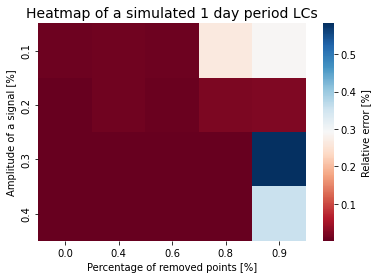

In [122]:
freq_1 = arr_with_freq(result2_1, 1)
import matplotlib.pyplot as plt
import numpy as np
print(len(freq_1))

fig = plt.figure(figsize=(10,8))

z = column(freq_1, 2)
z_min, z_max = -np.abs(z).max(), np.abs(z).max()
fig, ax = plt.subplots()
x = column(freq_1, 0)
y = column(freq_1, 1)
import seaborn as sns

# # ax = sns.heatmap(freq_1, linewidth=0)
# plt.contourf(freq_1) #reshape Z too!
df = pd.DataFrame.from_dict(np.array([x,y,z]).T)
df.columns = ['Amplitude of a signal [%]','Percentage of removed points [%]','diff']
df['diff'] = pd.to_numeric(df['diff'])
pivotted= df.pivot('Amplitude of a signal [%]','Percentage of removed points [%]','diff')
plt.title('Heatmap of a simulated 1 day period LCs', fontsize = 14) #


sns.heatmap(pivotted,cmap='RdBu',  cbar_kws={'label': 'Relative error [%]'})
plt.savefig("1days_lcs.pdf",  dpi=100, format='pdf', bbox_inches = "tight")
plt.show()


In [89]:
def arr_with_freq_opsim(d, freq):
    out = []
    for tmp in d:
        if( tmp[1] == freq):
            tmp2 = [tmp[0], tmp[2], tmp[6] ]
            out.insert(len(out), tmp2)
    return out


[array([0.1       , 1.        , 0.        , 0.99304866, 0.00695134,
       1.19617225, 0.19617225]), array([0.1       , 1.        , 0.4       , 1.00806452, 0.00806452,
       1.07296137, 0.07296137]), array([0.2       , 1.        , 0.        , 1.00200401, 0.00200401,
       1.14678899, 0.14678899]), array([0.2       , 1.        , 0.4       , 1.00806452, 0.00806452,
       1.20481928, 0.20481928]), array([3.00000000e-01, 1.00000000e+00, 0.00000000e+00, 9.99000999e-01,
       9.99000999e-04, 1.20481928e+00, 2.04819277e-01]), array([3.00000000e-01, 1.00000000e+00, 4.00000000e-01, 9.99000999e-01,
       9.99000999e-04, 1.24533001e+00, 2.45330012e-01]), array([4.00000000e-01, 1.00000000e+00, 0.00000000e+00, 9.99000999e-01,
       9.99000999e-04, 1.17508813e+00, 1.75088132e-01]), array([0.4       , 1.        , 0.4       , 1.00200401, 0.00200401,
       1.23609394, 0.23609394]), array([0.1       , 1.        , 0.6       , 0.99304866, 0.00695134,
       0.99304866, 0.00695134]), array([0.1     

<Figure size 720x576 with 0 Axes>

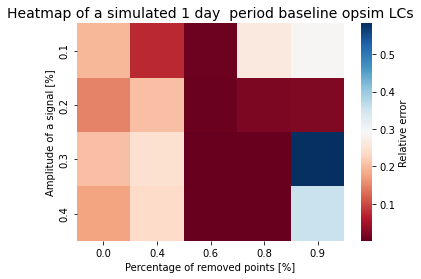

In [104]:
freq_1 = arr_with_freq_opsim(result2_1, 1)
print(result2_1)
import matplotlib.pyplot as plt
import numpy as np
print(len(freq_1))

fig = plt.figure(figsize=(10,8))

z = column(freq_1, 2)
z_min, z_max = -np.abs(z).max(), np.abs(z).max()
fig, ax = plt.subplots()
x = column(freq_1, 0)
y = column(freq_1, 1)
import seaborn as sns

# # ax = sns.heatmap(freq_1, linewidth=0)
# plt.contourf(freq_1) #reshape Z too!
df = pd.DataFrame.from_dict(np.array([x,y,z]).T)
df.columns = ['Amplitude of a signal [%]','Percentage of removed points [%]','diff']
df['diff'] = pd.to_numeric(df['diff'])
pivotted= df.pivot('Amplitude of a signal [%]','Percentage of removed points [%]','diff')
plt.title('Heatmap of a simulated 1 day  period baseline opsim LCs', fontsize = 14) #



sns.heatmap(pivotted,cmap='RdBu',  cbar_kws={'label': 'Relative error'})
plt.savefig("1days_lcs_opsim.pdf",  dpi=100, format='pdf', bbox_inches = "tight")
plt.show()


20


<Figure size 720x576 with 0 Axes>

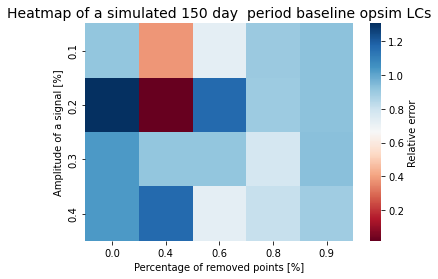

In [105]:
freq_1 = arr_with_freq_opsim(result2_150, 150)
import matplotlib.pyplot as plt
import numpy as np
print(len(freq_1))

fig = plt.figure(figsize=(10,8))

z = column(freq_1, 2)
z_min, z_max = -np.abs(z).max(), np.abs(z).max()
fig, ax = plt.subplots()
x = column(freq_1, 0)
y = column(freq_1, 1)
import seaborn as sns

# # ax = sns.heatmap(freq_1, linewidth=0)
# plt.contourf(freq_1) #reshape Z too!
df = pd.DataFrame.from_dict(np.array([x,y,z]).T)
df.columns = ['Amplitude of a signal [%]','Percentage of removed points [%]','diff']
df['diff'] = pd.to_numeric(df['diff'])
pivotted= df.pivot('Amplitude of a signal [%]','Percentage of removed points [%]','diff')
plt.title('Heatmap of a simulated 150 day  period baseline opsim LCs', fontsize = 14) #


sns.heatmap(pivotted,cmap='RdBu',  cbar_kws={'label': 'Relative error'})
plt.savefig("150days_lcs_opsim.pdf",  dpi=100, format='pdf', bbox_inches = "tight")
plt.show()


20


<Figure size 720x576 with 0 Axes>

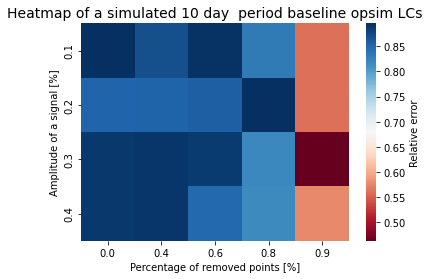

In [106]:
freq_1 = arr_with_freq_opsim(result2_10, 10)
import matplotlib.pyplot as plt
import numpy as np
print(len(freq_1))

fig = plt.figure(figsize=(10,8))

z = column(freq_1, 2)
z_min, z_max = -np.abs(z).max(), np.abs(z).max()
fig, ax = plt.subplots()
x = column(freq_1, 0)
y = column(freq_1, 1)
import seaborn as sns

# # ax = sns.heatmap(freq_1, linewidth=0)
# plt.contourf(freq_1) #reshape Z too!
df = pd.DataFrame.from_dict(np.array([x,y,z]).T)
df.columns = ['Amplitude of a signal [%]','Percentage of removed points [%]','diff']
df['diff'] = pd.to_numeric(df['diff'])
pivotted= df.pivot('Amplitude of a signal [%]','Percentage of removed points [%]','diff')
plt.title('Heatmap of a simulated 10 day  period baseline opsim LCs', fontsize = 14) #


sns.heatmap(pivotted,cmap='RdBu',  cbar_kws={'label': 'Relative error'})
plt.savefig("10days_lcs_opsim.pdf",  dpi=100, format='pdf', bbox_inches = "tight")
plt.show()


23


<Figure size 720x576 with 0 Axes>

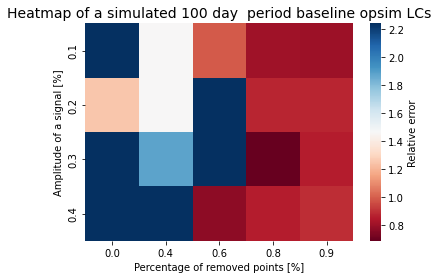

In [107]:
freq_1 = arr_with_freq_opsim(result2, 100)
import matplotlib.pyplot as plt
import numpy as np
print(len(freq_1))

fig = plt.figure(figsize=(10,8))

z = column(freq_1, 2)
z_min, z_max = -np.abs(z).max(), np.abs(z).max()
fig, ax = plt.subplots()
x = column(freq_1, 0)
y = column(freq_1, 1)
import seaborn as sns

# # ax = sns.heatmap(freq_1, linewidth=0)
# plt.contourf(freq_1) #reshape Z too!
df = pd.DataFrame.from_dict(np.array([x,y,z]).T)
df.columns = ['Amplitude of a signal [%]','Percentage of removed points [%]','diff']
df['diff'] = pd.to_numeric(df['diff'])

df = df.drop(df.index[[0,1,2]])
pivotted= df.pivot('Amplitude of a signal [%]','Percentage of removed points [%]','diff')
plt.title('Heatmap of a simulated 100 day  period baseline opsim LCs', fontsize = 14) #

sns.heatmap(pivotted,cmap='RdBu',  cbar_kws={'label': 'Relative error'})
plt.savefig("100days_lcs_opsim.pdf",  dpi=100, format='pdf', bbox_inches = "tight")
plt.show()
